# CODERSPACE · COMMUNITY PREDICTION COMPETITION 

# GDZ Elektrik Datathon 2024 - Final:

"Maintaining the continuity and quality of energy is among the basic duties of electricity distribution companies. While power outages are sometimes planned, sometimes they occur unplanned and unexpected. Against unplanned outages, electricity distribution companies try to ensure energy continuity by minimizing the downtime with fast and effective interventions. To ensure this continuity, special rule-based work order software is generally used in the field.

As data scientists, we are expected to predict the number of unplanned outages going forward in the regions served by GDZ. In the district breakdown, daily unplanned outage numbers, meteorological data and data on special days are provided.

🛡️ We want you to estimate the number of daily unplanned outages based on district!"

## Evaluation

The success metric in the Kaggle competition will be Mean Absolute Error (MAE).

### I completed the Gdz Elektrik Datathon 2024 Kaggle competition organized by Coderspace as 24th on the leaderboard with a score of 1.79112 among 184 Teams/276 participants

In [24]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
import calendar

In [2]:
# load the dataset
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_holidays = pd.read_csv('holidays.csv')
df_weather = pd.read_csv('weather.csv')
df_sample_submission = pd.read_csv('sample_submission.csv')

## Dataset Description

### train.csv

tarih — Kesintinin gerçekleştiği tarih

ilce — Kesintinin gerçekleştiği il-ilçe. Örnek: “manisa-akhisar”

bildirimli_sum — Planlı kesinti sayısı

bildirimsiz_sum — Plansız kesinti sayısı (Tahmin edilecek hedef değişken 🎯)


### test.csv

tarih — Kesintinin gerçekleştiği tarih

ilce — Kesintinin gerçekleştiği il-ilçe. Örnek: “manisa-akhisar”

bildirimli_sum — Planlı kesinti sayısı

### weather.csv
date — Saatlik zamann


lat — Enlem

lon — Boylam

t_2m:C — Sıcaklık, Celcius

effective_cloud_cover:p — Bulutluluk

global_rad:W — Güneşlilik değeri, Watt

relative_humidity_2m:p — Bağıl nem

wind_dir_10m:d — Rüzgar yönü

wind_speed_10m:ms — Rüzgar hızı, m/s

prob_precip_1h:p — Yağış

t_apparent:C — Hissedilen sıcaklık

name — İl-İlçe ikilisi. Örnek: “manisa-akhisar”

### holidays.csv

Yıl

Ay

Gün

Tatil Adı — Tatil adı

### sample_submission.csv

unique_id — test dönemindeki ilce ve tarih ikililerinden “[ilce]-[tarih]” formatında oluşturulmuş tekil id. Örnek: "2024-01-04-manisa-akhisar"

bildirimsiz_sum — Tahmin edilmesi gereken toplam plansız kesinti sayısı


In [3]:
# Function to get a quick summary of dataframe
def check_dataset(dataframe, head=5):
    print("############################## --Shape-- ###############################")
    print(dataframe.shape)
    print("############################## --Columns-- ###############################")
    print(dataframe.columns)
    print("############################## --Types-- ###############################")
    print(dataframe.dtypes)
    print("############################## --Head-- ###############################")
    print(dataframe.head(head))
    print("############################## --Tail-- ###############################")
    print(dataframe.tail(head))
    print("############################## --NA-- ###############################")
    print(dataframe.isnull().sum())
    print("############################## --Describe-- ###############################")
    print(dataframe.describe().T)

In [4]:
# Get a quick summary of train dataset
check_dataset(df_train)

############################## --Shape-- ###############################
(48148, 4)
############################## --Columns-- ###############################
Index(['tarih', 'ilce', 'bildirimsiz_sum', 'bildirimli_sum'], dtype='object')
############################## --Types-- ###############################
tarih              object
ilce               object
bildirimsiz_sum     int64
bildirimli_sum      int64
dtype: object
############################## --Head-- ###############################
        tarih          ilce  bildirimsiz_sum  bildirimli_sum
0  2021-01-01  izmir-aliaga                5               0
1  2021-01-02  izmir-aliaga               13               0
2  2021-01-03  izmir-aliaga                4               0
3  2021-01-04  izmir-aliaga                9               0
4  2021-01-05  izmir-aliaga                2               0
############################## --Tail-- ###############################
            tarih            ilce  bildirimsiz_sum  bildirimli

In [5]:
# Get a quick summary of test dataset
check_dataset(df_test)

############################## --Shape-- ###############################
(1363, 3)
############################## --Columns-- ###############################
Index(['tarih', 'ilce', 'bildirimli_sum'], dtype='object')
############################## --Types-- ###############################
tarih             object
ilce              object
bildirimli_sum     int64
dtype: object
############################## --Head-- ###############################
        tarih            ilce  bildirimli_sum
0  2024-02-01    izmir-aliaga               0
1  2024-02-01  izmir-bayindir               1
2  2024-02-01  izmir-bayrakli               0
3  2024-02-01   izmir-bergama               1
4  2024-02-01   izmir-bornova               1
############################## --Tail-- ###############################
           tarih             ilce  bildirimli_sum
1358  2024-02-29     izmir-beydag               0
1359  2024-02-29  izmir-narlidere               0
1360  2024-02-29     izmir-selcuk               0
1

In [6]:
# Get a quick summary of holidays dataset
check_dataset(df_holidays)

############################## --Shape-- ###############################
(55, 4)
############################## --Columns-- ###############################
Index(['Yıl', 'Ay', 'Gün', 'Tatil Adı'], dtype='object')
############################## --Types-- ###############################
Yıl           int64
Ay            int64
Gün           int64
Tatil Adı    object
dtype: object
############################## --Head-- ###############################
    Yıl  Ay  Gün                                       Tatil Adı
0  2021   1    1                                  New Year's Day
1  2021   4   23         National Sovereignty and Children's Day
2  2021   5    1                                      Labour Day
3  2021   5   19  Commemoration of Ataturk, Youth and Sports Day
4  2021   7   15                Democracy and National Unity Day
############################## --Tail-- ###############################
     Yıl  Ay  Gün                              Tatil Adı
50  2024   4   12    Ramadan 

In [7]:
# Get a quick summary of weather dataset
check_dataset(df_weather)

############################## --Shape-- ###############################
(1302840, 12)
############################## --Columns-- ###############################
Index(['date', 'lat', 'lon', 't_2m:C', 'effective_cloud_cover:p',
       'global_rad:W', 'relative_humidity_2m:p', 'wind_dir_10m:d',
       'wind_speed_10m:ms', 'prob_precip_1h:p', 't_apparent:C', 'name'],
      dtype='object')
############################## --Types-- ###############################
date                        object
lat                        float64
lon                        float64
t_2m:C                     float64
effective_cloud_cover:p    float64
global_rad:W               float64
relative_humidity_2m:p     float64
wind_dir_10m:d             float64
wind_speed_10m:ms          float64
prob_precip_1h:p           float64
t_apparent:C               float64
name                        object
dtype: object
############################## --Head-- ###############################
                  date      lat

In [8]:
# Get a quick summary of sample submission dataset
check_dataset(df_sample_submission)

############################## --Shape-- ###############################
(1363, 2)
############################## --Columns-- ###############################
Index(['unique_id', 'bildirimsiz_sum'], dtype='object')
############################## --Types-- ###############################
unique_id           object
bildirimsiz_sum    float64
dtype: object
############################## --Head-- ###############################
                   unique_id  bildirimsiz_sum
0    2024-02-01-izmir-aliaga              NaN
1  2024-02-01-izmir-bayindir              NaN
2  2024-02-01-izmir-bayrakli              NaN
3   2024-02-01-izmir-bergama              NaN
4   2024-02-01-izmir-bornova              NaN
############################## --Tail-- ###############################
                       unique_id  bildirimsiz_sum
1358     2024-02-29-izmir-beydag              NaN
1359  2024-02-29-izmir-narlidere              NaN
1360     2024-02-29-izmir-selcuk              NaN
1361      2024-02-29-mani

# Preprocessing-Feature Engineering

In [9]:
# Convert 'Date' and 'tarih' columns to datetime format
df_train['tarih'] = pd.to_datetime(df_train['tarih'])
df_test['tarih'] = pd.to_datetime(df_test['tarih'])
df_weather['date'] = pd.to_datetime(df_weather['date'])

In [10]:
# Function to capitalize the first letter after each hyphen in a string
def capitalize_after_hyphen(s):
    return s.str.replace(r'\b(\w)(\w*)', lambda x: x.group(1).upper() + x.group(2).lower(), regex=True)

# Apply the capitalize_after_hyphen function to the 'ilce' column of both dataframes
df_train['ilce'] = capitalize_after_hyphen(df_train['ilce'])
df_test['ilce'] = capitalize_after_hyphen(df_test['ilce'])

# Extract the part of the 'ilce' column before the first hyphen and assign it to the 'il' column
df_train['il'] = df_train['ilce'].str.split('-').str[0]
df_test['il'] = df_test['ilce'].str.split('-').str[0]

In [11]:
# Function to calculate the percentage of "bildirimli_sum" for each row
def hesapla_ilce_yuzdesi(row):
    if row["bildirimli_sum"] == 0:
        return 0
    else:
        ildeki_toplam = df_train[(df_train["il"] == row["il"]) & (df_train["tarih"] == row["tarih"])]["bildirimli_sum"].sum()
        return (row["bildirimli_sum"] / ildeki_toplam) * 100

# Create the new "ilce_yuzde" column by applying the "hesapla_ilce_yuzdesi" function to each row
df_train["ilce_yuzde"] = df_train.apply(hesapla_ilce_yuzdesi, axis=1)

In [12]:
# Function to calculate the percentage of "bildirimli_sum" for each row
def hesapla_ilce_yuzdesi_test(row):
    if row["bildirimli_sum"] == 0:
        return 0
    else:
        ildeki_toplam = df_test[(df_test["il"] == row["il"]) & (df_test["tarih"] == row["tarih"])]["bildirimli_sum"].sum()
        return (row["bildirimli_sum"] / ildeki_toplam) * 100


# Create the new "ilce_yuzde" column by applying the "hesapla_ilce_yuzdesi" function to each row
df_test["ilce_yuzde"] = df_test.apply(hesapla_ilce_yuzdesi_test, axis=1)

In [13]:
# Create a new column as "planlı" in order to determine if there is a planned outage based on the value of "bildirimli_sum" or not
df_train["planlı"] = df_train["bildirimli_sum"].apply(lambda x: 0 if x == 0 else 1)
df_test["planlı"] = df_test["bildirimli_sum"].apply(lambda x: 0 if x == 0 else 1)

In [14]:
# Display the column names
df_weather.columns

Index(['date', 'lat', 'lon', 't_2m:C', 'effective_cloud_cover:p',
       'global_rad:W', 'relative_humidity_2m:p', 'wind_dir_10m:d',
       'wind_speed_10m:ms', 'prob_precip_1h:p', 't_apparent:C', 'name'],
      dtype='object')

In [15]:
# Rename the column names
df_weather.rename(columns={'t_2m:C': 'sıcaklık', 'effective_cloud_cover:p': 'bulutluluk', 'global_rad:W': 'güneslilik', 'relative_humidity_2m:p': 'nem', 'wind_dir_10m:d': 'rüzgar_yon', 'wind_speed_10m:ms': 'rüzgar_hızı', 'prob_precip_1h:p': 'yagıs', 't_apparent:C': 'his_sıcaklık', 'name': 'ilce'}, inplace=True)

# Display the column names
df_weather.columns

Index(['date', 'lat', 'lon', 'sıcaklık', 'bulutluluk', 'güneslilik', 'nem',
       'rüzgar_yon', 'rüzgar_hızı', 'yagıs', 'his_sıcaklık', 'ilce'],
      dtype='object')

In [16]:
# Generate the statistical summary of the DataFrame
df_weather.describe().T

count        mean         std      min      25%       50%  \
lat           1302840.0   38.535130    0.303275  37.9508  38.3250   38.4710   
lon           1302840.0   27.526583    0.634262  26.3032  27.0697   27.3818   
sıcaklık      1302840.0   17.259831    8.752368 -12.6000  10.8000   16.7000   
bulutluluk    1302840.0   29.840105   34.489809   0.0000   0.0000   12.6000   
güneslilik    1302840.0  200.391671  279.391289   0.0000   0.0000    0.0000   
nem           1302840.0   64.028995   20.454085   5.6000  49.3000   66.2000   
rüzgar_yon    1302840.0  158.169187  120.143999   0.0000  42.4000  141.4000   
rüzgar_hızı   1302840.0    2.722684    1.916292   0.0000   1.3000    2.2000   
yagıs         1302840.0    3.097589   11.094187   1.0000   1.0000    1.0000   
his_sıcaklık  1302840.0   18.452245   10.341129 -17.8000  11.4000   17.9000   

                   75%        max  
lat            38.7375    39.1881  
lon            27.9748    28.8693  
sıcaklık       23.6000    44.8000  
bulutluluk     53.7000   100.0000  
güneslilik    375.9000  1026.3000  
nem            80.4000   100.0000  
rüzgar_yon    278.9000   360.0000  
rüzgar_hızı     3.7000    18.4000  
yagıs           1.0000    95.0000  
his_sıcaklık   25.2000    52.0000

In [17]:
# Get the number of unique values in the "ilce" column of the "df_weather" DataFrame
df_weather["ilce"].nunique()

47

In [18]:
# Create a new column "il" by extracting the part before the "-" character from the "ilce" column
df_weather['il'] = df_weather['ilce'].str.split('-').str[0]

# Create a LabelEncoder object
label_encoder = LabelEncoder()

# Convert the 'il' column to numerical values using the LabelEncoder
df_weather['il_encoded'] = label_encoder.fit_transform(df_weather['il'])

# Create a mapping of the transformed values for reference
il_label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(il_label_mapping)

# Convert the "ilce" column to numerical values using the LabelEncoder
df_weather['ilce_encoded'] = label_encoder.fit_transform(df_weather['ilce'])

# Create a mapping of the transformed values for reference
ilce_label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(ilce_label_mapping)


{'Izmir': 0, 'Manisa': 1}
{'Izmir-Aliaga': 0, 'Izmir-Balcova': 1, 'Izmir-Bayindir': 2, 'Izmir-Bayrakli': 3, 'Izmir-Bergama': 4, 'Izmir-Beydag': 5, 'Izmir-Bornova': 6, 'Izmir-Buca': 7, 'Izmir-Cesme': 8, 'Izmir-Cigli': 9, 'Izmir-Dikili': 10, 'Izmir-Foca': 11, 'Izmir-Gaziemir': 12, 'Izmir-Guzelbahce': 13, 'Izmir-Karabaglar': 14, 'Izmir-Karaburun': 15, 'Izmir-Karsiyaka': 16, 'Izmir-Kemalpasa': 17, 'Izmir-Kinik': 18, 'Izmir-Kiraz': 19, 'Izmir-Konak': 20, 'Izmir-Menderes': 21, 'Izmir-Menemen': 22, 'Izmir-Narlidere': 23, 'Izmir-Odemis': 24, 'Izmir-Seferihisar': 25, 'Izmir-Selcuk': 26, 'Izmir-Tire': 27, 'Izmir-Torbali': 28, 'Izmir-Urla': 29, 'Manisa-Ahmetli': 30, 'Manisa-Akhisar': 31, 'Manisa-Alasehir': 32, 'Manisa-Demirci': 33, 'Manisa-Golmarmara': 34, 'Manisa-Gordes': 35, 'Manisa-Kirkagac': 36, 'Manisa-Koprubasi': 37, 'Manisa-Kula': 38, 'Manisa-Salihli': 39, 'Manisa-Sarigol': 40, 'Manisa-Saruhanli': 41, 'Manisa-Sehzadeler': 42, 'Manisa-Selendi': 43, 'Manisa-Soma': 44, 'Manisa-Turgutlu': 45, 

In [19]:
# Create new columns "tarih", "yıl", "ay", "gün" with the date formatted as 'YYYY-MM-DD'
df_weather['tarih'] = df_weather['date'].dt.strftime('%Y-%m-%d')
df_weather['yıl'] = df_weather['date'].dt.year
df_weather['ay'] = df_weather['date'].dt.month
df_weather['gün'] = df_weather['date'].dt.day


# Season transformation function
def get_season(month):
    if 3 <= month <= 5:
        return 'İlkbahar'
    elif 6 <= month <= 8:
        return 'Yaz'
    elif 9 <= month <= 11:
        return 'Sonbahar'
    else:
        return 'Kış'

# Month names
month_names = [calendar.month_name[i] for i in range(1, 13)]

# Weekday names
weekday_names = [calendar.day_name[i] for i in range(7)]

# Create a new column "mevsim" by applying the get_season function to the "ay" column
df_weather['mevsim'] = df_weather['ay'].apply(get_season)

# Create a dictionary for encoding seasons
mevsim_encodings = {'İlkbahar': 1, 'Yaz': 2, 'Sonbahar': 3, 'Kış': 4}

# Create a new column "mevsim_encoded" and encode the seasons
df_weather['mevsim_encoded'] = df_weather['mevsim'].map(mevsim_encodings)

# Create a new column "ay_str" with the month names in Turkish
df_weather['ay_str'] = df_weather['ay'].apply(lambda x: calendar.month_name[x]).replace({
    'January': 'Ocak',
    'February': 'Şubat',
    'March': 'Mart',
    'April': 'Nisan',
    'May': 'Mayıs',
    'June': 'Haziran',
    'July': 'Temmuz',
    'August': 'Ağustos',
    'September': 'Eylül',
    'October': 'Ekim',
    'November': 'Kasım',
    'December': 'Aralık'
}, regex=True)

# Create a new column "hafta_gün" with the day of the week
df_weather['hafta_gün'] = df_weather['date'].dt.dayofweek + 1

# Create a new column "hafta_gün_str" with the day of the week names in English
df_weather['hafta_gün_str'] = df_weather['date'].dt.day_name()

# Replace the day of the week names with their Turkish equivalents
df_weather['hafta_gün_str'] = df_weather['hafta_gün_str'].replace({
    'Monday': 'Pazartesi',
    'Tuesday': 'Salı',
    'Wednesday': 'Çarşamba',
    'Thursday': 'Perşembe',
    'Friday': 'Cuma',
    'Saturday': 'Cumartesi',
    'Sunday': 'Pazar'
})

# Create a new column "haftaiçi" to indicate weekdays and a new column "haftasonu" to indicate weekends
df_weather['haftaiçi'] = df_weather['hafta_gün'].apply(lambda x: 1 if x in [1, 2, 3, 4, 5] else 0)
df_weather['haftasonu'] = df_weather['hafta_gün'].apply(lambda x: 1 if x in [6, 7] else 0)

In [20]:
# Calculate daily average, min, max, mode values ​​for districts
df_daily_weather = df_weather.groupby(['ilce', 'ilce_encoded', 'il', 'il_encoded', 'tarih', 'yıl', 'ay', 'gün', 'mevsim', 'mevsim_encoded', 'ay_str', 'hafta_gün', 'hafta_gün_str', 'haftaiçi','haftasonu']).agg(
    lat=('lat', 'first'),
    lon=('lon', 'first'),
    sıcaklık_min=('sıcaklık', 'min'),
    sıcaklık_max=('sıcaklık', 'max'),
    sıcaklık_mean=('sıcaklık', 'mean'),
    bulutluluk_min=('bulutluluk', 'min'),
    bulutluluk_max=('bulutluluk', 'max'),
    bulutluluk_mean=('bulutluluk', 'mean'),
    güneslilik_min=('güneslilik', 'min'),
    güneslilik_max=('güneslilik', 'max'),
    güneslilik_mean=('güneslilik', 'mean'),
    nem_min=('nem', 'min'),
    nem_max=('nem', 'max'),
    nem_mean=('nem', 'mean'),
    rüzgar_yon_mode=('rüzgar_yon', lambda x: x.mode().iloc[0]),
    rüzgar_hızı_min=('rüzgar_hızı', 'min'),
    rüzgar_hızı_max=('rüzgar_hızı', 'max'),
    rüzgar_hızı_mean=('rüzgar_hızı', 'mean'),
    yagıs_mode=('yagıs', lambda x: x.mode().iloc[0]),
    his_sıcaklık_min=('his_sıcaklık', 'min'),
    his_sıcaklık_max=('his_sıcaklık', 'max'),
    his_sıcaklık_mean=('his_sıcaklık', 'mean'),
).reset_index()

df_daily_weather

ilce  ilce_encoded      il  il_encoded       tarih   yıl  \
0          Izmir-Aliaga             0   Izmir           0  2021-01-01  2021   
1          Izmir-Aliaga             0   Izmir           0  2021-01-02  2021   
2          Izmir-Aliaga             0   Izmir           0  2021-01-03  2021   
3          Izmir-Aliaga             0   Izmir           0  2021-01-04  2021   
4          Izmir-Aliaga             0   Izmir           0  2021-01-05  2021   
...                 ...           ...     ...         ...         ...   ...   
54280  Manisa-Yunusemre            46  Manisa           1  2024-02-25  2024   
54281  Manisa-Yunusemre            46  Manisa           1  2024-02-26  2024   
54282  Manisa-Yunusemre            46  Manisa           1  2024-02-27  2024   
54283  Manisa-Yunusemre            46  Manisa           1  2024-02-28  2024   
54284  Manisa-Yunusemre            46  Manisa           1  2024-02-29  2024   

       ay  gün mevsim  mevsim_encoded  ... nem_max   nem_mean rüzgar_yon_mode  \
0       1    1    Kış               4  ...    91.8  85.991667           127.2   
1       1    2    Kış               4  ...    93.7  82.137500            92.9   
2       1    3    Kış               4  ...    84.6  79.120833           113.9   
3       1    4    Kış               4  ...    84.1  70.312500           107.0   
4       1    5    Kış               4  ...    95.2  75.220833           192.6   
...    ..  ...    ...             ...  ...     ...        ...             ...   
54280   2   25    Kış               4  ...    94.6  72.233333            33.5   
54281   2   26    Kış               4  ...    90.1  68.458333            72.4   
54282   2   27    Kış               4  ...   100.0  79.141667            10.7   
54283   2   28    Kış               4  ...   100.0  77.558333             8.1   
54284   2   29    Kış               4  ...    87.7  71.583333            62.0   

       rüzgar_hızı_min  rüzgar_hızı_max  rüzgar_hızı_mean  yagıs_mode  \
0                  1.8              6.4          4.266667         1.0   
1                  2.1              4.0          2.891667         1.0   
2                  2.7              4.1          3.437500         1.0   
3                  2.9              6.6          4.608333         1.0   
4                  1.2              7.8          3.991667         1.0   
...                ...              ...               ...         ...   
54280              0.1              1.2          0.683333         1.0   
54281              0.1              1.4          0.825000         1.0   
54282              0.1              2.6          0.983333         1.0   
54283              0.0              1.5          0.766667         1.0   
54284              0.1              1.7          0.933333         1.0   

       his_sıcaklık_min  his_sıcaklık_max  his_sıcaklık_mean  
0                  11.5              18.6          13.929167  
1                  10.6              19.7          13.645833  
2                  11.0              17.3          12.845833  
3                  10.8              17.7          13.775000  
4                  12.1              19.7          14.900000  
...                 ...               ...                ...  
54280               9.4              23.5          14.562500  
54281               9.7              20.2          14.187500  
54282              10.8              25.1          16.158333  
54283              10.1              25.3          16.070833  
54284               9.9              26.6          17.108333  

[54285 rows x 37 columns]

In [21]:
# A function to calculate ranges and create new column with ranges
def calculate_range(df):
    for column in df.columns:
        if column.endswith('_max') and column.replace('_max', '_min') in df.columns:
            range_column_name = column.replace('_max', '_range')
            df[range_column_name] = df[column] - df[column.replace('_max', '_min')]
    return df
    
df_daily_weather = calculate_range(df_daily_weather)

In [22]:
# Create a new column "kategorize_ruzgar_yonu_mode"
def kategorize_ruzgar_yonu(deg):
    if deg >= 337.5 or deg < 22.5:
        return "Kuzey"
    elif deg >= 22.5 and deg < 67.5:
        return "Kuzeydoğu"
    elif deg >= 67.5 and deg < 112.5:
        return "Doğu"
    elif deg >= 112.5 and deg < 157.5:
        return "Güneydoğu"
    elif deg >= 157.5 and deg < 202.5:
        return "Güney"
    elif deg >= 202.5 and deg < 247.5:
        return "Güneybatı"
    elif deg >= 247.5 and deg < 292.5:
        return "Batı"
    else:
        return "Kuzeybatı"

df_daily_weather["kategorize_rüzgar_yon_mode"] = df_daily_weather["rüzgar_yon_mode"].apply(kategorize_ruzgar_yonu)


In [23]:
# Convert the 'kategorize_rüzgar_yon_mode' column to numerical value using the LabelEncoder
df_daily_weather['kategorize_rüzgar_yon_mode_encoded'] = label_encoder.fit_transform(df_daily_weather['kategorize_rüzgar_yon_mode'])

# Mapping to see the corresponding values of the transformed values
label_mapping_yön = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(label_mapping_yön)

{'Batı': 0, 'Doğu': 1, 'Güney': 2, 'Güneybatı': 3, 'Güneydoğu': 4, 'Kuzey': 5, 'Kuzeybatı': 6, 'Kuzeydoğu': 7}


In [24]:
# The unique values of the "Tatil Adı" column in df_holidays
df_holidays["Tatil Adı"].unique()

array(["New Year's Day", "National Sovereignty and Children's Day",
       'Labour Day', 'Commemoration of Ataturk, Youth and Sports Day',
       'Democracy and National Unity Day', 'Victory Day', 'Republic Day',
       'Ramadan Feast* (*estimated)',
       'Ramadan Feast Holiday* (*estimated)',
       'Sacrifice Feast* (*estimated)',
       'Sacrifice Feast Holiday* (*estimated)',
       "National Sovereignty and Children's Day; Ramadan Feast Holiday* (*estimated)"],
      dtype=object)

In [25]:
# Display the number of unique values in the "Tatil Adı" column of the "df_holidays" DataFrame
df_holidays["Tatil Adı"].nunique()

12

In [26]:
# Calculate the number of values ​​in the "Tatil Adı" column
df_holidays["Tatil Adı"].value_counts()

Sacrifice Feast Holiday* (*estimated)                                           12
Ramadan Feast Holiday* (*estimated)                                              7
New Year's Day                                                                   4
Labour Day                                                                       4
Commemoration of Ataturk, Youth and Sports Day                                   4
Democracy and National Unity Day                                                 4
Victory Day                                                                      4
Republic Day                                                                     4
Ramadan Feast* (*estimated)                                                      4
Sacrifice Feast* (*estimated)                                                    4
National Sovereignty and Children's Day                                          3
National Sovereignty and Children's Day; Ramadan Feast Holiday* (*estimated)     1
Name

In [36]:
#Extract and clean holiday names from 'Tatil Adı' column to create a new column 'Tatil_Adı'
df_holidays['Tatil_Adı'] = df_holidays['Tatil Adı'].str.split('*').str[0].str.split(' Holiday').str[0]

# Replace the specified values in the Tatil_Adı column with the desired format
df_holidays['Tatil_Adı'] = df_holidays['Tatil_Adı'].replace({
    "New Year's Day": 'Yılbaşı',
    "National Sovereignty and Children's Day": 'Ulusal Egemenlik ve Çocuk Bayramı',
    'Labour Day': 'Emek ve Dayanışma Günü',
    'Commemoration of Ataturk, Youth and Sports Day': "Atatürk'ü Anma, Gençlik ve Spor Bayramı",
    'Democracy and National Unity Day': 'Demokrasi ve Millî Birlik Günü',
    'Victory Day': 'Zafer Bayramı',
    'Republic Day': 'Cumhuriyet Bayramı',
    'Ramadan Feast': 'Ramazan Bayramı',
    'Sacrifice Feast': 'Kurban Bayramı',
    "National Sovereignty and Children's Day; Ramadan Feast": 'Ramazan Bayramı; Ulusal Egemenlik ve Çocuk Bayramı'
})

df_holidays

Yıl  Ay  Gün                                          Tatil Adı  \
0   2021   1    1                                     New Year's Day   
1   2021   4   23            National Sovereignty and Children's Day   
2   2021   5    1                                         Labour Day   
3   2021   5   19     Commemoration of Ataturk, Youth and Sports Day   
4   2021   7   15                   Democracy and National Unity Day   
5   2021   8   30                                        Victory Day   
6   2021  10   29                                       Republic Day   
7   2021   5   13                        Ramadan Feast* (*estimated)   
8   2021   5   14                Ramadan Feast Holiday* (*estimated)   
9   2021   5   15                Ramadan Feast Holiday* (*estimated)   
10  2021   7   20                      Sacrifice Feast* (*estimated)   
11  2021   7   21              Sacrifice Feast Holiday* (*estimated)   
12  2021   7   22              Sacrifice Feast Holiday* (*estimated)   
13  2021   7   23              Sacrifice Feast Holiday* (*estimated)   
14  2022   1    1                                     New Year's Day   
15  2022   4   23            National Sovereignty and Children's Day   
16  2022   5    1                                         Labour Day   
17  2022   5   19     Commemoration of Ataturk, Youth and Sports Day   
18  2022   7   15                   Democracy and National Unity Day   
19  2022   8   30                                        Victory Day   
20  2022  10   29                                       Republic Day   
21  2022   5    2                        Ramadan Feast* (*estimated)   
22  2022   5    3                Ramadan Feast Holiday* (*estimated)   
23  2022   5    4                Ramadan Feast Holiday* (*estimated)   
24  2022   7    9                      Sacrifice Feast* (*estimated)   
25  2022   7   10              Sacrifice Feast Holiday* (*estimated)   
26  2022   7   11              Sacrifice Feast Holiday* (*estimated)   
27  2022   7   12              Sacrifice Feast Holiday* (*estimated)   
28  2023   1    1                                     New Year's Day   
29  2023   4   23  National Sovereignty and Children's Day; Ramad...   
30  2023   5    1                                         Labour Day   
31  2023   5   19     Commemoration of Ataturk, Youth and Sports Day   
32  2023   7   15                   Democracy and National Unity Day   
33  2023   8   30                                        Victory Day   
34  2023  10   29                                       Republic Day   
35  2023   4   21                        Ramadan Feast* (*estimated)   
36  2023   4   22                Ramadan Feast Holiday* (*estimated)   
37  2023   6   28                      Sacrifice Feast* (*estimated)   
38  2023   6   29              Sacrifice Feast Holiday* (*estimated)   
39  2023   6   30              Sacrifice Feast Holiday* (*estimated)   
40  2023   7    1              Sacrifice Feast Holiday* (*estimated)   
41  2024   1    1                                     New Year's Day   
42  2024   4   23            National Sovereignty and Children's Day   
43  2024   5    1                                         Labour Day   
44  2024   5   19     Commemoration of Ataturk, Youth and Sports Day   
45  2024   7   15                   Democracy and National Unity Day   
46  2024   8   30                                        Victory Day   
47  2024  10   29                                       Republic Day   
48  2024   4   10                        Ramadan Feast* (*estimated)   
49  2024   4   11                Ramadan Feast Holiday* (*estimated)   
50  2024   4   12                Ramadan Feast Holiday* (*estimated)   
51  2024   6   16                      Sacrifice Feast* (*estimated)   
52  2024   6   17              Sacrifice Feast Holiday* (*estimated)   
53  2024   6   18              Sacrifice Feast Holiday* (*estimated)   
54  2024   6   19              Sacrifice Feas

In [38]:
# Create a single column "tarih" by combining Yıl, Ay and Gün columns
df_holidays['tarih'] = df_holidays['Yıl'].astype(str) + '-' + df_holidays['Ay'].astype(str).str.zfill(2) + '-' + df_holidays['Gün'].astype(str).str.zfill(2)

# convert 'tarih' column to datetime format
df_holidays['tarih'] = pd.to_datetime(df_holidays['tarih'])
df_holidays

Yıl  Ay  Gün                                          Tatil Adı  \
0   2021   1    1                                     New Year's Day   
1   2021   4   23            National Sovereignty and Children's Day   
2   2021   5    1                                         Labour Day   
3   2021   5   19     Commemoration of Ataturk, Youth and Sports Day   
4   2021   7   15                   Democracy and National Unity Day   
5   2021   8   30                                        Victory Day   
6   2021  10   29                                       Republic Day   
7   2021   5   13                        Ramadan Feast* (*estimated)   
8   2021   5   14                Ramadan Feast Holiday* (*estimated)   
9   2021   5   15                Ramadan Feast Holiday* (*estimated)   
10  2021   7   20                      Sacrifice Feast* (*estimated)   
11  2021   7   21              Sacrifice Feast Holiday* (*estimated)   
12  2021   7   22              Sacrifice Feast Holiday* (*estimated)   
13  2021   7   23              Sacrifice Feast Holiday* (*estimated)   
14  2022   1    1                                     New Year's Day   
15  2022   4   23            National Sovereignty and Children's Day   
16  2022   5    1                                         Labour Day   
17  2022   5   19     Commemoration of Ataturk, Youth and Sports Day   
18  2022   7   15                   Democracy and National Unity Day   
19  2022   8   30                                        Victory Day   
20  2022  10   29                                       Republic Day   
21  2022   5    2                        Ramadan Feast* (*estimated)   
22  2022   5    3                Ramadan Feast Holiday* (*estimated)   
23  2022   5    4                Ramadan Feast Holiday* (*estimated)   
24  2022   7    9                      Sacrifice Feast* (*estimated)   
25  2022   7   10              Sacrifice Feast Holiday* (*estimated)   
26  2022   7   11              Sacrifice Feast Holiday* (*estimated)   
27  2022   7   12              Sacrifice Feast Holiday* (*estimated)   
28  2023   1    1                                     New Year's Day   
29  2023   4   23  National Sovereignty and Children's Day; Ramad...   
30  2023   5    1                                         Labour Day   
31  2023   5   19     Commemoration of Ataturk, Youth and Sports Day   
32  2023   7   15                   Democracy and National Unity Day   
33  2023   8   30                                        Victory Day   
34  2023  10   29                                       Republic Day   
35  2023   4   21                        Ramadan Feast* (*estimated)   
36  2023   4   22                Ramadan Feast Holiday* (*estimated)   
37  2023   6   28                      Sacrifice Feast* (*estimated)   
38  2023   6   29              Sacrifice Feast Holiday* (*estimated)   
39  2023   6   30              Sacrifice Feast Holiday* (*estimated)   
40  2023   7    1              Sacrifice Feast Holiday* (*estimated)   
41  2024   1    1                                     New Year's Day   
42  2024   4   23            National Sovereignty and Children's Day   
43  2024   5    1                                         Labour Day   
44  2024   5   19     Commemoration of Ataturk, Youth and Sports Day   
45  2024   7   15                   Democracy and National Unity Day   
46  2024   8   30                                        Victory Day   
47  2024  10   29                                       Republic Day   
48  2024   4   10                        Ramadan Feast* (*estimated)   
49  2024   4   11                Ramadan Feast Holiday* (*estimated)   
50  2024   4   12                Ramadan Feast Holiday* (*estimated)   
51  2024   6   16                      Sacrifice Feast* (*estimated)   
52  2024   6   17              Sacrifice Feast Holiday* (*estimated)   
53  2024   6   18              Sacrifice Feast Holiday* (*estimated)   
54  2024   6   19              Sacrifice Feas

In [40]:
# convert 'tarih' column to datetime format
df_daily_weather['tarih'] = pd.to_datetime(df_daily_weather['tarih'])

# Merge second DataFrame with only 'tarih' and 'Tatil_Adı' columns
df_daily_weather_holidays = df_daily_weather.merge(df_holidays[['tarih', 'Tatil_Adı']], on='tarih', how='left')
df_daily_weather_holidays

ilce  ilce_encoded      il  il_encoded      tarih   yıl  \
0          Izmir-Aliaga             0   Izmir           0 2021-01-01  2021   
1          Izmir-Aliaga             0   Izmir           0 2021-01-02  2021   
2          Izmir-Aliaga             0   Izmir           0 2021-01-03  2021   
3          Izmir-Aliaga             0   Izmir           0 2021-01-04  2021   
4          Izmir-Aliaga             0   Izmir           0 2021-01-05  2021   
...                 ...           ...     ...         ...        ...   ...   
54280  Manisa-Yunusemre            46  Manisa           1 2024-02-25  2024   
54281  Manisa-Yunusemre            46  Manisa           1 2024-02-26  2024   
54282  Manisa-Yunusemre            46  Manisa           1 2024-02-27  2024   
54283  Manisa-Yunusemre            46  Manisa           1 2024-02-28  2024   
54284  Manisa-Yunusemre            46  Manisa           1 2024-02-29  2024   

       ay  gün mevsim  mevsim_encoded  ... his_sıcaklık_mean  sıcaklık_range  \
0       1    1    Kış               4  ...         13.929167             4.5   
1       1    2    Kış               4  ...         13.645833             6.6   
2       1    3    Kış               4  ...         12.845833             4.8   
3       1    4    Kış               4  ...         13.775000             6.0   
4       1    5    Kış               4  ...         14.900000             4.6   
...    ..  ...    ...             ...  ...               ...             ...   
54280   2   25    Kış               4  ...         14.562500            10.2   
54281   2   26    Kış               4  ...         14.187500             8.7   
54282   2   27    Kış               4  ...         16.158333             9.4   
54283   2   28    Kış               4  ...         16.070833            10.5   
54284   2   29    Kış               4  ...         17.108333            12.6   

      bulutluluk_range  güneslilik_range  nem_range  rüzgar_hızı_range  \
0                 72.4             338.4       16.1                4.6   
1                 46.7             401.7       30.1                1.9   
2                 78.1             176.1       11.6                1.4   
3                 59.8             367.1       24.8                3.7   
4                 99.0             409.0       39.6                6.6   
...                ...               ...        ...                ...   
54280             94.0             629.0       46.8                1.1   
54281             61.7             373.6       41.5                1.3   
54282             99.0             668.0       51.3                2.5   
54283             62.9             592.0       48.9                1.5   
54284             77.4             688.1       39.5                1.6   

       his_sıcaklık_range  kategorize_rüzgar_yon_mode  \
0                     7.1                   Güneydoğu   
1                     9.1                        Doğu   
2                     6.3                   Güneydoğu   
3                     6.9                        Doğu   
4                     7.6                       Güney   
...                   ...                         ...   
54280                14.1                   Kuzeydoğu   
54281                10.5                        Doğu   
54282                14.3                       Kuzey   
54283                15.2                       Kuzey   
54284                16.7                   Kuzeydoğu   

       kategorize_rüzgar_yon_mode_encoded  Tatil_Adı  
0                                       4    Yılbaşı  
1                                       1        NaN  
2                                       4        NaN  
3                                       1        NaN  
4                                       2        NaN  
...                                   ...        ...  
54280                                   7        NaN  
54281                                   1        NaN  
54282                                   5        NaN

In [42]:
# Count the unique values in the 'Tatil_Adı' column
df_daily_weather_holidays["Tatil_Adı"].value_counts()

Kurban Bayramı                                        564
Ramazan Bayramı                                       376
Yılbaşı                                               188
Emek ve Dayanışma Günü                                141
Atatürk'ü Anma, Gençlik ve Spor Bayramı               141
Demokrasi ve Millî Birlik Günü                        141
Zafer Bayramı                                         141
Cumhuriyet Bayramı                                    141
Ulusal Egemenlik ve Çocuk Bayramı                      94
Ramazan Bayramı; Ulusal Egemenlik ve Çocuk Bayramı     47
Name: Tatil_Adı, dtype: int64

In [44]:
# Create a new column 'Tatil_Durumu' and assign 0 to NaN values in 'Tatil_Adı', and 1 to others
df_daily_weather_holidays['Tatil_Durumu'] = df_daily_weather_holidays['Tatil_Adı'].notna().astype(int)
df_daily_weather_holidays

ilce  ilce_encoded      il  il_encoded      tarih   yıl  \
0          Izmir-Aliaga             0   Izmir           0 2021-01-01  2021   
1          Izmir-Aliaga             0   Izmir           0 2021-01-02  2021   
2          Izmir-Aliaga             0   Izmir           0 2021-01-03  2021   
3          Izmir-Aliaga             0   Izmir           0 2021-01-04  2021   
4          Izmir-Aliaga             0   Izmir           0 2021-01-05  2021   
...                 ...           ...     ...         ...        ...   ...   
54280  Manisa-Yunusemre            46  Manisa           1 2024-02-25  2024   
54281  Manisa-Yunusemre            46  Manisa           1 2024-02-26  2024   
54282  Manisa-Yunusemre            46  Manisa           1 2024-02-27  2024   
54283  Manisa-Yunusemre            46  Manisa           1 2024-02-28  2024   
54284  Manisa-Yunusemre            46  Manisa           1 2024-02-29  2024   

       ay  gün mevsim  mevsim_encoded  ... sıcaklık_range  bulutluluk_range  \
0       1    1    Kış               4  ...            4.5              72.4   
1       1    2    Kış               4  ...            6.6              46.7   
2       1    3    Kış               4  ...            4.8              78.1   
3       1    4    Kış               4  ...            6.0              59.8   
4       1    5    Kış               4  ...            4.6              99.0   
...    ..  ...    ...             ...  ...            ...               ...   
54280   2   25    Kış               4  ...           10.2              94.0   
54281   2   26    Kış               4  ...            8.7              61.7   
54282   2   27    Kış               4  ...            9.4              99.0   
54283   2   28    Kış               4  ...           10.5              62.9   
54284   2   29    Kış               4  ...           12.6              77.4   

      güneslilik_range  nem_range  rüzgar_hızı_range  his_sıcaklık_range  \
0                338.4       16.1                4.6                 7.1   
1                401.7       30.1                1.9                 9.1   
2                176.1       11.6                1.4                 6.3   
3                367.1       24.8                3.7                 6.9   
4                409.0       39.6                6.6                 7.6   
...                ...        ...                ...                 ...   
54280            629.0       46.8                1.1                14.1   
54281            373.6       41.5                1.3                10.5   
54282            668.0       51.3                2.5                14.3   
54283            592.0       48.9                1.5                15.2   
54284            688.1       39.5                1.6                16.7   

       kategorize_rüzgar_yon_mode  kategorize_rüzgar_yon_mode_encoded  \
0                       Güneydoğu                                   4   
1                            Doğu                                   1   
2                       Güneydoğu                                   4   
3                            Doğu                                   1   
4                           Güney                                   2   
...                           ...                                 ...   
54280                   Kuzeydoğu                                   7   
54281                        Doğu                                   1   
54282                       Kuzey                                   5   
54283                       Kuzey                                   5   
54284                   Kuzeydoğu                                   7   

       Tatil_Adı  Tatil_Durumu  
0        Yılbaşı             1  
1            NaN             0  
2            NaN             0  
3            NaN             0  
4            NaN             0  
...          ...           ...  
54280        NaN             0  
54281        NaN             0  
54282        NaN             0  
54283        

In [46]:
# Count the unique values in the 'Tatil_Durumu' column
df_daily_weather_holidays['Tatil_Durumu'].value_counts()

0    52311
1     1974
Name: Tatil_Durumu, dtype: int64

In [48]:
# Fill NaN values with 'A_tatil_değil'
df_daily_weather_holidays['Tatil_Adı'].fillna('A_tatil_değil', inplace=True)

# Convert the 'Tatil_Adı' column to numeric values
df_daily_weather_holidays['Tatil_Adı_encoded'] = label_encoder.fit_transform(df_daily_weather_holidays['Tatil_Adı'])

# Mapping of encoded values to see their correspondence
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(label_mapping)

{'A_tatil_değil': 0, "Atatürk'ü Anma, Gençlik ve Spor Bayramı": 1, 'Cumhuriyet Bayramı': 2, 'Demokrasi ve Millî Birlik Günü': 3, 'Emek ve Dayanışma Günü': 4, 'Kurban Bayramı': 5, 'Ramazan Bayramı': 6, 'Ramazan Bayramı; Ulusal Egemenlik ve Çocuk Bayramı': 7, 'Ulusal Egemenlik ve Çocuk Bayramı': 8, 'Yılbaşı': 9, 'Zafer Bayramı': 10}


In [49]:
# Save the df_daily_weather_holidays DataFrame as a CSV file
df_daily_weather_holidays.to_csv('df_daily_weather_holidays.csv', index=False)

In [51]:
# Merge df_train and df_daily_weather_holidays on the 'tarih' and 'ilce' columns
df_train_EDA = df_train.merge(df_daily_weather_holidays, on=['tarih', 'ilce', 'il'], how='inner')

# Rearrange columns to place 'bildirimli_sum' and 'bildirimsiz_sum' at the end
column_order = list(df_train_EDA.columns.drop(['bildirimli_sum', 'bildirimsiz_sum'])) + ['bildirimli_sum', 'bildirimsiz_sum']

# Reindex the DataFrame columns according to the new column order
df_train_EDA = df_train_EDA.reindex(columns=column_order)
df_train_EDA

tarih            ilce      il  ilce_yuzde  planlı  ilce_encoded  \
0     2021-01-01    Izmir-Aliaga   Izmir         0.0       0             0   
1     2021-01-02    Izmir-Aliaga   Izmir         0.0       0             0   
2     2021-01-03    Izmir-Aliaga   Izmir         0.0       0             0   
3     2021-01-04    Izmir-Aliaga   Izmir         0.0       0             0   
4     2021-01-05    Izmir-Aliaga   Izmir         0.0       0             0   
...          ...             ...     ...         ...     ...           ...   
48143 2024-01-23  Manisa-Ahmetli  Manisa         0.0       0            30   
48144 2024-01-24  Manisa-Ahmetli  Manisa         0.0       0            30   
48145 2024-01-25  Manisa-Ahmetli  Manisa         0.0       0            30   
48146 2024-01-26  Manisa-Ahmetli  Manisa         0.0       0            30   
48147 2024-01-29  Manisa-Ahmetli  Manisa        20.0       1            30   

       il_encoded   yıl  ay  gün  ... nem_range  rüzgar_hızı_range  \
0               0  2021   1    1  ...      16.1                4.6   
1               0  2021   1    2  ...      30.1                1.9   
2               0  2021   1    3  ...      11.6                1.4   
3               0  2021   1    4  ...      24.8                3.7   
4               0  2021   1    5  ...      39.6                6.6   
...           ...   ...  ..  ...  ...       ...                ...   
48143           1  2024   1   23  ...      34.0                2.1   
48144           1  2024   1   24  ...      39.8                1.9   
48145           1  2024   1   25  ...      41.5                1.7   
48146           1  2024   1   26  ...      45.8                2.6   
48147           1  2024   1   29  ...      54.1                5.0   

      his_sıcaklık_range  kategorize_rüzgar_yon_mode  \
0                    7.1                   Güneydoğu   
1                    9.1                        Doğu   
2                    6.3                   Güneydoğu   
3                    6.9                        Doğu   
4                    7.6                       Güney   
...                  ...                         ...   
48143               16.9                        Doğu   
48144               16.7                       Kuzey   
48145               18.0                       Kuzey   
48146               11.7                   Güneybatı   
48147               13.1                       Kuzey   

      kategorize_rüzgar_yon_mode_encoded      Tatil_Adı  Tatil_Durumu  \
0                                      4        Yılbaşı             1   
1                                      1  A_tatil_değil             0   
2                                      4  A_tatil_değil             0   
3                                      1  A_tatil_değil             0   
4                                      2  A_tatil_değil             0   
...                                  ...            ...           ...   
48143                                  1  A_tatil_değil             0   
48144                                  5  A_tatil_değil             0   
48145                                  5  A_tatil_değil             0   
48146                                  3  A_tatil_değil             0   
48147                                  5  A_tatil_değil             0   

       Tatil_Adı_encoded  bildirimli_sum  bildirimsiz_sum  
0                      9               0                5  
1                      0               0               13  
2                      0               0                4  
3                      0               0                9  
4                      0               0                2  
...                  ...             ...              ...  
48143                  0               0                1  
48144                  0               0                2  
48145                  0               0                2  
48146                  0               0                2  
48147                  

In [52]:
# Save the df_train_EDA DataFrame as a CSV file
df_train_EDA.to_csv('df_train_EDA.csv', index=False)

In [53]:
# Merge df_test and df_daily_weather_holidays on the 'tarih' and 'ilce' columns
df_test_EDA = df_test.merge(df_daily_weather_holidays, on=['tarih', 'ilce', 'il'], how='inner')

# Rearrange columns to place 'bildirimli_sum' and 'bildirimsiz_sum' at the end
column_order = list(df_test_EDA.columns.drop(['bildirimli_sum'])) + ['bildirimli_sum']

# Reindex the DataFrame columns according to the new column order
df_test_EDA = df_test_EDA.reindex(columns=column_order)
df_test_EDA

tarih             ilce      il  ilce_yuzde  planlı  ilce_encoded  \
0    2024-02-01     Izmir-Aliaga   Izmir    0.000000       0             0   
1    2024-02-01   Izmir-Bayindir   Izmir    4.166667       1             2   
2    2024-02-01   Izmir-Bayrakli   Izmir    0.000000       0             3   
3    2024-02-01    Izmir-Bergama   Izmir    4.166667       1             4   
4    2024-02-01    Izmir-Bornova   Izmir    4.166667       1             6   
...         ...              ...     ...         ...     ...           ...   
1358 2024-02-29     Izmir-Beydag   Izmir    0.000000       0             5   
1359 2024-02-29  Izmir-Narlidere   Izmir    0.000000       0            23   
1360 2024-02-29     Izmir-Selcuk   Izmir    0.000000       0            26   
1361 2024-02-29      Manisa-Kula  Manisa    0.000000       0            38   
1362 2024-02-29   Manisa-Ahmetli  Manisa    0.000000       0            30   

      il_encoded   yıl  ay  gün  ... güneslilik_range  nem_range  \
0              0  2024   2    1  ...            557.9       35.4   
1              0  2024   2    1  ...            568.9       41.9   
2              0  2024   2    1  ...            567.3       42.2   
3              0  2024   2    1  ...            549.1       35.9   
4              0  2024   2    1  ...            567.0       47.1   
...          ...   ...  ..  ...  ...              ...        ...   
1358           0  2024   2   29  ...            706.7       60.9   
1359           0  2024   2   29  ...            685.7       39.2   
1360           0  2024   2   29  ...            693.7       51.3   
1361           1  2024   2   29  ...            707.0       41.4   
1362           1  2024   2   29  ...            704.7       51.4   

     rüzgar_hızı_range  his_sıcaklık_range kategorize_rüzgar_yon_mode  \
0                  4.1                15.6                  Kuzeydoğu   
1                  1.4                17.1                      Kuzey   
2                  2.0                15.3                  Kuzeydoğu   
3                  4.4                14.6                  Kuzeydoğu   
4                  2.2                16.5                  Kuzeydoğu   
...                ...                 ...                        ...   
1358               1.2                17.8                      Kuzey   
1359               2.3                13.8                  Güneydoğu   
1360               2.4                19.7                       Doğu   
1361               1.6                15.0                       Doğu   
1362               1.6                16.7                      Kuzey   

      kategorize_rüzgar_yon_mode_encoded      Tatil_Adı  Tatil_Durumu  \
0                                      7  A_tatil_değil             0   
1                                      5  A_tatil_değil             0   
2                                      7  A_tatil_değil             0   
3                                      7  A_tatil_değil             0   
4                                      7  A_tatil_değil             0   
...                                  ...            ...           ...   
1358                                   5  A_tatil_değil             0   
1359                                   4  A_tatil_değil             0   
1360                                   1  A_tatil_değil             0   
1361                                   1  A_tatil_değil             0   
1362                                   5  A_tatil_değil             0   

      Tatil_Adı_encoded  bildirimli_sum  
0                     0               0  
1                     0               1  
2                     0               0  
3                     0               1  
4                     0               1  
...                 ...             ...  
1358                  0               0  
1359                  0               0  
1360                  0               0  
1361                  0               0  
1362                  0               0 

In [54]:
# Save the df_test_EDA DataFrame as a CSV file
df_test_EDA.to_csv('df_test_EDA.csv', index=False)

# EDA(Exploratory Data Analysis)

In [69]:
# Generate the statistical summary of the DataFrame
df_train_EDA.describe().T

count         mean         std  \
ilce_yuzde                          48148.0     4.525629    8.236140   
planlı                              48148.0     0.419457    0.493475   
ilce_encoded                        48148.0    23.016532   13.605927   
il_encoded                          48148.0     0.351624    0.477482   
yıl                                 48148.0  2022.052089    0.871323   
ay                                  48148.0     6.384543    3.513263   
gün                                 48148.0    15.717538    8.793017   
mevsim_encoded                      48148.0     2.530406    1.125115   
hafta_gün                           48148.0     3.984838    1.996273   
haftaiçi                            48148.0     0.717371    0.450282   
haftasonu                           48148.0     0.282629    0.450282   
lat                                 48148.0    38.535126    0.301882   
lon                                 48148.0    27.501433    0.624831   
sıcaklık_min                        48148.0    12.988049    7.244183   
sıcaklık_max                        48148.0    22.850380    8.925280   
sıcaklık_mean                       48148.0    17.511951    8.006367   
bulutluluk_min                      48148.0     7.171122   16.227982   
bulutluluk_max                      48148.0    59.129839   37.565105   
bulutluluk_mean                     48148.0    29.746246   28.454055   
güneslilik_min                      48148.0     0.000000    0.000000   
güneslilik_max                      48148.0   672.391015  224.999578   
güneslilik_mean                     48148.0   201.998697   91.534252   
nem_min                             48148.0    42.428792   16.414522   
nem_max                             48148.0    83.263490   12.341862   
nem_mean                            48148.0    63.693764   14.744847   
rüzgar_yon_mode                     48148.0    73.306158   96.010008   
rüzgar_hızı_min                     48148.0     1.325515    1.399913   
rüzgar_hızı_max                     48148.0     4.513714    2.001840   
rüzgar_hızı_mean                    48148.0     2.760105    1.645427   
yagıs_mode                          48148.0     1.071912    2.565270   
his_sıcaklık_min                    48148.0    12.744556    8.313088   
his_sıcaklık_max                    48148.0    27.318667   10.299334   
his_sıcaklık_mean                   48148.0    18.714698    8.944494   
sıcaklık_range                      48148.0     9.862331    3.476214   
bulutluluk_range                    48148.0    51.958717   33.650030   
güneslilik_range                    48148.0   672.391015  224.999578   
nem_range                           48148.0    40.834697   12.306369   
rüzgar_hızı_range                   48148.0     3.188199    1.354030   
his_sıcaklık_range                  48148.0    14.574111    4.218278   
kategorize_rüzgar_yon_mode_encoded  48148.0     4.781362    1.777702   
Tatil_Durumu                        48148.0     0.035266    0.184454   
Tatil_Adı_encoded                   48148.0     0.189582    1.093254   
bildirimli_sum                      48148.0     0.798849    1.315394   
bildirimsiz_sum                     48148.0     5.886911    5.425645   

                                            min          25%          50%  \
ilce_yuzde                             0.000000     0.000000     0.000000   
planlı                                 0.000000     0.000000     0.000000   
ilce_encoded                           0.000000    11.000000    23.000000   
il_encoded                             0.000000     0.000000     0.000000   
yıl                                 2021.000000  2021.000000  2022.000000   
ay                                     1.000000     3.000000     6.000000   
gün                                    1.000000     8.000000    16.000000   
mevsim_encoded                         1.000000     2.000000     3.000000   
hafta_gün                              1.000000     2.000000     4.000000   
haftaiçi                   

In [73]:
# Extract and categorize column names based on certain thresholds within a DataFrame
def grab_col_names(dataframe, cat_th=10, car_th=20):

    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]

    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]

    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]

    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    
    return cat_cols, cat_but_car, num_cols

cat_cols, cat_but_car, num_cols = grab_col_names(df_train_EDA)

Observations: 48148
Variables: 52
cat_cols: 16
num_cols: 35
cat_but_car: 1
num_but_cat: 10


           il      Ratio
Izmir   31218  64.837584
Manisa  16930  35.162416


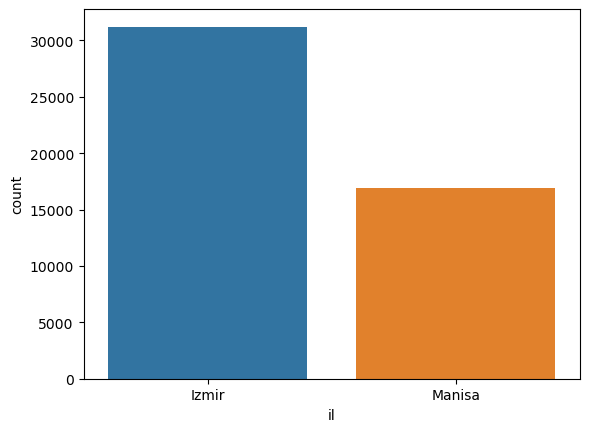

          mevsim      Ratio
Kış        12765  26.512005
Yaz        11949  24.817230
Sonbahar   11721  24.343690
İlkbahar   11713  24.327075


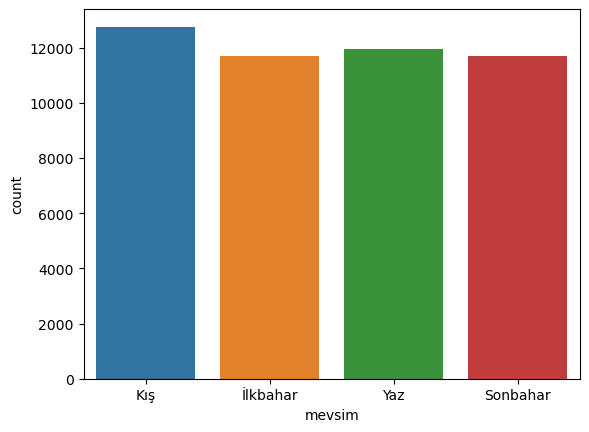

         ay_str      Ratio
Ocak       5307  11.022265
Temmuz     4023   8.355487
Ağustos    4009   8.326410
Mart       3976   8.257872
Ekim       3975   8.255795
Mayıs      3939   8.181025
Aralık     3937   8.176871
Haziran    3917   8.135333
Kasım      3898   8.095871
Eylül      3848   7.992025
Nisan      3798   7.888178
Şubat      3521   7.312869


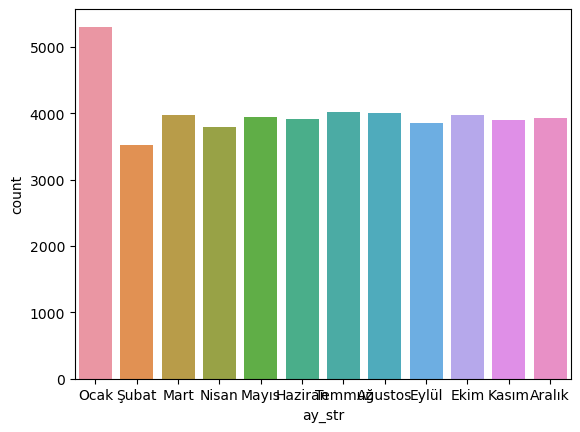

           hafta_gün_str      Ratio
Salı                6941  14.415967
Çarşamba            6925  14.382737
Pazartesi           6914  14.359890
Perşembe            6890  14.310044
Cumartesi           6875  14.278890
Cuma                6870  14.268505
Pazar               6733  13.983966


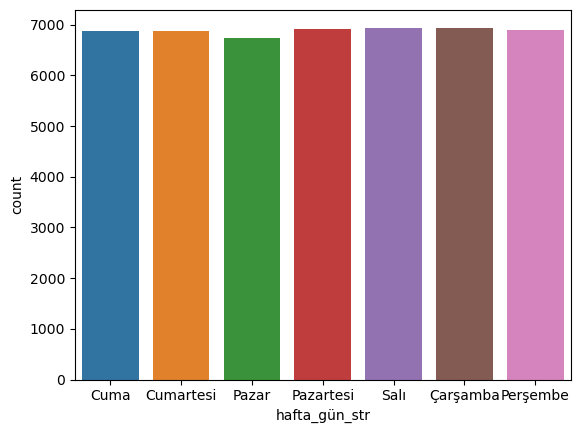

           kategorize_rüzgar_yon_mode      Ratio
Kuzey                           23649  49.117305
Kuzeydoğu                       10146  21.072526
Güneydoğu                        4700   9.761568
Doğu                             3632   7.543408
Güney                            2186   4.540168
Kuzeybatı                        1917   3.981474
Batı                             1038   2.155853
Güneybatı                         880   1.827698


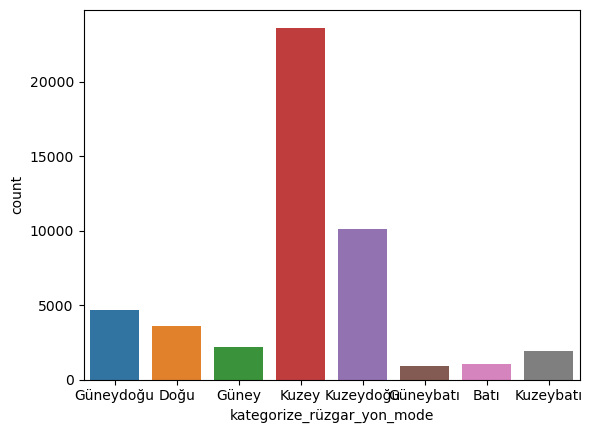

                                                    Tatil_Adı      Ratio
A_tatil_değil                                           46450  96.473374
Kurban Bayramı                                            487   1.011465
Ramazan Bayramı                                           318   0.660464
Yılbaşı                                                   154   0.319847
Demokrasi ve Millî Birlik Günü                            132   0.274155
Emek ve Dayanışma Günü                                    131   0.272078
Zafer Bayramı                                             127   0.263770
Atatürk'ü Anma, Gençlik ve Spor Bayramı                   122   0.253385
Cumhuriyet Bayramı                                        116   0.240924
Ulusal Egemenlik ve Çocuk Bayramı                          78   0.162000
Ramazan Bayramı; Ulusal Egemenlik ve Çocuk Bayramı         33   0.068539


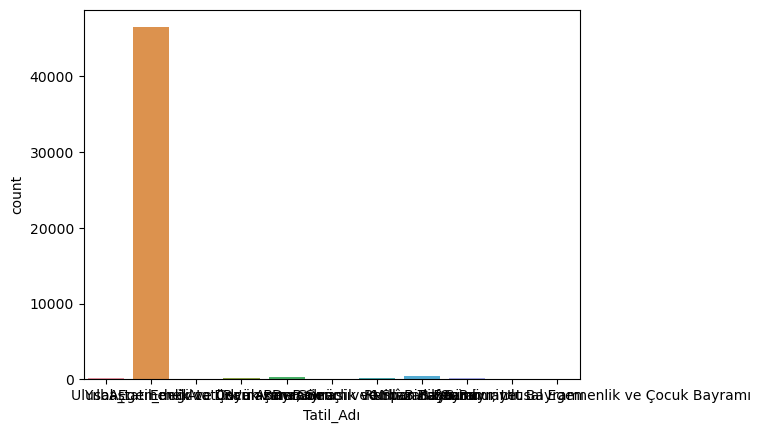

   planlı      Ratio
0   27952  58.054332
1   20196  41.945668


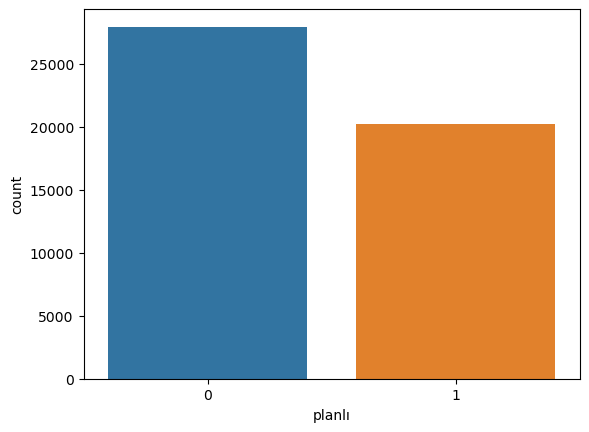

   il_encoded      Ratio
0       31218  64.837584
1       16930  35.162416


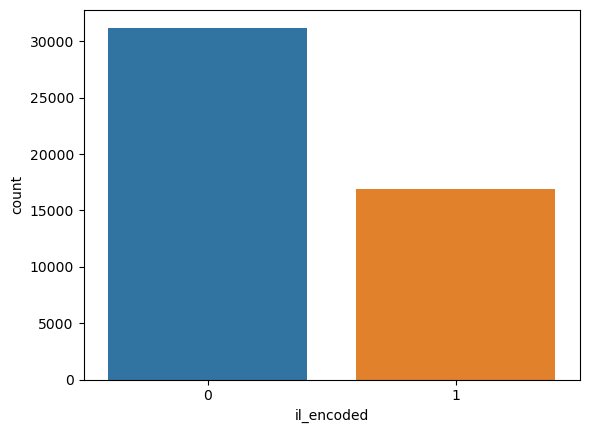

        yıl      Ratio
2021  15765  32.742793
2023  15627  32.456177
2022  15433  32.053252
2024   1323   2.747778


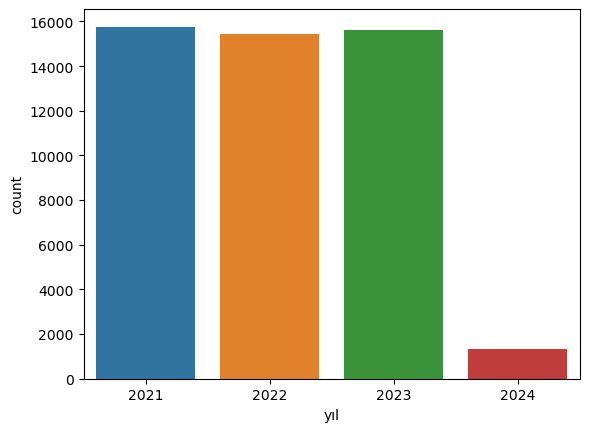

   mevsim_encoded      Ratio
4           12765  26.512005
2           11949  24.817230
3           11721  24.343690
1           11713  24.327075


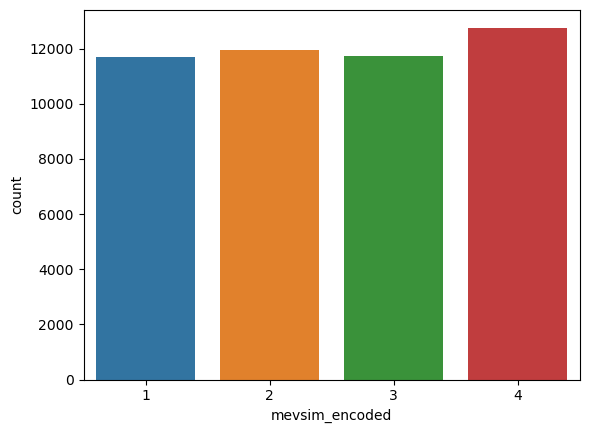

   hafta_gün      Ratio
2       6941  14.415967
3       6925  14.382737
1       6914  14.359890
4       6890  14.310044
6       6875  14.278890
5       6870  14.268505
7       6733  13.983966


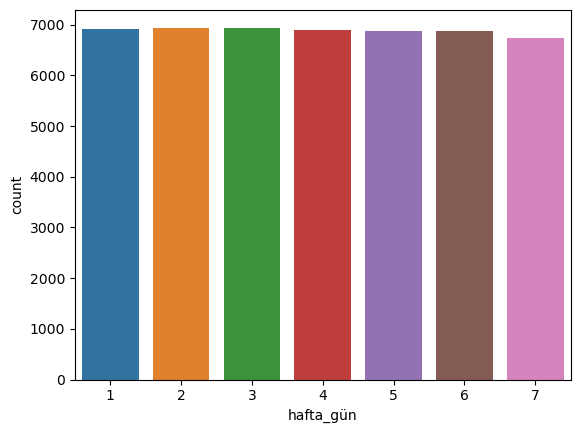

   haftaiçi      Ratio
1     34540  71.737144
0     13608  28.262856


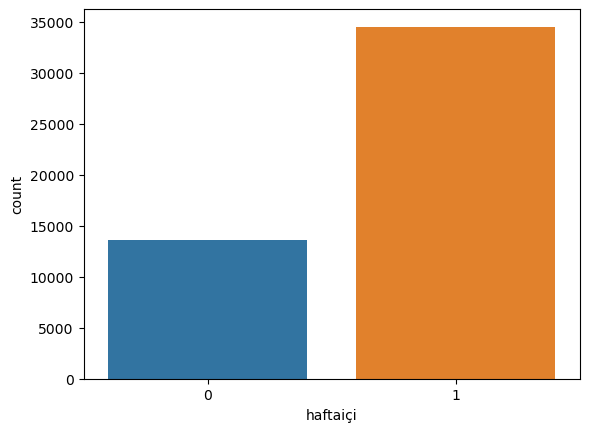

   haftasonu      Ratio
0      34540  71.737144
1      13608  28.262856


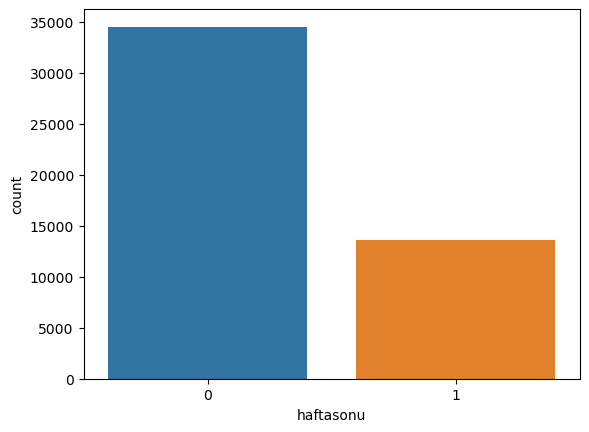

     güneslilik_min  Ratio
0.0           48148  100.0


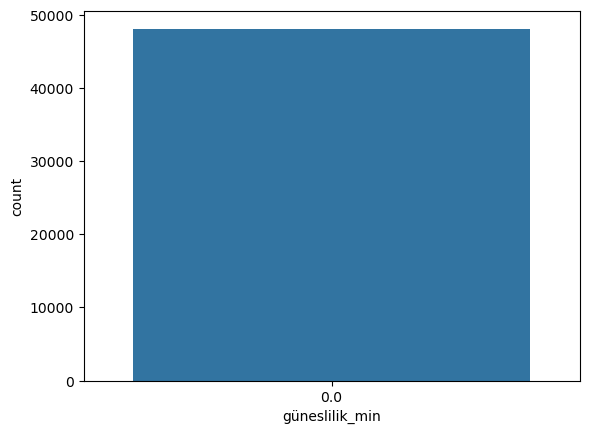

   kategorize_rüzgar_yon_mode_encoded      Ratio
5                               23649  49.117305
7                               10146  21.072526
4                                4700   9.761568
1                                3632   7.543408
2                                2186   4.540168
6                                1917   3.981474
0                                1038   2.155853
3                                 880   1.827698


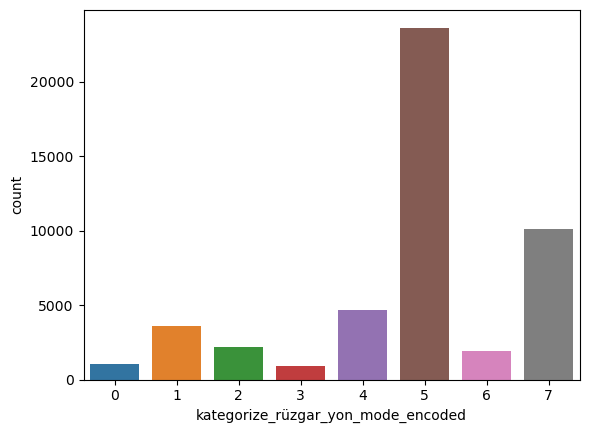

   Tatil_Durumu      Ratio
0         46450  96.473374
1          1698   3.526626


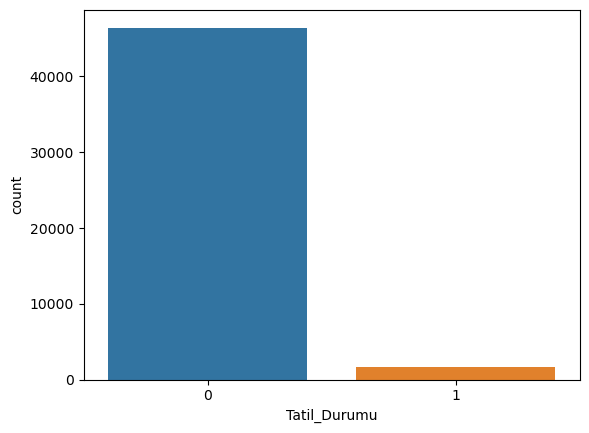

In [84]:
# Get a summary of a categorical column in a DataFrame and plot count plots for each column
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))

    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()


for col in cat_cols:
    cat_summary(df_train_EDA, col, plot=True)

count                   48148
unique                   1126
top       2021-05-01 00:00:00
freq                       47
first     2021-01-01 00:00:00
last      2024-01-31 00:00:00
Name: tarih, dtype: object


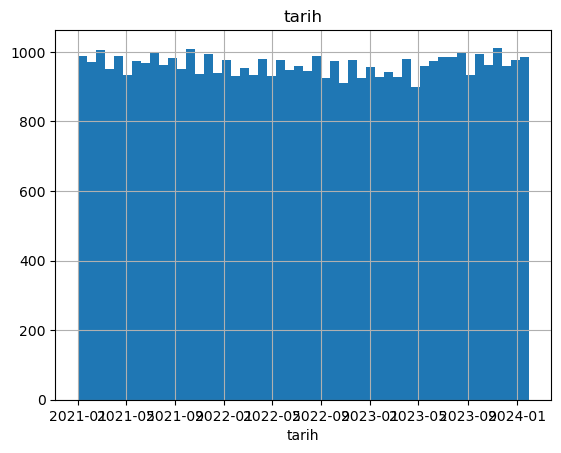

#####################################
count    48148.000000
mean         4.525629
std          8.236140
min          0.000000
5%           0.000000
10%          0.000000
20%          0.000000
30%          0.000000
40%          0.000000
50%          0.000000
60%          2.702703
70%          5.128205
80%          8.333333
90%         13.636364
95%         20.000000
99%         36.363636
max        100.000000
Name: ilce_yuzde, dtype: float64


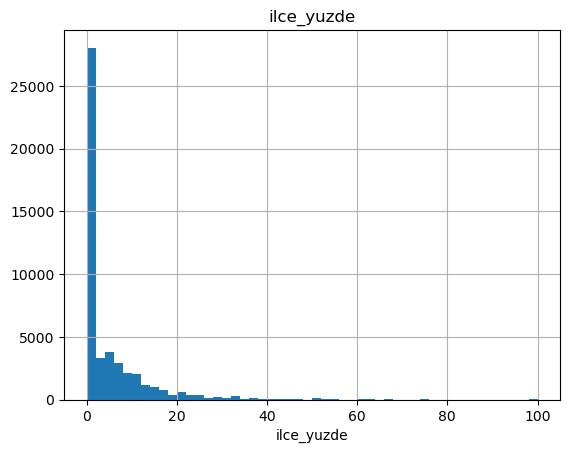

#####################################
count    48148.000000
mean        23.016532
std         13.605927
min          0.000000
5%           2.000000
10%          4.000000
20%          9.000000
30%         14.000000
40%         18.000000
50%         23.000000
60%         27.000000
70%         32.000000
80%         38.000000
90%         42.000000
95%         44.000000
99%         46.000000
max         46.000000
Name: ilce_encoded, dtype: float64


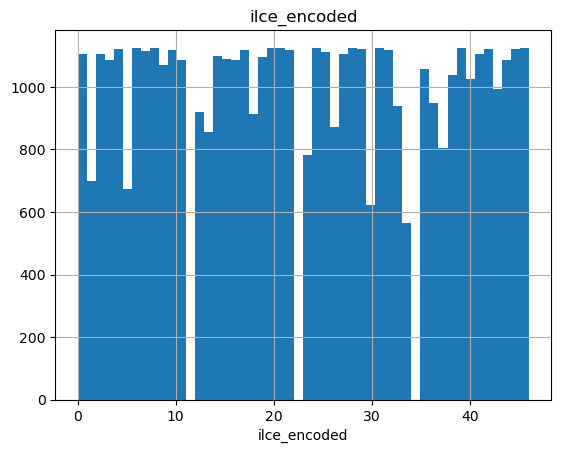

#####################################
count    48148.000000
mean         6.384543
std          3.513263
min          1.000000
5%           1.000000
10%          1.000000
20%          3.000000
30%          4.000000
40%          5.000000
50%          6.000000
60%          8.000000
70%          9.000000
80%         10.000000
90%         11.000000
95%         12.000000
99%         12.000000
max         12.000000
Name: ay, dtype: float64


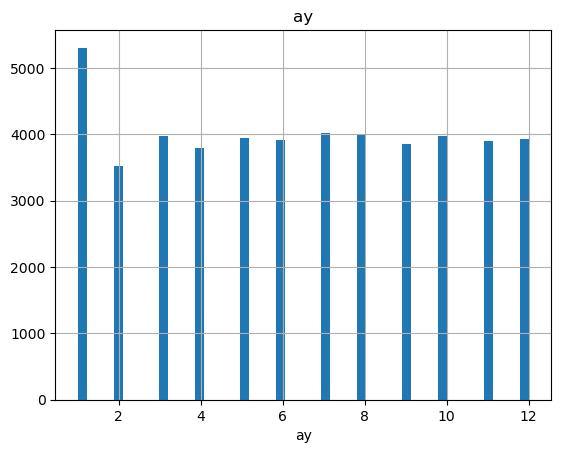

#####################################
count    48148.000000
mean        15.717538
std          8.793017
min          1.000000
5%           2.000000
10%          4.000000
20%          7.000000
30%         10.000000
40%         13.000000
50%         16.000000
60%         19.000000
70%         22.000000
80%         25.000000
90%         28.000000
95%         29.000000
99%         31.000000
max         31.000000
Name: gün, dtype: float64


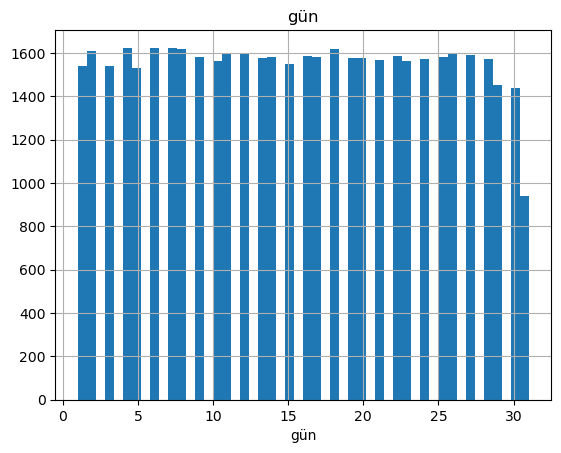

#####################################
count    48148.000000
mean        38.535126
std          0.301882
min         37.950800
5%          38.089500
10%         38.195200
20%         38.251700
30%         38.354500
40%         38.417700
50%         38.471000
60%         38.546600
70%         38.638300
80%         38.750300
90%         39.074900
95%         39.105400
99%         39.188100
max         39.188100
Name: lat, dtype: float64


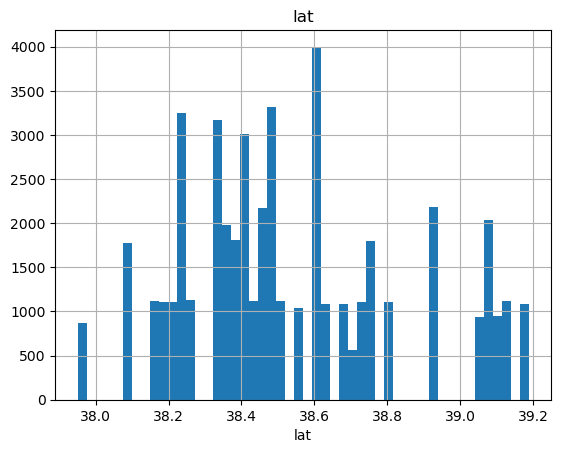

#####################################
count    48148.000000
mean        27.501433
std          0.624831
min         26.303200
5%          26.757900
10%         26.834400
20%         26.970700
30%         27.128300
40%         27.179900
50%         27.370000
60%         27.572900
70%         27.708400
80%         28.140100
90%         28.516500
95%         28.671200
99%         28.869300
max         28.869300
Name: lon, dtype: float64


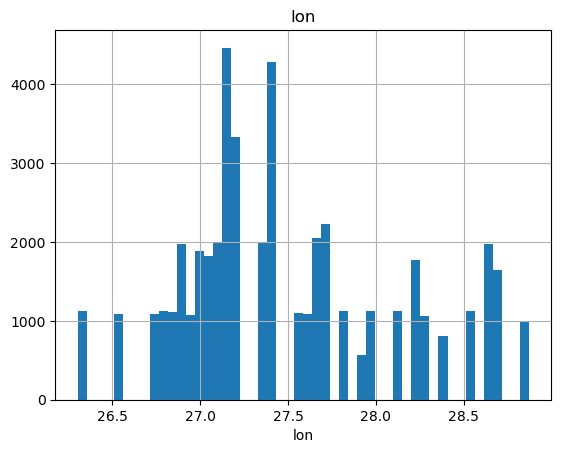

#####################################
count    48148.000000
mean        12.988049
std          7.244183
min        -12.600000
5%           0.700000
10%          3.100000
20%          6.400000
30%          8.800000
40%         10.900000
50%         13.100000
60%         15.300000
70%         17.800000
80%         20.300000
90%         22.600000
95%         23.800000
99%         25.900000
max         29.400000
Name: sıcaklık_min, dtype: float64


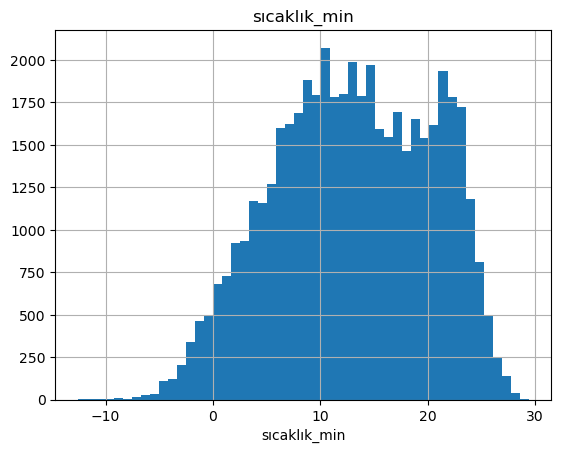

#####################################
count    48148.00000
mean        22.85038
std          8.92528
min         -2.70000
5%           8.90000
10%         11.40000
20%         14.70000
30%         17.00000
40%         19.30000
50%         22.30000
60%         25.50000
70%         28.70000
80%         31.80000
90%         35.10000
95%         37.10000
99%         40.50000
max         44.80000
Name: sıcaklık_max, dtype: float64


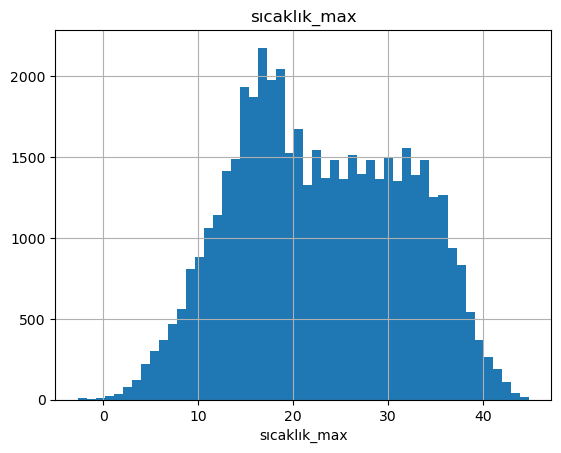

#####################################
count    48148.000000
mean        17.511951
std          8.006367
min         -7.975000
5%           4.530625
10%          6.995833
20%         10.229167
30%         12.471250
40%         14.712500
50%         17.133333
60%         19.787500
70%         22.825000
80%         25.858333
90%         28.291667
95%         29.879167
99%         32.485542
max         36.391667
Name: sıcaklık_mean, dtype: float64


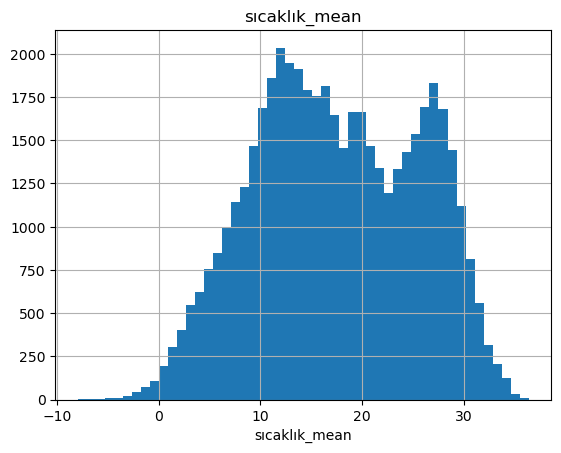

#####################################
count    48148.000000
mean         7.171122
std         16.227982
min          0.000000
5%           0.000000
10%          0.000000
20%          0.000000
30%          0.000000
40%          0.000000
50%          0.000000
60%          0.000000
70%          1.500000
80%          8.300000
90%         28.300000
95%         45.900000
99%         76.600000
max        100.000000
Name: bulutluluk_min, dtype: float64


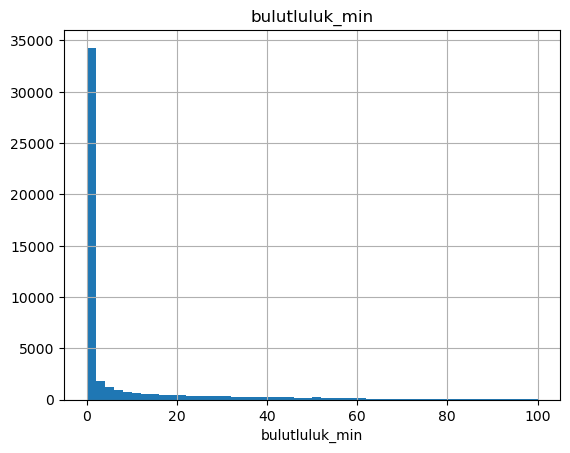

#####################################
count    48148.000000
mean        59.129839
std         37.565105
min          0.000000
5%           0.000000
10%          0.900000
20%         13.300000
30%         34.210000
40%         49.900000
50%         63.800000
60%         83.900000
70%         96.200000
80%         99.700000
90%        100.000000
95%        100.000000
99%        100.000000
max        100.000000
Name: bulutluluk_max, dtype: float64


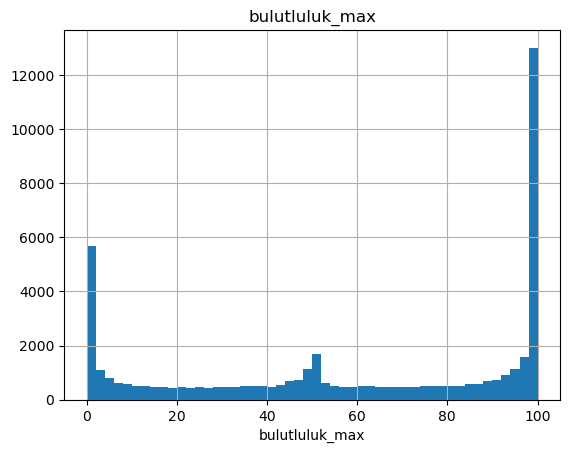

#####################################
count    48148.000000
mean        29.746246
std         28.454055
min          0.000000
5%           0.000000
10%          0.075000
20%          1.683333
30%          5.908333
40%         12.141667
50%         21.158333
60%         32.475833
70%         44.907917
80%         58.208333
90%         73.612500
95%         84.455417
99%         96.344125
max        100.000000
Name: bulutluluk_mean, dtype: float64


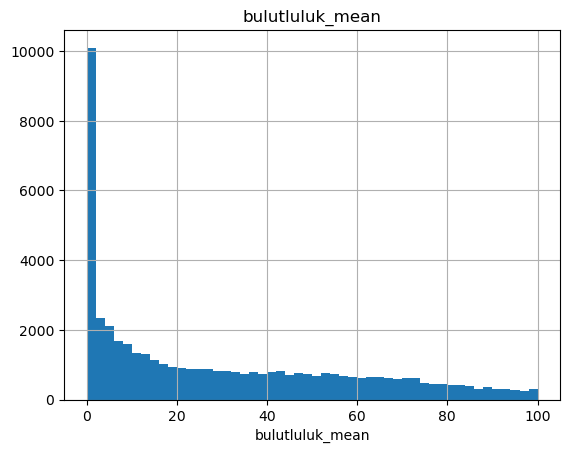

#####################################
count    48148.000000
mean       672.391015
std        224.999578
min         27.600000
5%         272.735000
10%        358.300000
20%        458.600000
30%        531.300000
40%        619.700000
50%        703.350000
60%        786.500000
70%        845.500000
80%        899.700000
90%        945.900000
95%        962.200000
99%        982.900000
max       1026.300000
Name: güneslilik_max, dtype: float64


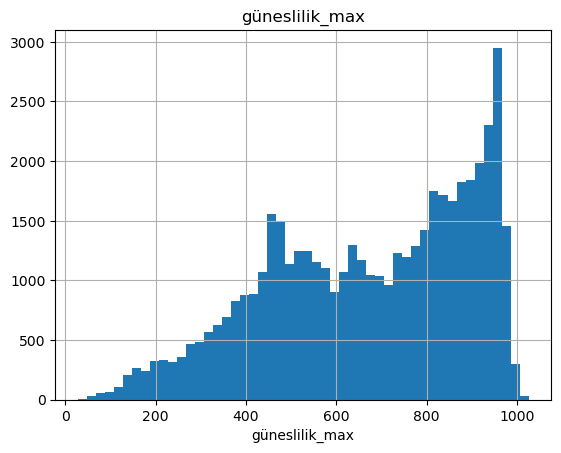

#####################################
count    48148.000000
mean       201.998697
std         91.534252
min          5.625000
5%          60.175000
10%         81.878750
20%        108.310000
30%        133.304583
40%        167.104167
50%        202.433333
60%        239.309167
70%        271.232917
80%        300.654167
90%        325.910833
95%        335.800000
99%        345.756375
max        365.991667
Name: güneslilik_mean, dtype: float64


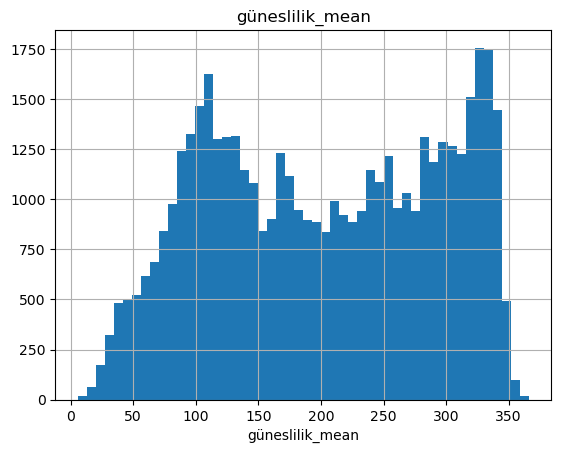

#####################################
count    48148.000000
mean        42.428792
std         16.414522
min          5.600000
5%          17.300000
10%         20.800000
20%         26.700000
30%         31.900000
40%         37.100000
50%         41.900000
60%         46.700000
70%         51.600000
80%         57.600000
90%         64.600000
95%         70.000000
99%         79.800000
max         92.900000
Name: nem_min, dtype: float64


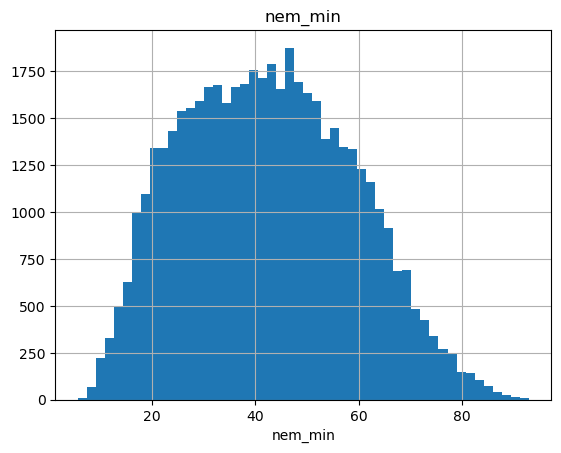

#####################################
count    48148.000000
mean        83.263490
std         12.341862
min         30.300000
5%          60.300000
10%         65.900000
20%         72.700000
30%         77.500000
40%         81.600000
50%         85.400000
60%         88.900000
70%         91.800000
80%         94.600000
90%         97.800000
95%        100.000000
99%        100.000000
max        100.000000
Name: nem_max, dtype: float64


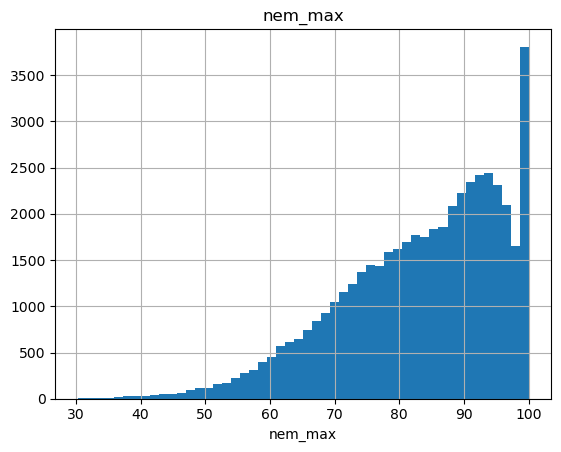

#####################################
count    48148.000000
mean        63.693764
std         14.744847
min         18.279167
5%          38.145833
10%         43.219583
20%         50.160000
30%         55.566667
40%         60.341667
50%         64.637500
60%         68.816667
70%         73.216667
80%         77.720833
90%         82.520833
95%         85.761042
99%         90.573042
max         97.458333
Name: nem_mean, dtype: float64


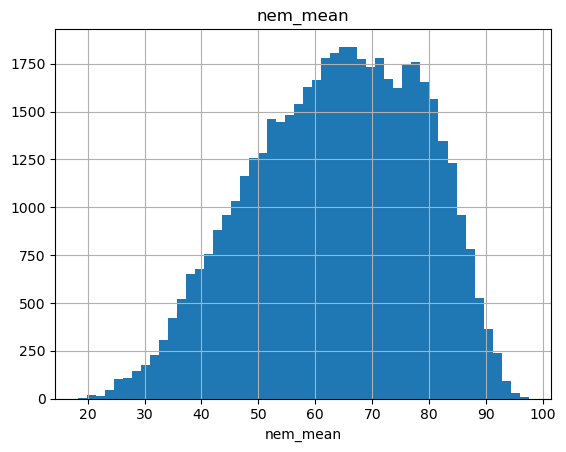

#####################################
count    48148.000000
mean        73.306158
std         96.010008
min          0.000000
5%           0.700000
10%          1.500000
20%          4.200000
30%          8.700000
40%         16.200000
50%         27.600000
60%         46.400000
70%         83.700000
80%        136.800000
90%        231.100000
95%        316.400000
99%        354.100000
max        360.000000
Name: rüzgar_yon_mode, dtype: float64


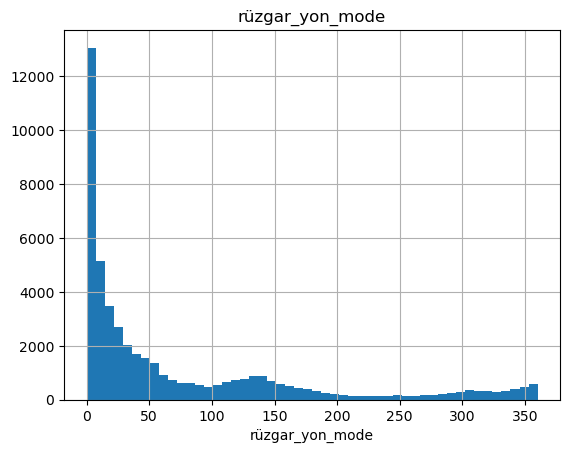

#####################################
count    48148.000000
mean         1.325515
std          1.399913
min          0.000000
5%           0.100000
10%          0.200000
20%          0.300000
30%          0.400000
40%          0.600000
50%          0.800000
60%          1.100000
70%          1.600000
80%          2.100000
90%          3.100000
95%          4.200000
99%          6.700000
max         13.300000
Name: rüzgar_hızı_min, dtype: float64


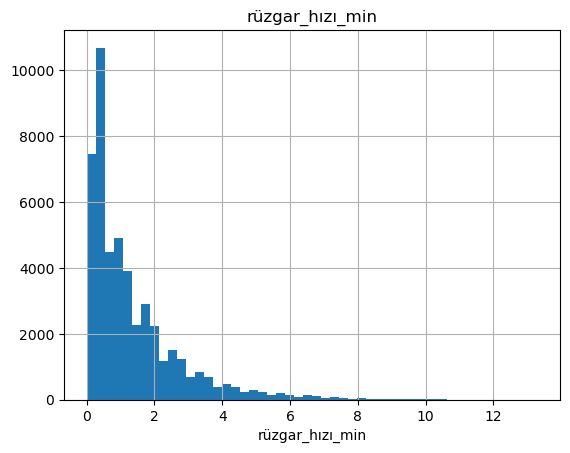

#####################################
count    48148.000000
mean         4.513714
std          2.001840
min          0.700000
5%           1.800000
10%          2.200000
20%          2.800000
30%          3.300000
40%          3.800000
50%          4.300000
60%          4.700000
70%          5.300000
80%          6.000000
90%          7.100000
95%          8.200000
99%         10.700000
max         18.400000
Name: rüzgar_hızı_max, dtype: float64


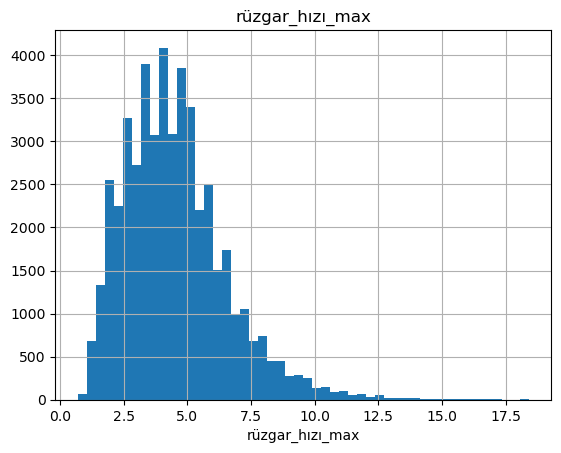

#####################################
count    48148.000000
mean         2.760105
std          1.645427
min          0.400000
5%           1.004167
10%          1.179167
20%          1.454167
30%          1.704167
40%          1.979167
50%          2.304167
60%          2.695833
70%          3.204167
80%          3.862500
90%          4.937500
95%          6.020833
99%          8.402208
max         14.487500
Name: rüzgar_hızı_mean, dtype: float64


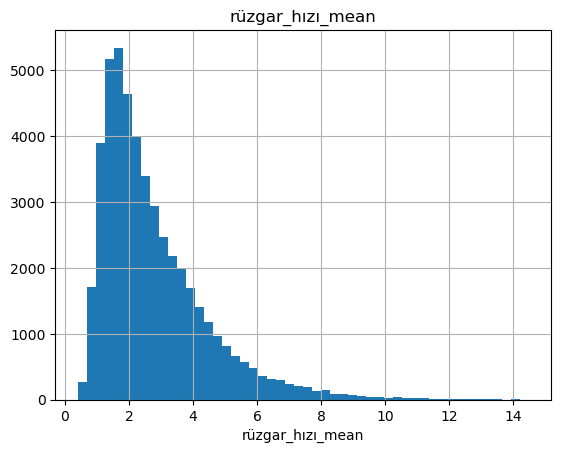

#####################################
count    48148.000000
mean         1.071912
std          2.565270
min          1.000000
5%           1.000000
10%          1.000000
20%          1.000000
30%          1.000000
40%          1.000000
50%          1.000000
60%          1.000000
70%          1.000000
80%          1.000000
90%          1.000000
95%          1.000000
99%          1.000000
max         95.000000
Name: yagıs_mode, dtype: float64


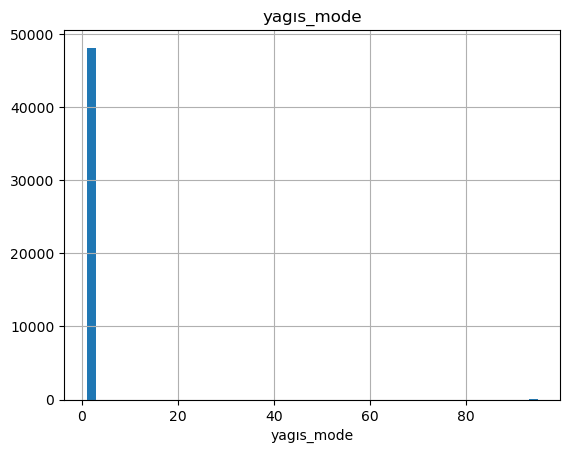

#####################################
count    48148.000000
mean        12.744556
std          8.313088
min        -17.800000
5%          -1.700000
10%          1.100000
20%          5.040000
30%          7.900000
40%         10.900000
50%         13.200000
60%         15.600000
70%         18.400000
80%         21.000000
90%         23.500000
95%         24.800000
99%         26.700000
max         29.300000
Name: his_sıcaklık_min, dtype: float64


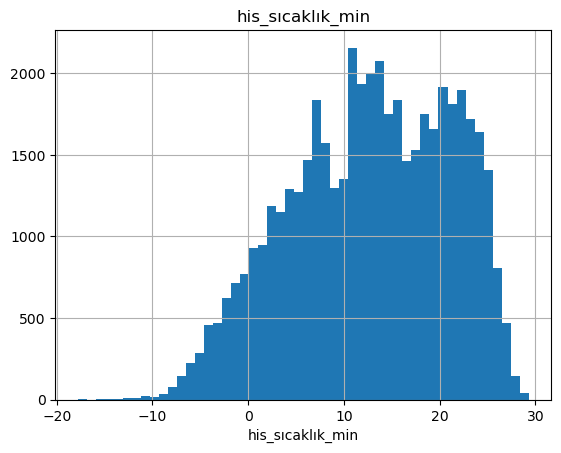

#####################################
count    48148.000000
mean        27.318667
std         10.299334
min         -5.300000
5%          11.300000
10%         14.900000
20%         18.100000
30%         20.400000
40%         23.000000
50%         26.500000
60%         30.200000
70%         34.300000
80%         38.000000
90%         41.400000
95%         43.500000
99%         46.900000
max         52.000000
Name: his_sıcaklık_max, dtype: float64


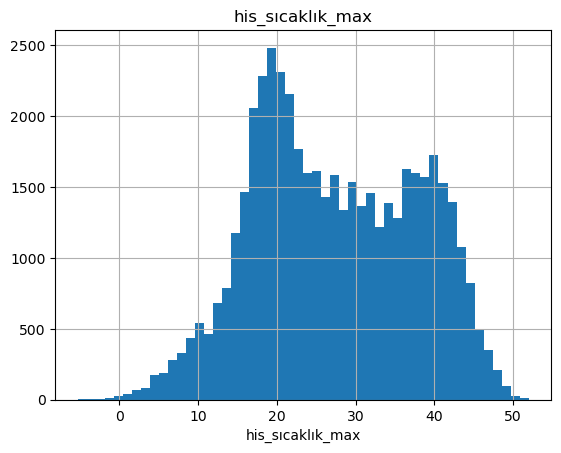

#####################################
count    48148.000000
mean        18.714698
std          8.944494
min        -10.212500
5%           3.829167
10%          6.869583
20%         10.787500
30%         13.379167
40%         15.679167
50%         18.337500
60%         21.387500
70%         24.879167
80%         28.066667
90%         30.658333
95%         32.158333
99%         34.539708
max         37.670833
Name: his_sıcaklık_mean, dtype: float64


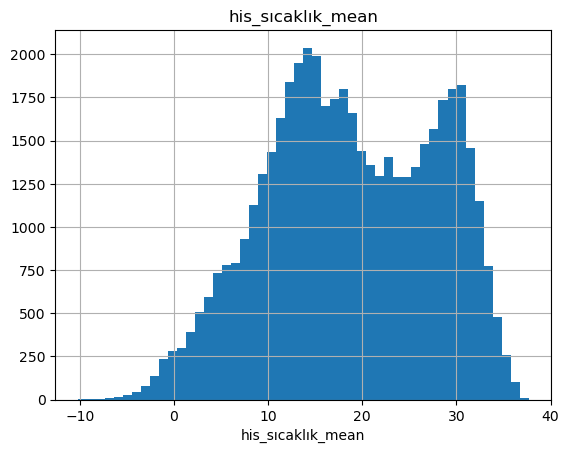

#####################################
count    48148.000000
mean         9.862331
std          3.476214
min          1.100000
5%           4.400000
10%          5.400000
20%          6.700000
30%          7.700000
40%          8.700000
50%          9.800000
60%         10.800000
70%         11.900000
80%         13.100000
90%         14.600000
95%         15.700000
99%         17.500000
max         22.100000
Name: sıcaklık_range, dtype: float64


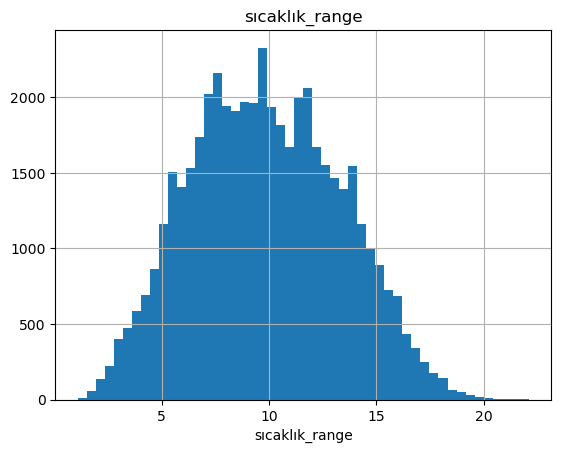

#####################################
count    48148.000000
mean        51.958717
std         33.650030
min          0.000000
5%           0.000000
10%          0.900000
20%         12.400000
30%         30.900000
40%         45.400000
50%         52.500000
60%         64.900000
70%         77.100000
80%         88.400000
90%         96.900000
95%         99.400000
99%        100.000000
max        100.000000
Name: bulutluluk_range, dtype: float64


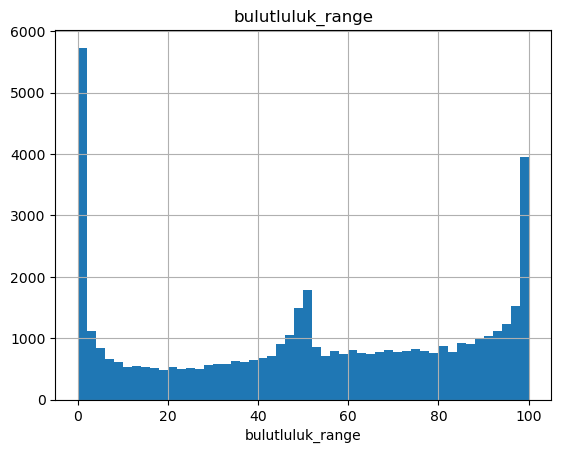

#####################################
count    48148.000000
mean       672.391015
std        224.999578
min         27.600000
5%         272.735000
10%        358.300000
20%        458.600000
30%        531.300000
40%        619.700000
50%        703.350000
60%        786.500000
70%        845.500000
80%        899.700000
90%        945.900000
95%        962.200000
99%        982.900000
max       1026.300000
Name: güneslilik_range, dtype: float64


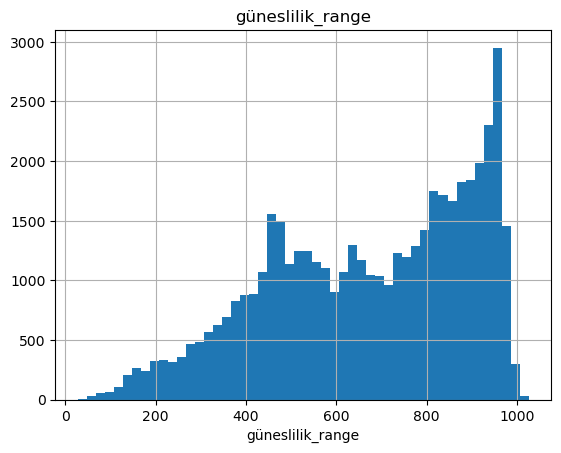

#####################################
count    48148.000000
mean        40.834697
std         12.306369
min          3.900000
5%          20.700000
10%         25.100000
20%         30.500000
30%         34.200000
40%         37.500000
50%         40.600000
60%         43.800000
70%         47.300000
80%         51.300000
90%         56.830000
95%         61.400000
99%         69.853000
max         86.800000
Name: nem_range, dtype: float64


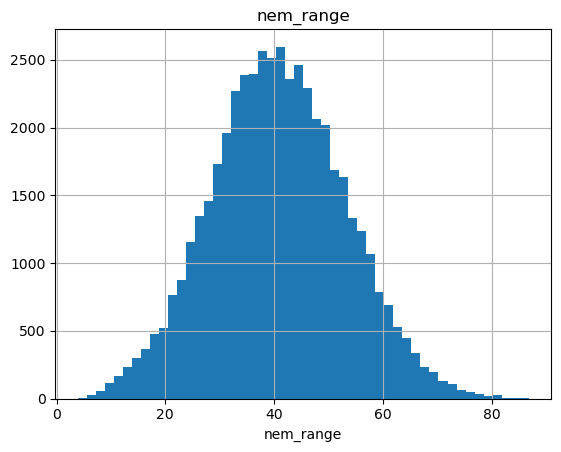

#####################################
count    48148.000000
mean         3.188199
std          1.354030
min          0.500000
5%           1.300000
10%          1.600000
20%          2.000000
30%          2.400000
40%          2.700000
50%          3.000000
60%          3.400000
70%          3.700000
80%          4.200000
90%          4.900000
95%          5.500000
99%          7.400000
max         15.500000
Name: rüzgar_hızı_range, dtype: float64


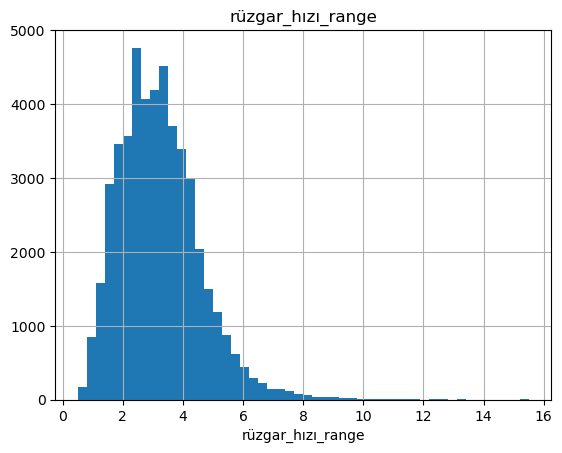

#####################################
count    48148.000000
mean        14.574111
std          4.218278
min          1.400000
5%           7.300000
10%          8.900000
20%         11.000000
30%         12.400000
40%         13.600000
50%         14.700000
60%         15.800000
70%         16.900000
80%         18.300000
90%         20.000000
95%         21.300000
99%         23.400000
max         28.800000
Name: his_sıcaklık_range, dtype: float64


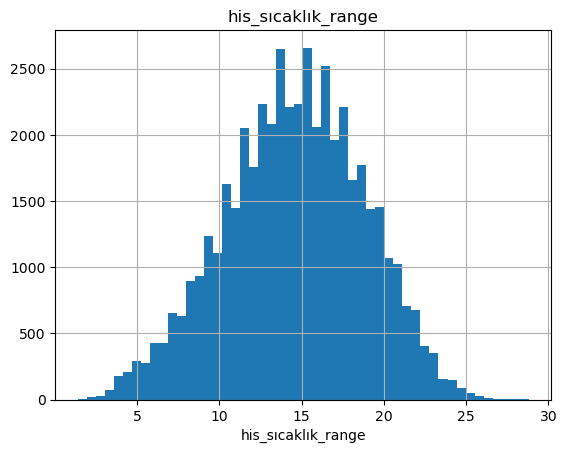

#####################################
count    48148.000000
mean         0.189582
std          1.093254
min          0.000000
5%           0.000000
10%          0.000000
20%          0.000000
30%          0.000000
40%          0.000000
50%          0.000000
60%          0.000000
70%          0.000000
80%          0.000000
90%          0.000000
95%          0.000000
99%          6.000000
max         10.000000
Name: Tatil_Adı_encoded, dtype: float64


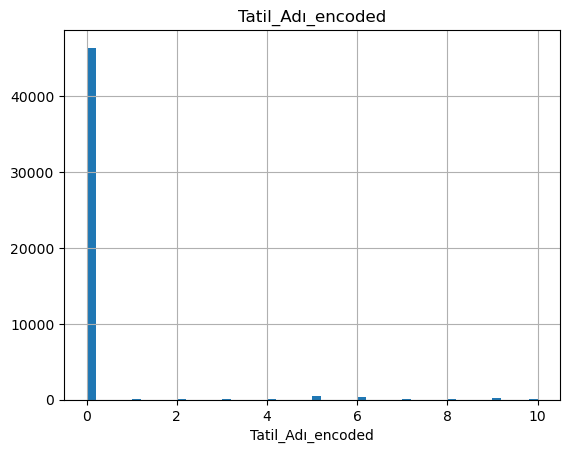

#####################################
count    48148.000000
mean         0.798849
std          1.315394
min          0.000000
5%           0.000000
10%          0.000000
20%          0.000000
30%          0.000000
40%          0.000000
50%          0.000000
60%          1.000000
70%          1.000000
80%          1.000000
90%          2.000000
95%          3.000000
99%          6.000000
max         19.000000
Name: bildirimli_sum, dtype: float64


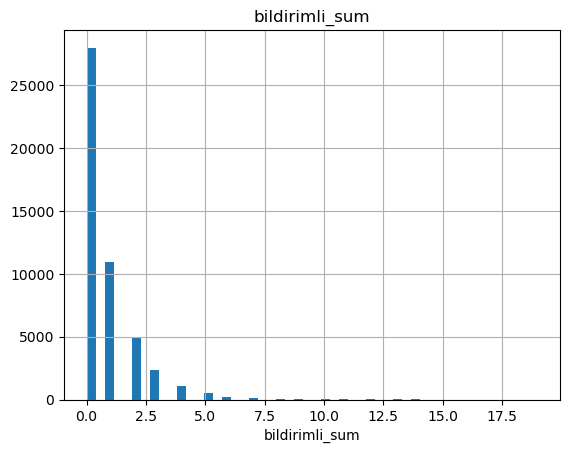

#####################################
count    48148.000000
mean         5.886911
std          5.425645
min          0.000000
5%           1.000000
10%          1.000000
20%          2.000000
30%          3.000000
40%          4.000000
50%          4.000000
60%          6.000000
70%          7.000000
80%          9.000000
90%         12.000000
95%         16.000000
99%         26.000000
max         93.000000
Name: bildirimsiz_sum, dtype: float64


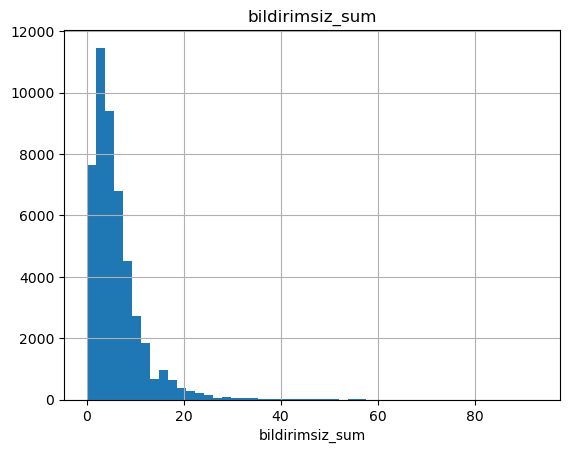

#####################################


In [86]:
# Get a summary of a numerical column in a DataFrame and plot histograms for each column
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=50)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()

    print("#####################################")


for col in num_cols:
    num_summary(df_train_EDA, col, True)

In [90]:
# Get a summary of the mean target variable grouped by a categorical column
def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")


for col in cat_cols:
    target_summary_with_cat(df_train_EDA,"bildirimsiz_sum",col)

        TARGET_MEAN
il                 
Izmir      6.194215
Manisa     5.320260


          TARGET_MEAN
mevsim               
Kış          6.040501
Sonbahar     5.813924
Yaz          6.249895
İlkbahar     5.422266


         TARGET_MEAN
ay_str              
Aralık      5.636779
Ağustos     5.500374
Ekim        5.360252
Eylül       4.914241
Haziran     6.573909
Kasım       7.164700
Mart        5.438129
Mayıs       5.566134
Nisan       5.256451
Ocak        6.449783
Temmuz      6.681332
Şubat       5.875036


               TARGET_MEAN
hafta_gün_str             
Cuma              5.955022
Cumartesi         5.876509
Pazar             5.609238
Pazartesi         6.015476
Perşembe          5.738897
Salı              5.942227
Çarşamba          6.063105


                            TARGET_MEAN
kategorize_rüzgar_yon_mode             
Batı                           5.082852
Doğu                           5.416575
Güney                          7.234675
Güneybatı                      6.600000
Gün

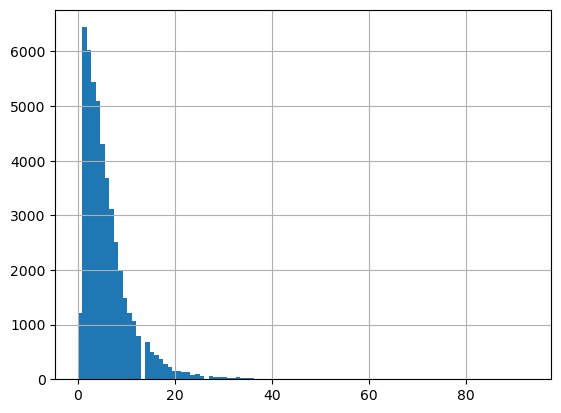

In [93]:
# Exploring the dependent variable
df_train_EDA["bildirimsiz_sum"].hist(bins=100)
plt.show()

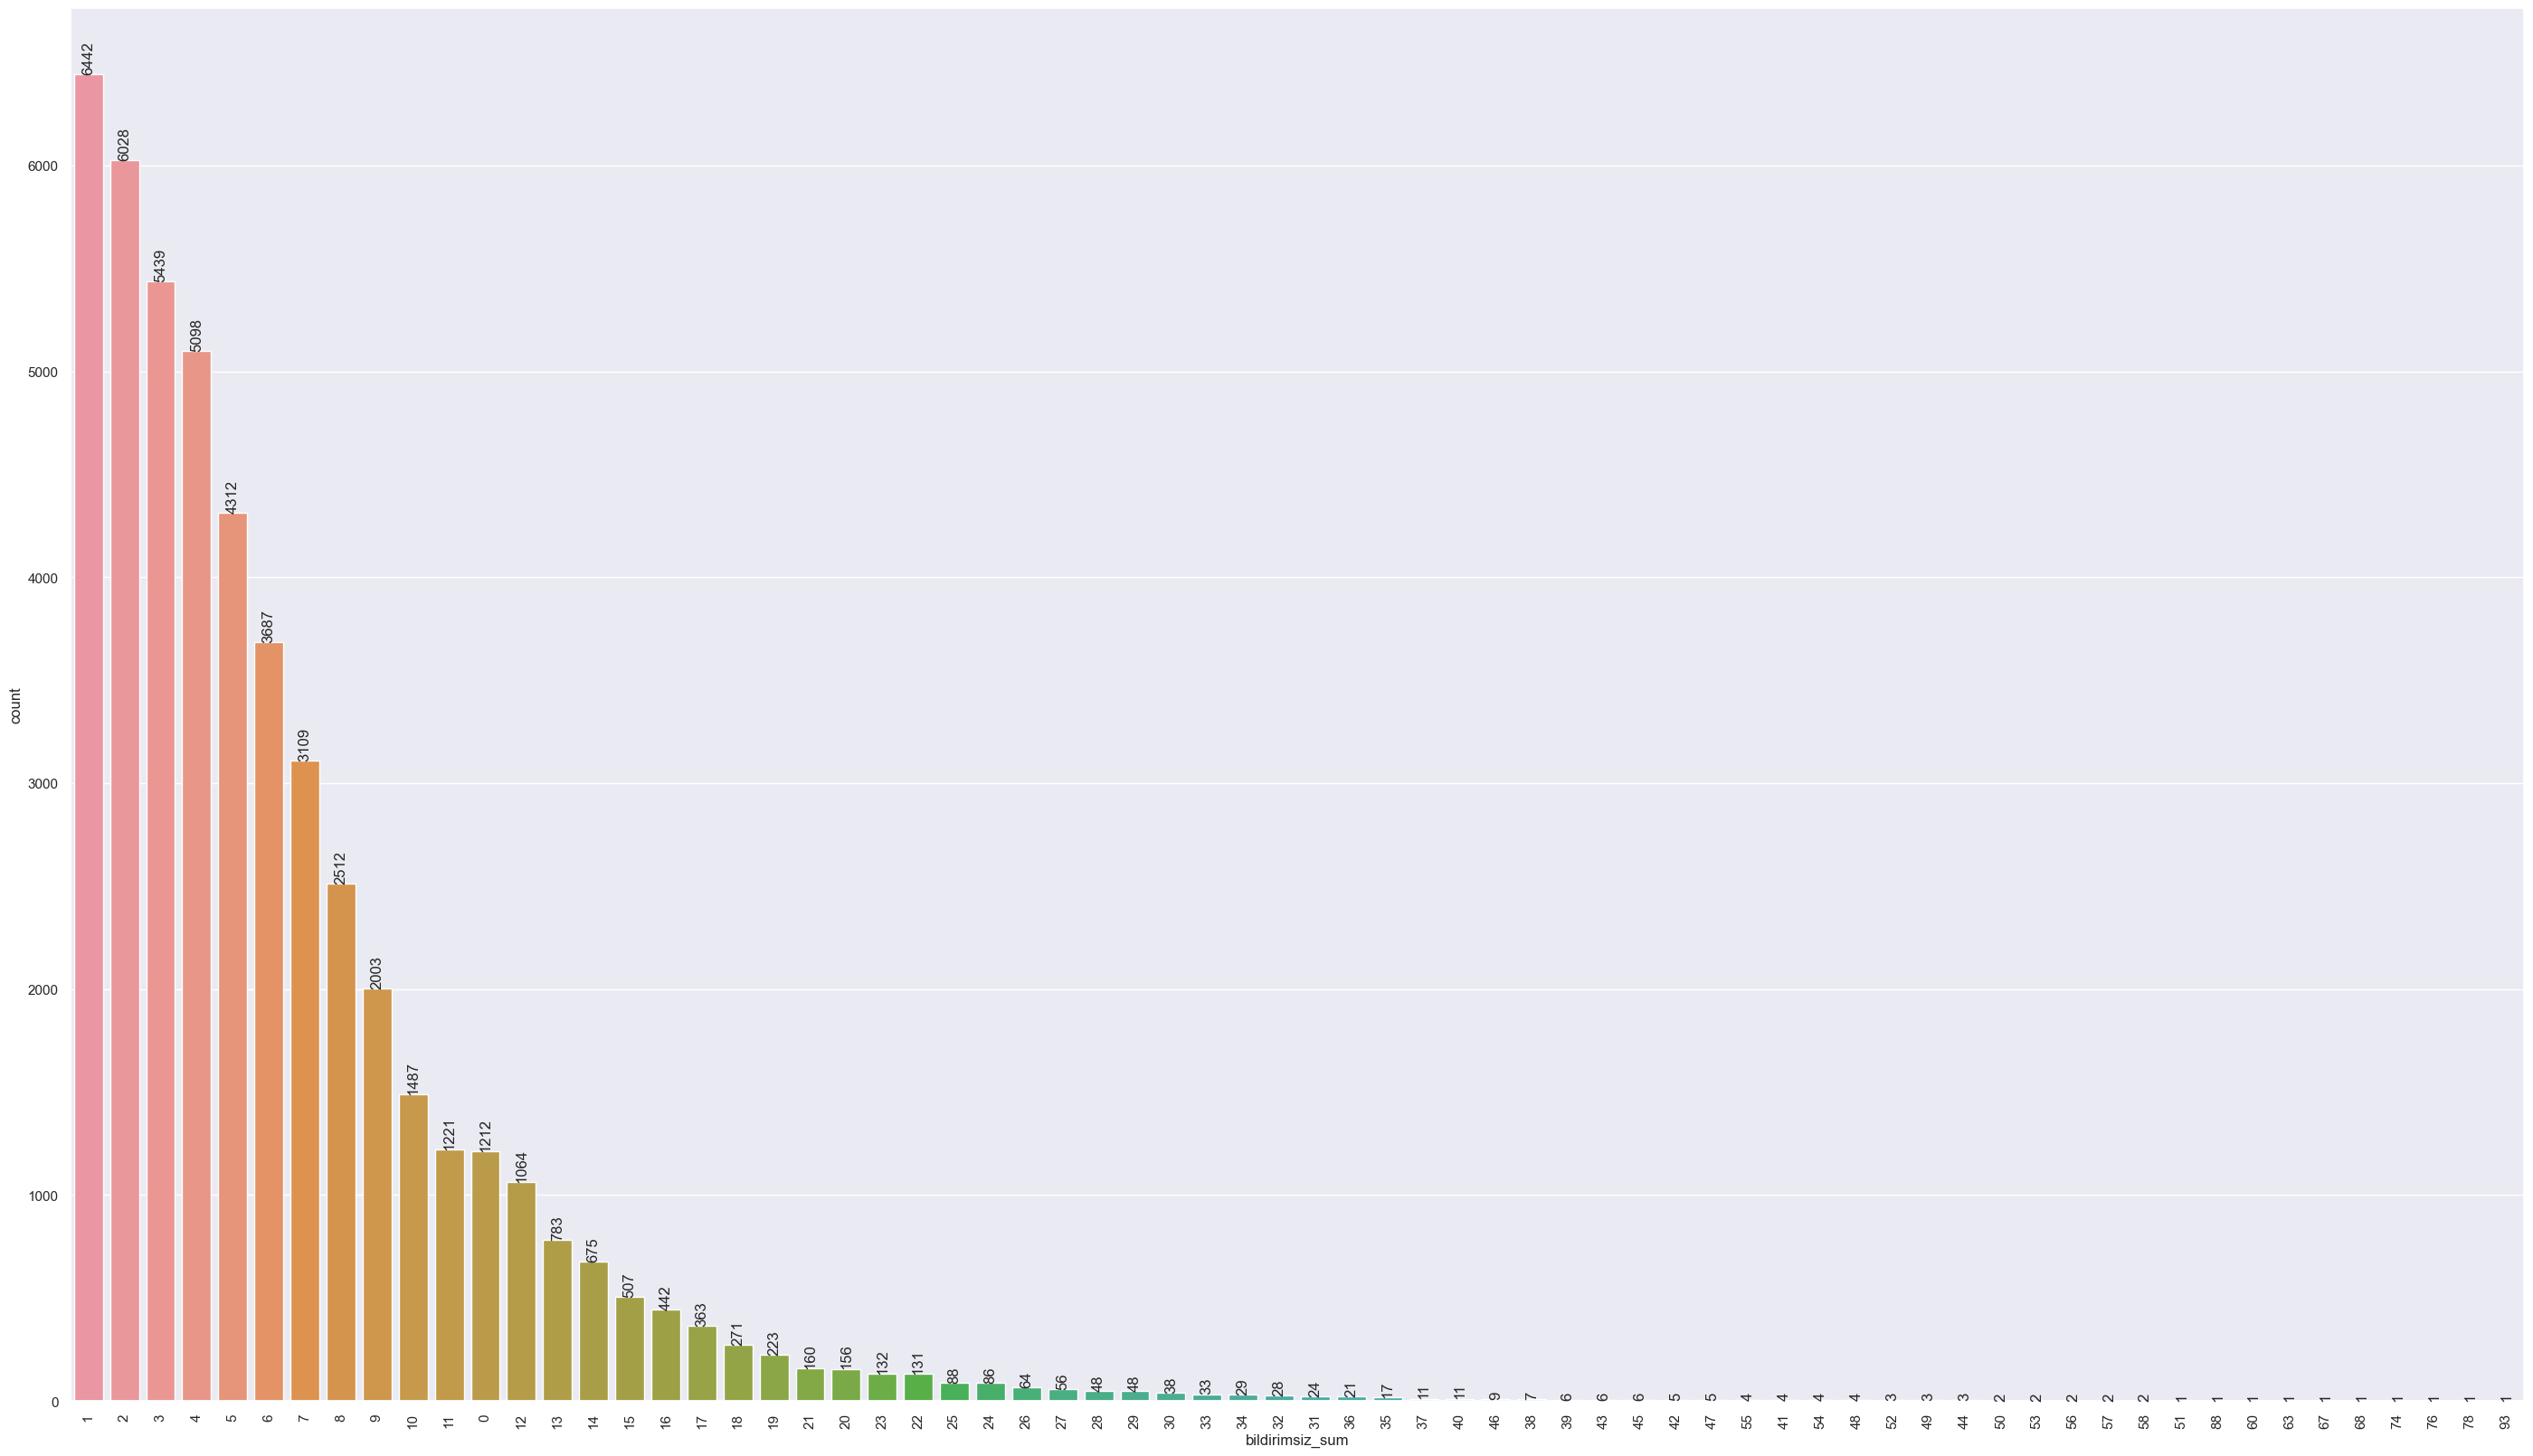

In [123]:
# Visualize the distribution of the dependent variable "bildirimsiz_sum" by counting the occurrences of each unique value and sorting them from largest to smallest
large_to_small = df_train_EDA.groupby('bildirimsiz_sum').size().sort_values().index[::-1]
ax = sns.countplot(data=df_train_EDA, x="bildirimsiz_sum", order=large_to_small)

plt.xticks(rotation = 90)

for container in ax.containers:
    ax.bar_label(container, rotation = 90);

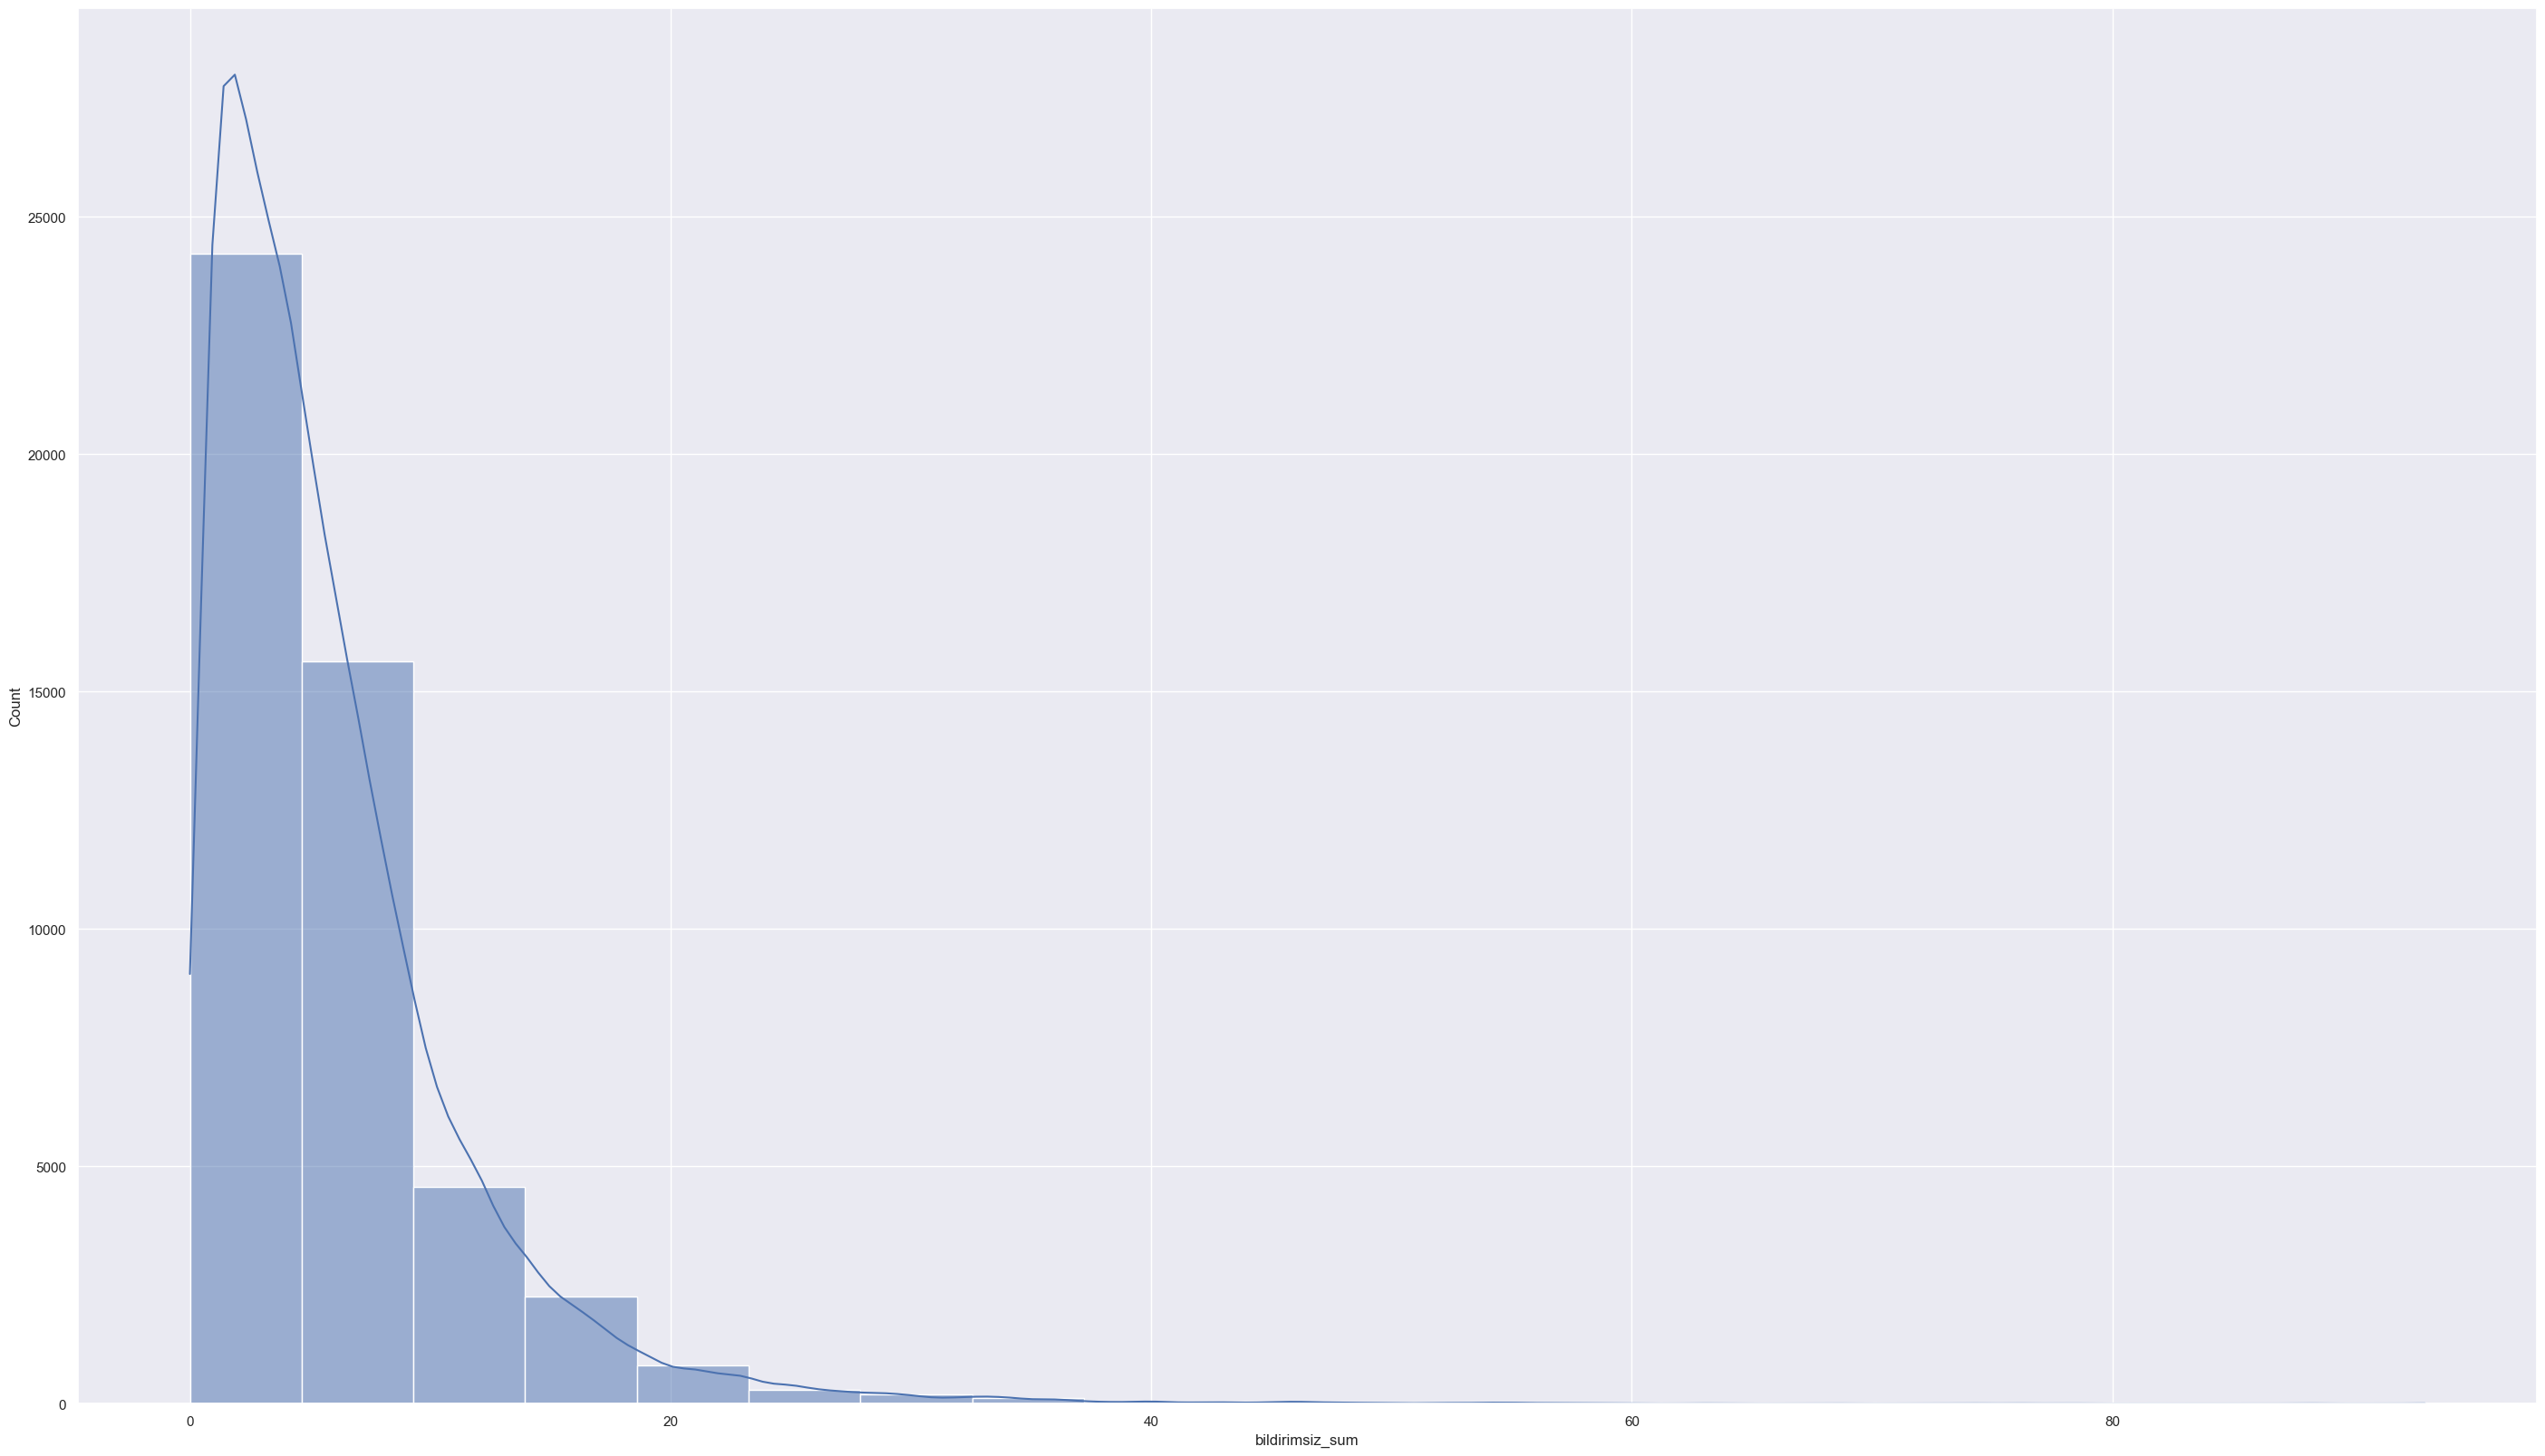

In [125]:
# Checking the histplot/kdeplot to see distribution of feature
sns.histplot(data=df_train_EDA, x="bildirimsiz_sum", bins=20, kde=True);

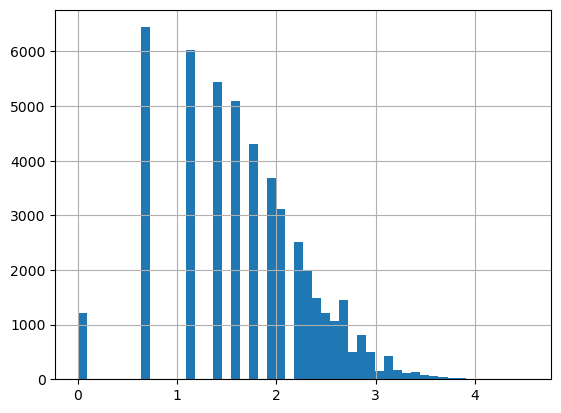

In [96]:
#Exploring the logarithm of the dependent variable
np.log1p(df_train_EDA['bildirimsiz_sum']).hist(bins=50)
plt.show()

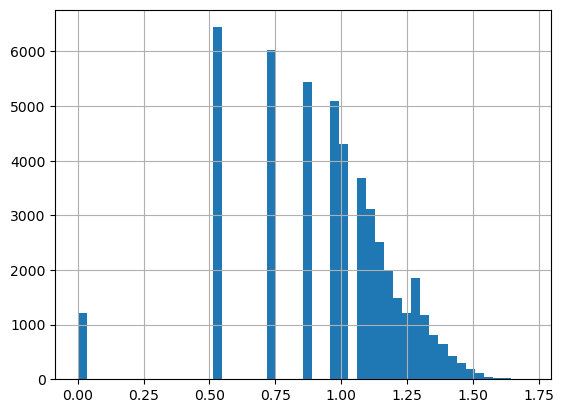

In [101]:
# Exploring the double logarithm (log-log) of the dependent variable
np.log1p(np.log1p(df_train_EDA['bildirimsiz_sum'])).hist(bins=50)
plt.show()

In [104]:
# Calculate the correlation matrix (corr) from the numerical columns (num_cols)
corr = df_train_EDA[num_cols].corr()
corr

ilce_yuzde  ilce_encoded        ay       gün       lat  \
ilce_yuzde            1.000000      0.161642 -0.000425 -0.000388  0.042146   
ilce_encoded          0.161642      1.000000  0.003821 -0.000643  0.179954   
ay                   -0.000425      0.003821  1.000000  0.010273  0.001782   
gün                  -0.000388     -0.000643  0.010273  1.000000 -0.002163   
lat                   0.042146      0.179954  0.001782 -0.002163  1.000000   
lon                   0.075284      0.576300  0.006604 -0.001767  0.089434   
sıcaklık_min         -0.026662     -0.126286  0.383021 -0.019610 -0.109879   
sıcaklık_max          0.004618      0.009394  0.351227  0.002381 -0.073169   
sıcaklık_mean        -0.011328     -0.055069  0.365270 -0.005466 -0.092943   
bulutluluk_min        0.003969      0.016814 -0.103495 -0.031572  0.039621   
bulutluluk_max        0.013026      0.046817 -0.206522 -0.040623  0.072355   
bulutluluk_mean       0.008866      0.035830 -0.189776 -0.054601  0.062164   
güneslilik_max       -0.010932     -0.007489 -0.005990  0.024735 -0.028066   
güneslilik_mean      -0.012423     -0.010905 -0.008191  0.026320 -0.024527   
nem_min              -0.037297     -0.149021 -0.129150 -0.045107  0.056445   
nem_max              -0.013089      0.027799 -0.068388 -0.025219  0.148867   
nem_mean             -0.024743     -0.073715 -0.111502 -0.040992  0.107968   
rüzgar_yon_mode      -0.012433     -0.011825  0.007228  0.004867 -0.104861   
rüzgar_hızı_min      -0.062352     -0.262322 -0.023807 -0.059491 -0.001553   
rüzgar_hızı_max      -0.070542     -0.277839 -0.059141 -0.035032  0.011703   
rüzgar_hızı_mean     -0.074203     -0.304288 -0.052432 -0.048007  0.011303   
yagıs_mode           -0.001608      0.006256 -0.037579 -0.022818  0.003807   
his_sıcaklık_min     -0.022074     -0.099691  0.396071 -0.017738 -0.103155   
his_sıcaklık_max     -0.003085     -0.014361  0.298029  0.005512 -0.070798   
his_sıcaklık_mean    -0.012205     -0.053495  0.352525 -0.002619 -0.088613   
sıcaklık_range        0.067417      0.287289  0.103596  0.046981  0.041115   
bulutluluk_range      0.012627      0.044156 -0.180639 -0.030123  0.061666   
güneslilik_range     -0.010932     -0.007489 -0.005990  0.024735 -0.028066   
nem_range             0.036620      0.226647  0.103678  0.034873  0.074009   
rüzgar_hızı_range    -0.039826     -0.139554 -0.062823  0.009714  0.018908   
his_sıcaklık_range    0.035971      0.161400 -0.052884  0.048417  0.030430   
Tatil_Adı_encoded    -0.024012      0.004545 -0.051145 -0.007669  0.005403   
bildirimli_sum        0.736763     -0.011960  0.022451  0.019358 -0.046439   
bildirimsiz_sum       0.089105     -0.003790 -0.004220 -0.002013 -0.109481   

                         lon  sıcaklık_min  sıcaklık_max  sıcaklık_mean  \
ilce_yuzde          0.075284     -0.026662      0.004618      -0.011328   
ilce_encoded        0.576300     -0.126286      0.009394      -0.055069   
ay                  0.006604      0.383021      0.351227       0.365270   
gün                -0.001767     -0.019610      0.002381      -0.005466   
lat                 0.089434     -0.109879     -0.073169      -0.092943   
lon                 1.000000     -0.174021      0.006559      -0.075638   
sıcaklık_min       -0.174021      1.000000      0.928406       0.977379   
sıcaklık_max        0.006559      0.928406      1.000000       0.983115   
sıcaklık_mean      -0.075638      0.977379      0.983115       1.000000   
bulutluluk_min      0.026072     -0.212063     -0.342942      -0.283998   
bulutluluk_max      0.058804     -0.450572     -0.570176      -0.522405   
bulutluluk_mean     0.046917     -0.406255     -0.560087      -0.494370   
güneslilik_max     -0.002883      0.595359      0.726997       0.681848   
güneslilik_mean    -0.005720      0.646887      0.760014       0.727675   
nem_min            -0.247238     -0.465583     -0.691734      -0.596094   
nem_max            -0.032321     -0.407985     -0.485616      -0.459734   
nem_mean      

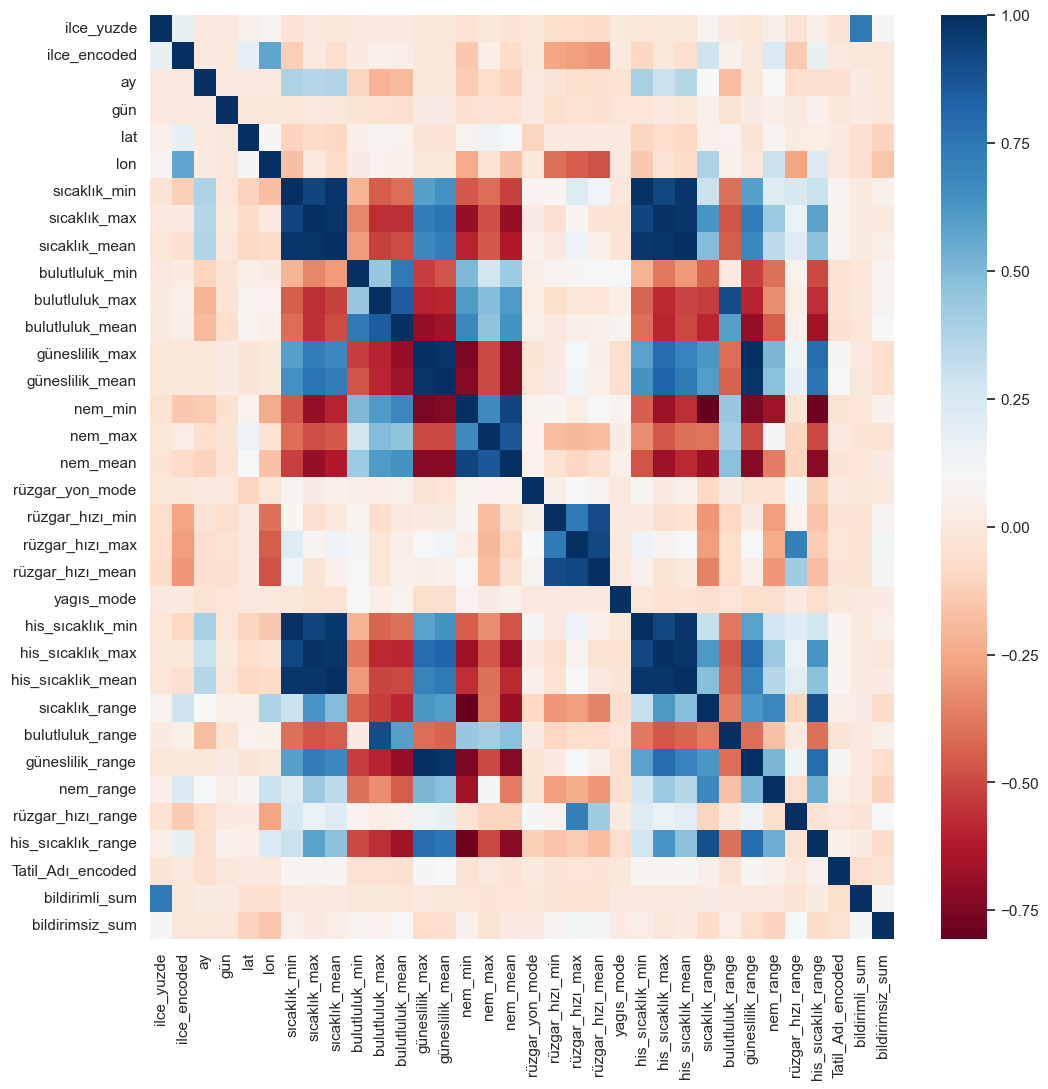

In [107]:
#Display correlations
sns.set(rc={'figure.figsize': (12, 12)})
sns.heatmap(corr, cmap="RdBu")
plt.show()

In [114]:
def high_correlated_cols(dataframe, plot=False, corr_th=0.70):
    corr = dataframe.corr()
    cor_matrix = corr.abs()
    upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(np.bool))
    drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] > corr_th)]
    if plot:
        import seaborn as sns
        import matplotlib.pyplot as plt
        sns.set(rc={'figure.figsize': (15, 15)})
        sns.heatmap(corr, cmap="RdBu")
        plt.show()
    return drop_list

high_correlated_cols(df_train_EDA, plot= False)


['il_encoded',
 'haftaiçi',
 'haftasonu',
 'sıcaklık_max',
 'sıcaklık_mean',
 'bulutluluk_mean',
 'güneslilik_max',
 'güneslilik_mean',
 'nem_min',
 'nem_mean',
 'rüzgar_hızı_max',
 'rüzgar_hızı_mean',
 'his_sıcaklık_min',
 'his_sıcaklık_max',
 'his_sıcaklık_mean',
 'sıcaklık_range',
 'bulutluluk_range',
 'güneslilik_range',
 'rüzgar_hızı_range',
 'his_sıcaklık_range',
 'Tatil_Adı_encoded',
 'bildirimli_sum']

<AxesSubplot: title={'center': 'Correlation Matrix'}>

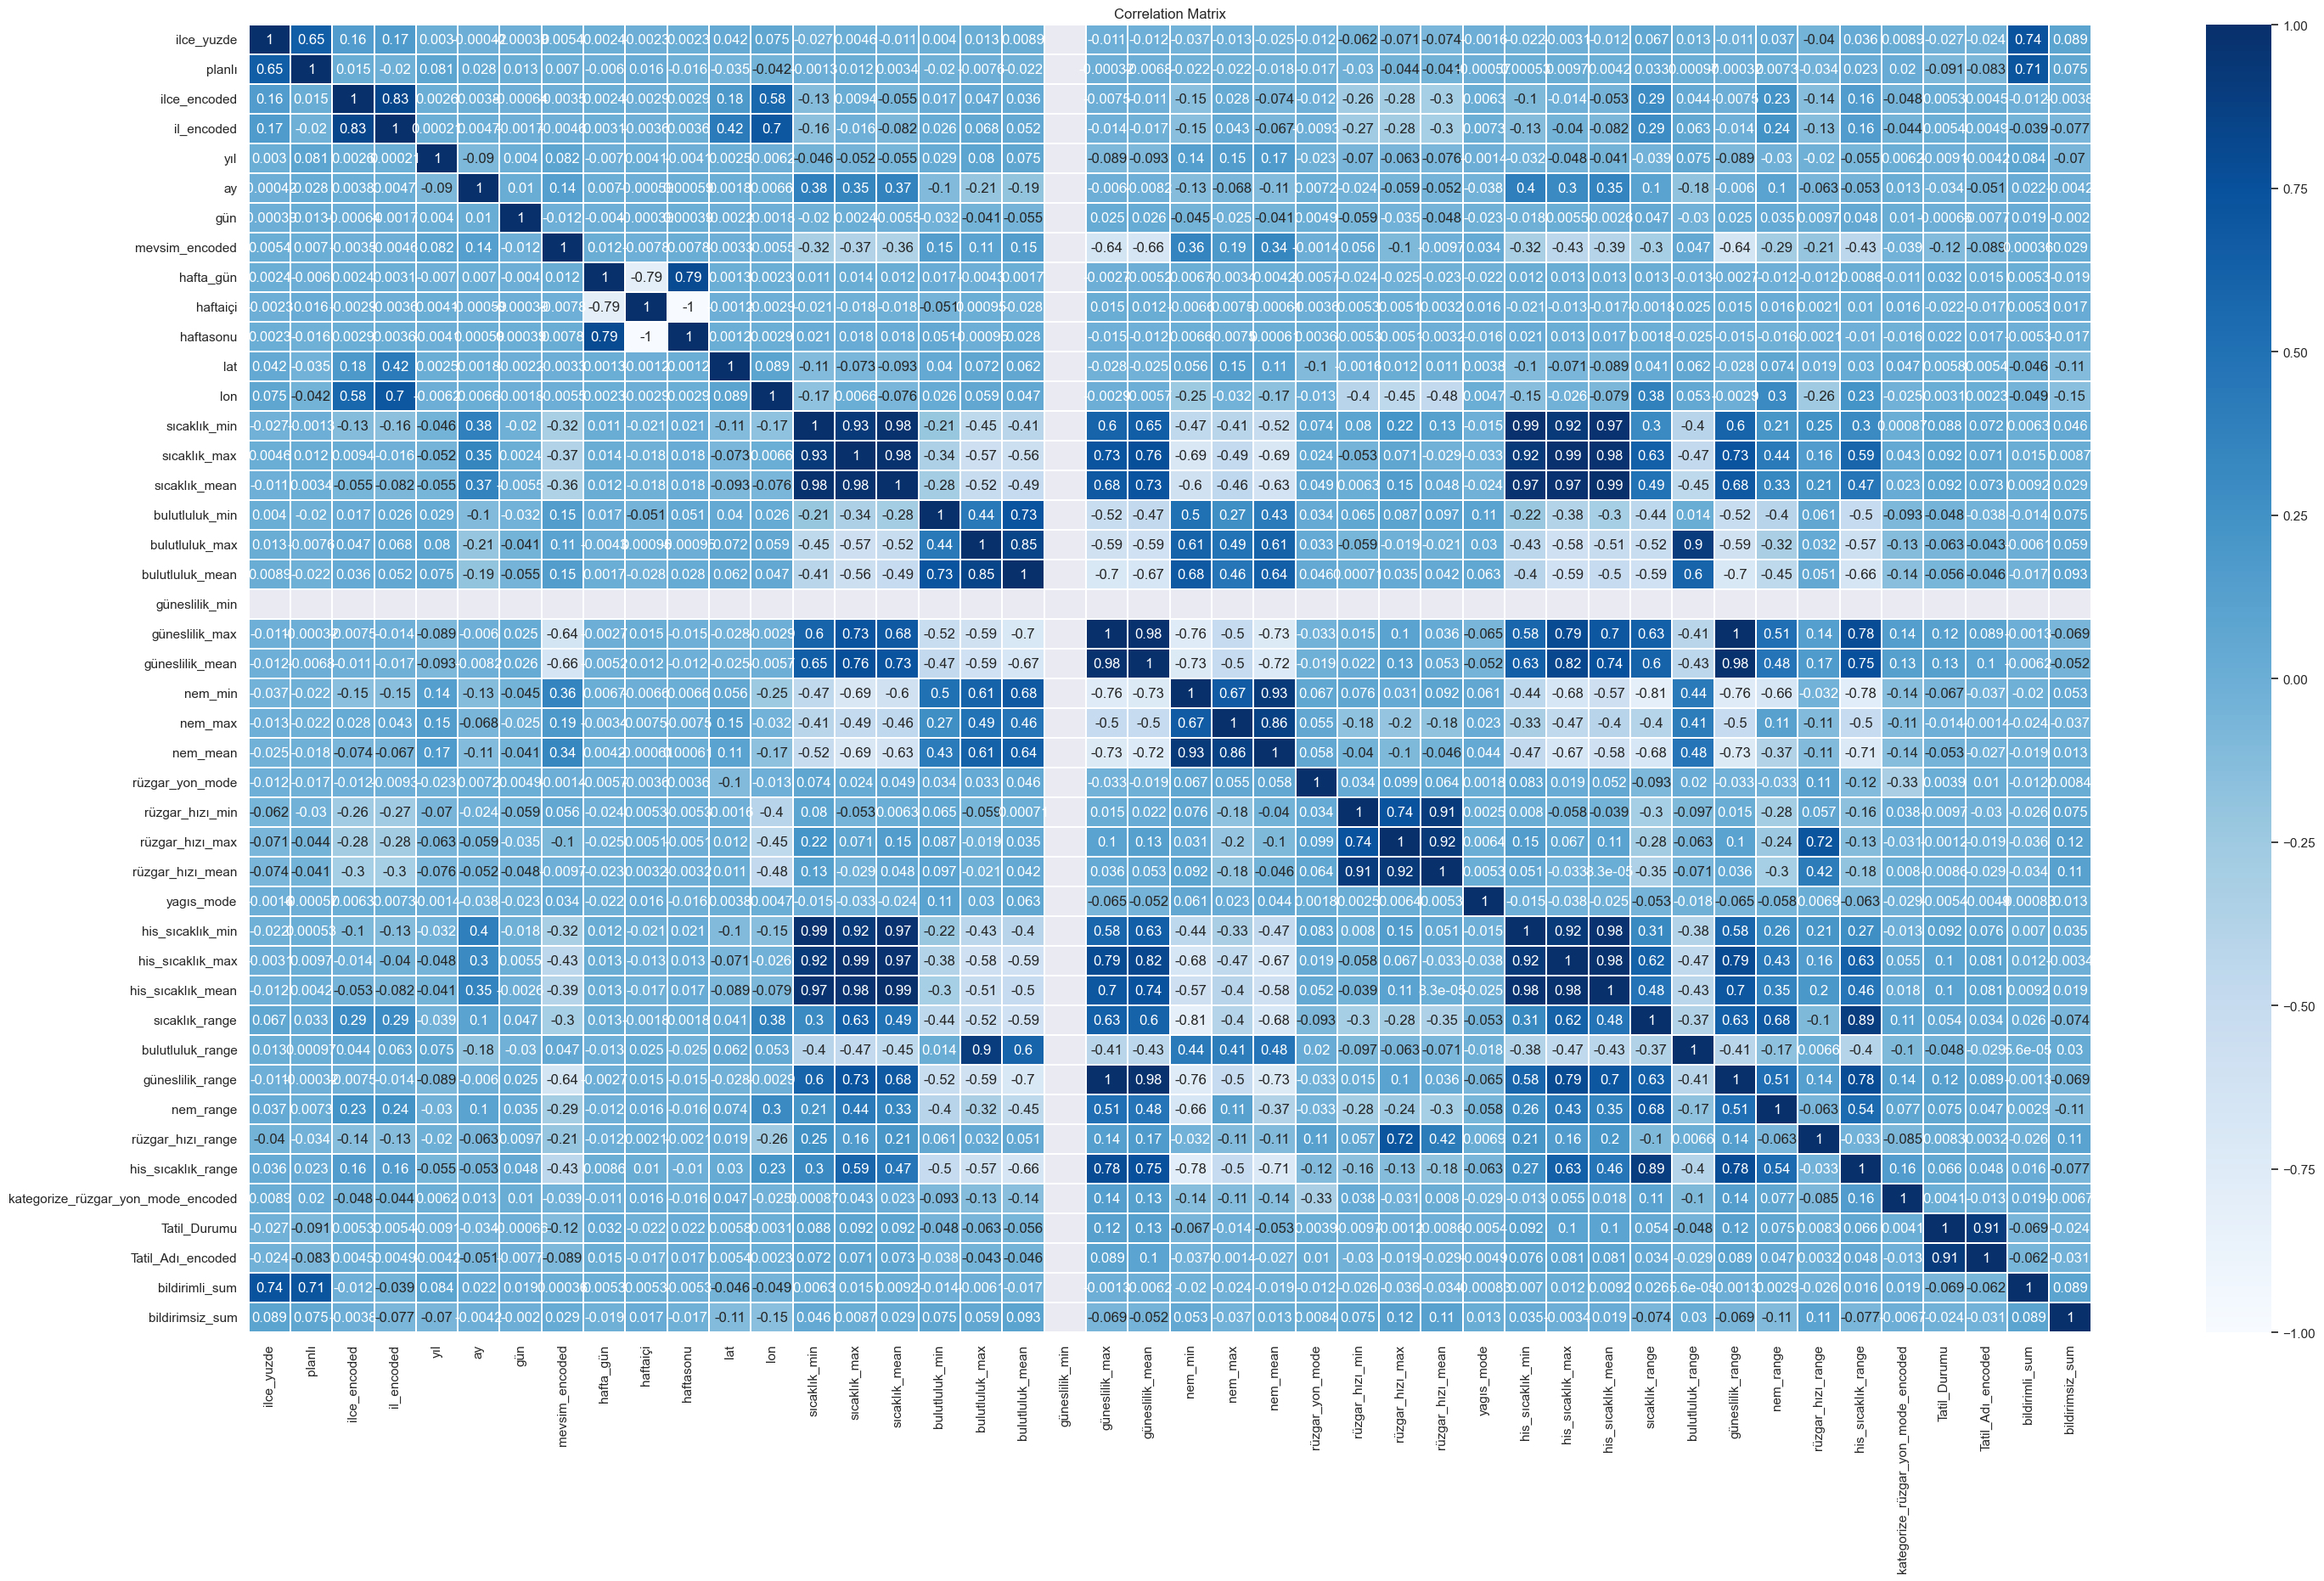

In [117]:
# Display the heatmap to get the relationships between data features 
sns.set(rc={"figure.figsize":(35,20)})
plt.title("Correlation Matrix")
sns.heatmap(df_train_EDA.corr(), annot=True , linewidths = 0.3, cmap = 'Blues')

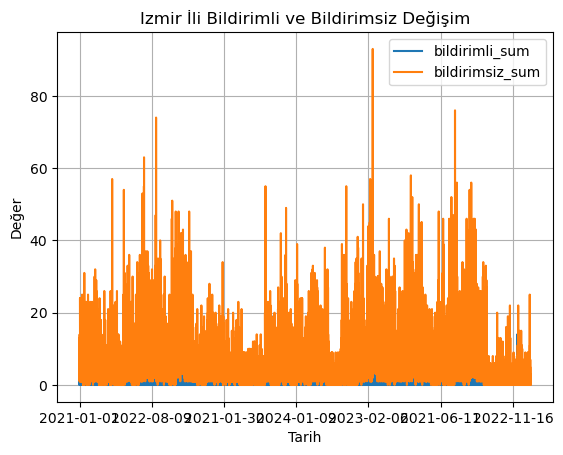

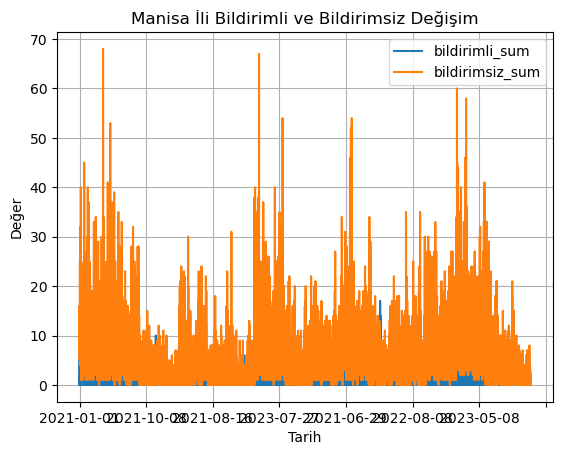

In [56]:
# Plot separate graphs for each province
iller = df_train_EDA['il'].unique()
for il in iller:
    il_df = df_train_EDA[df_train_EDA['il'] == il]
    il_df.plot(x='tarih', y=['bildirimli_sum', 'bildirimsiz_sum'], kind='line', title=f'{il} İli Bildirimli ve Bildirimsiz Değişim', xlabel='Tarih', ylabel='Değer', grid=True)
    plt.show()

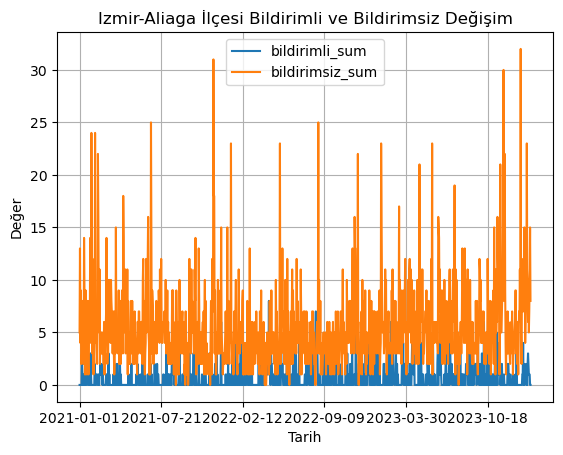

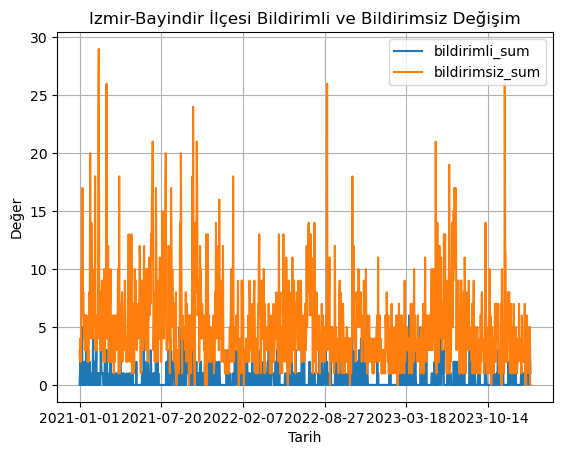

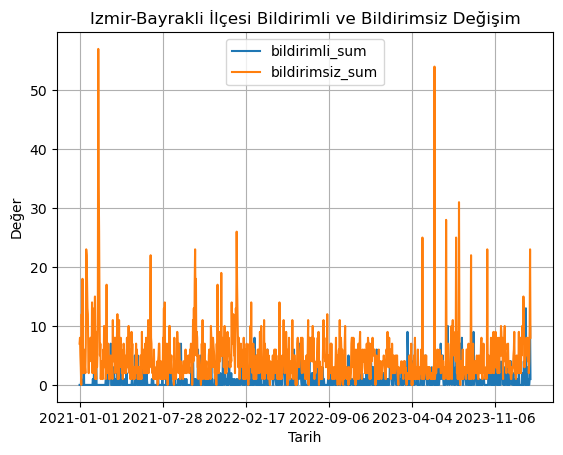

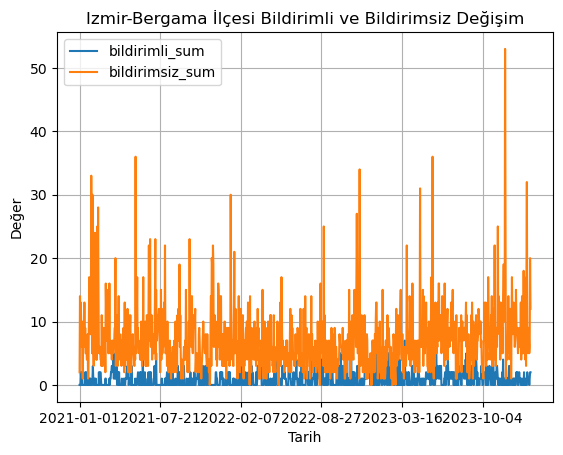

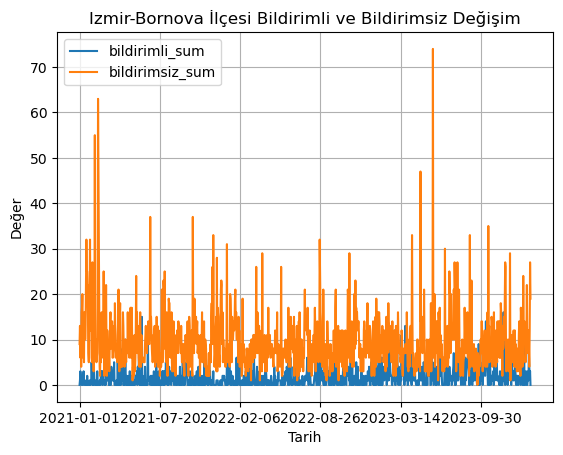

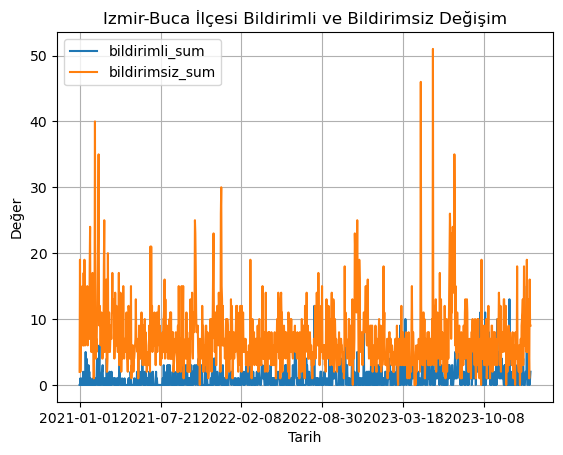

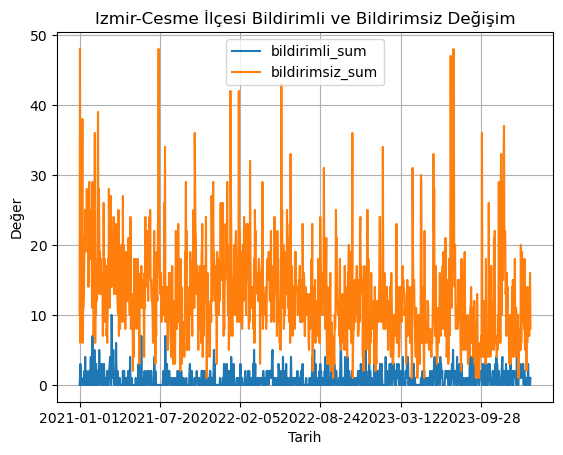

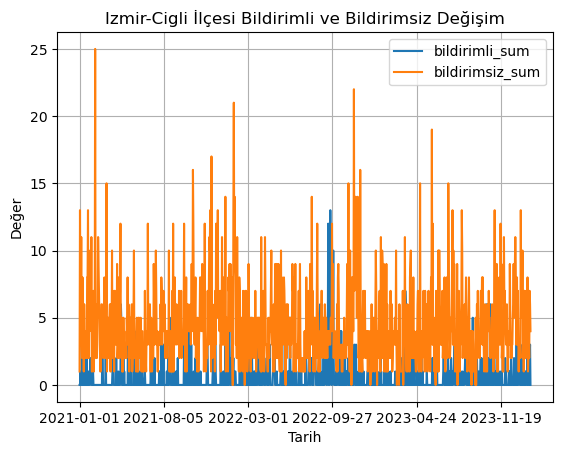

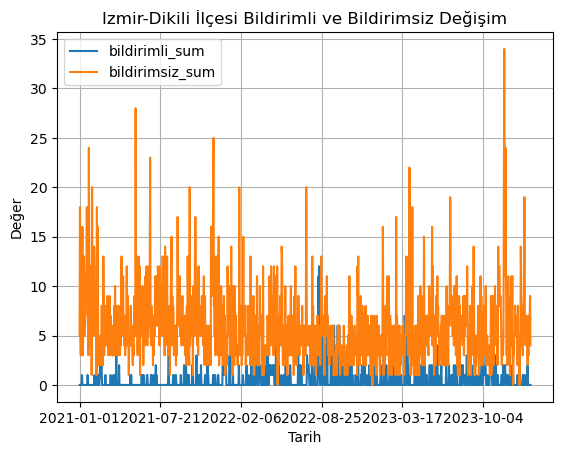

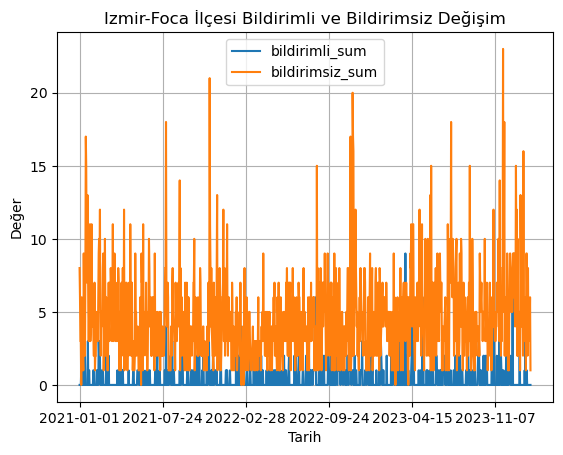

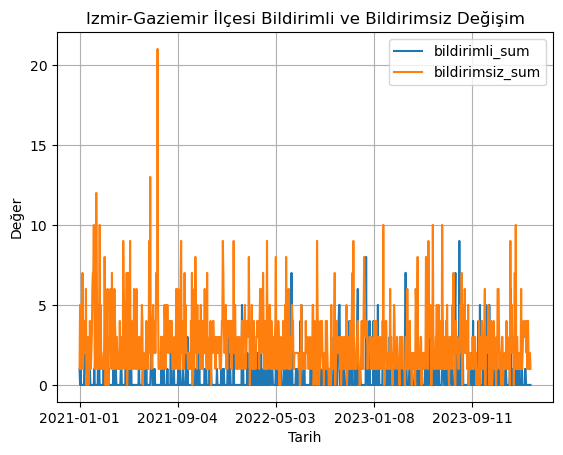

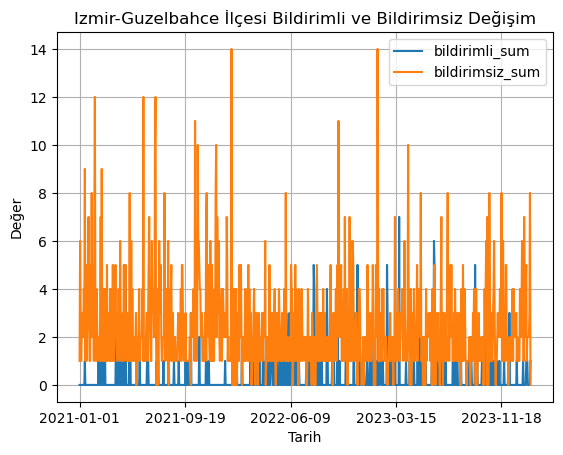

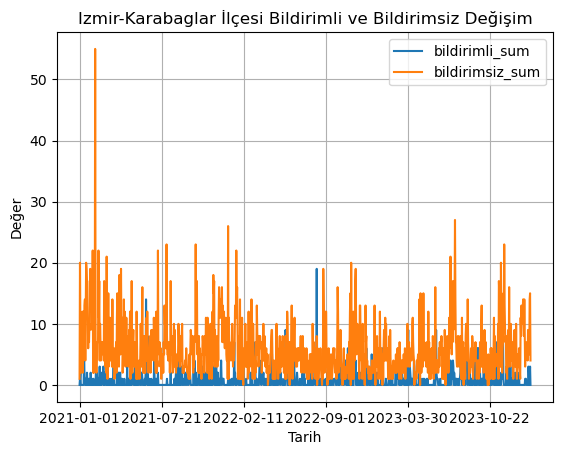

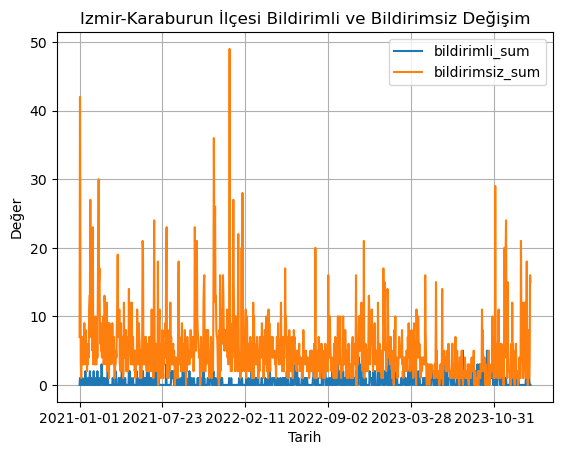

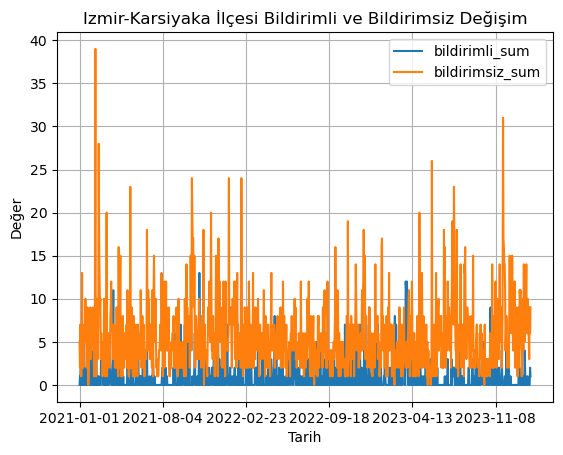

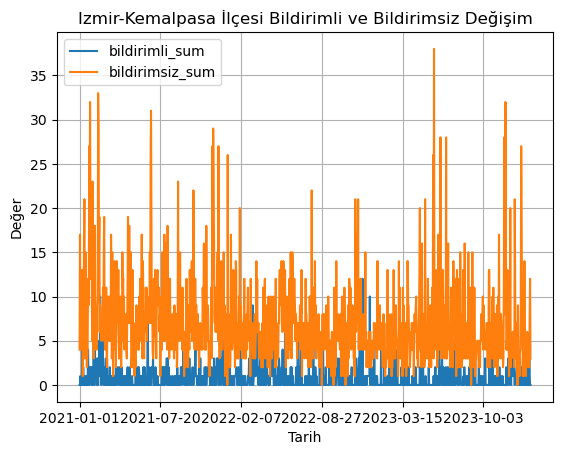

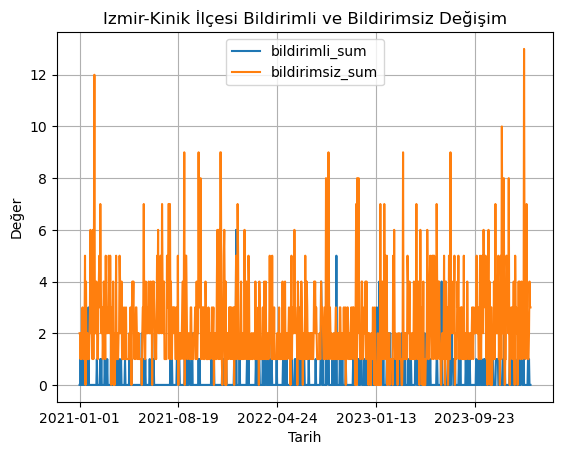

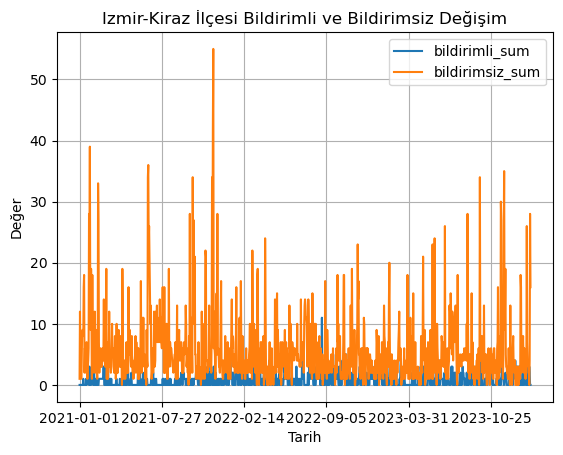

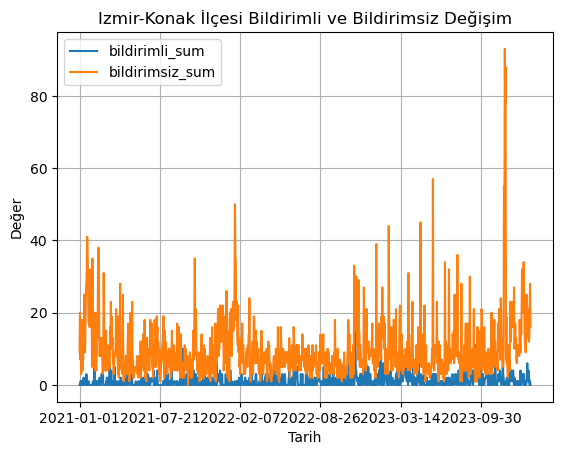

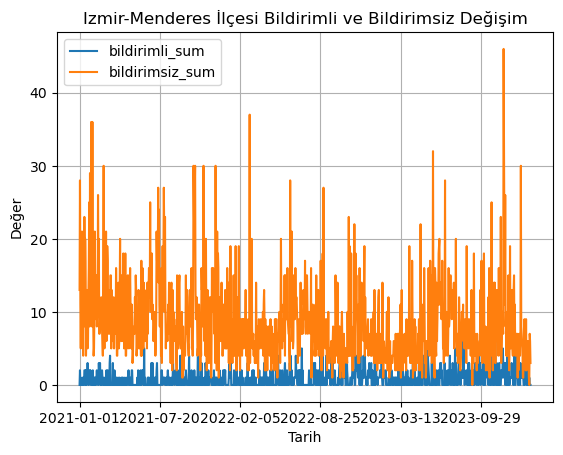

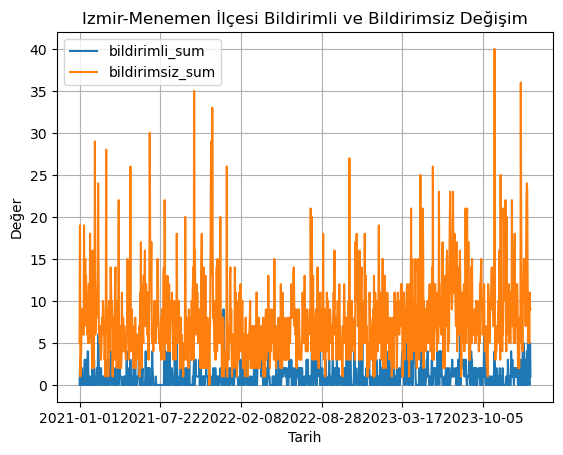

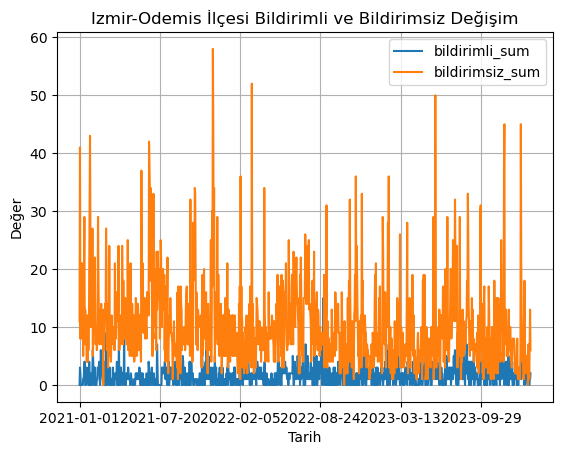

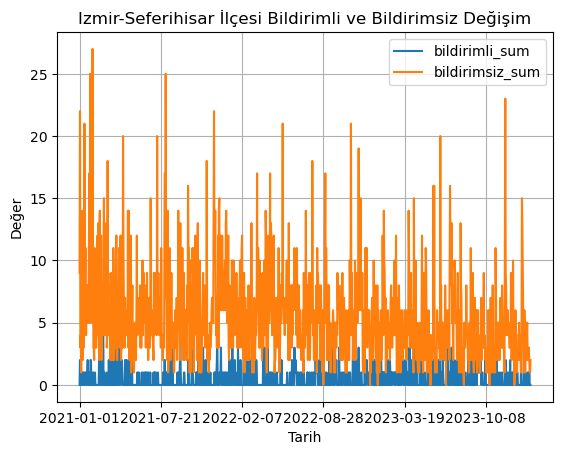

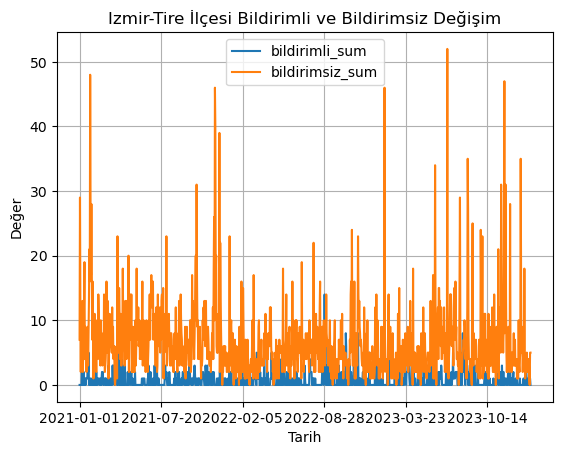

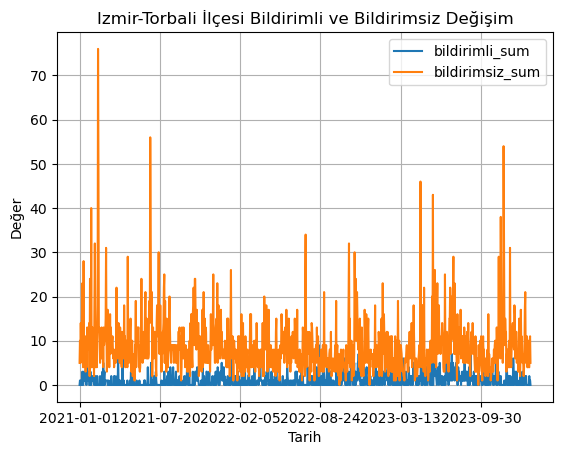

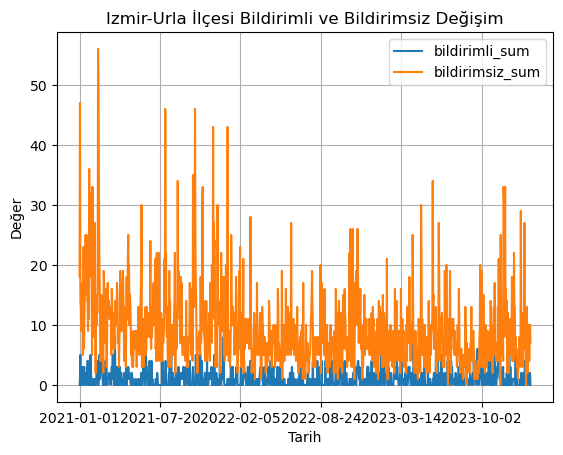

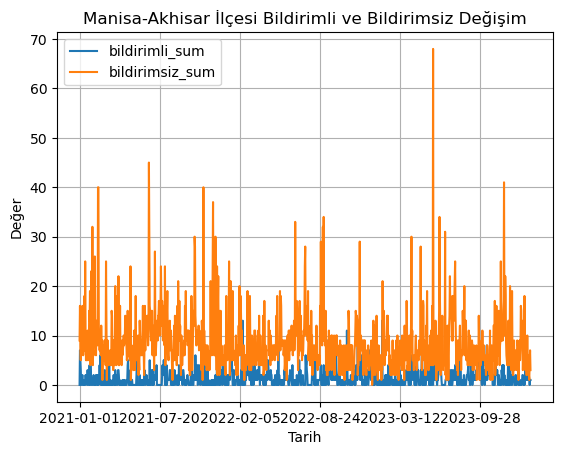

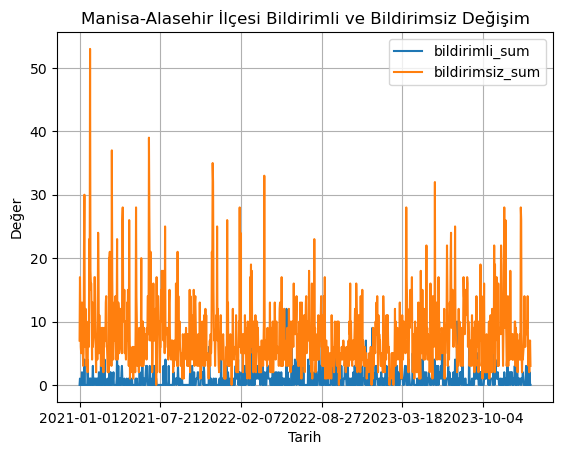

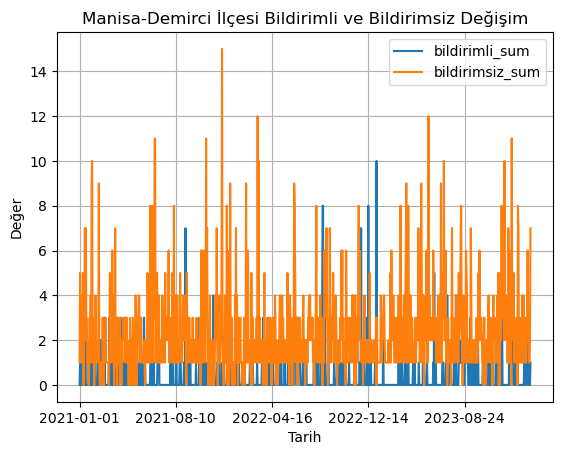

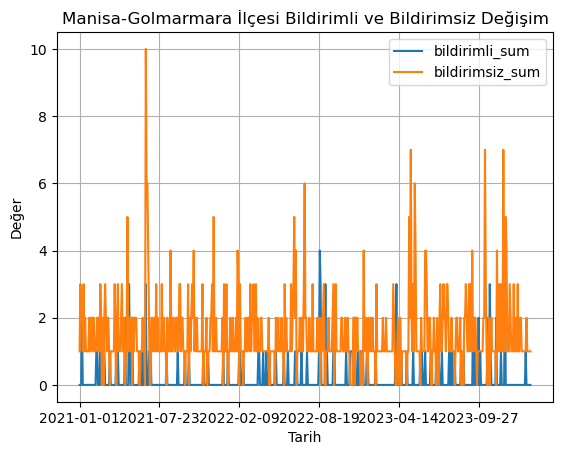

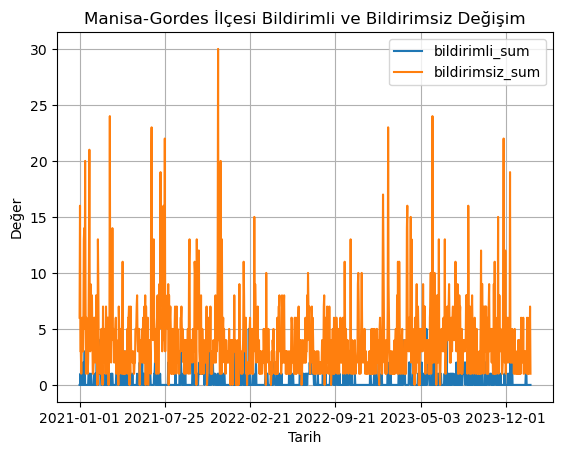

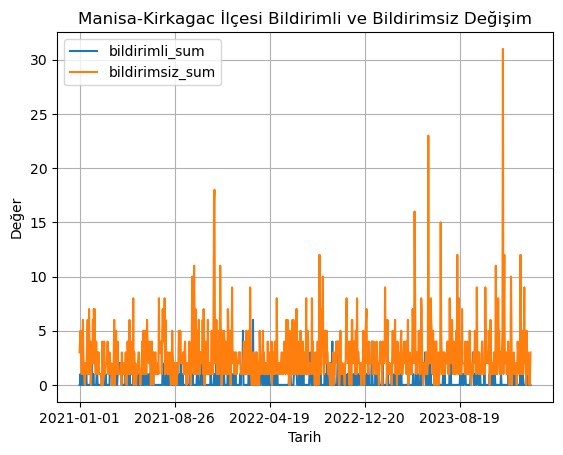

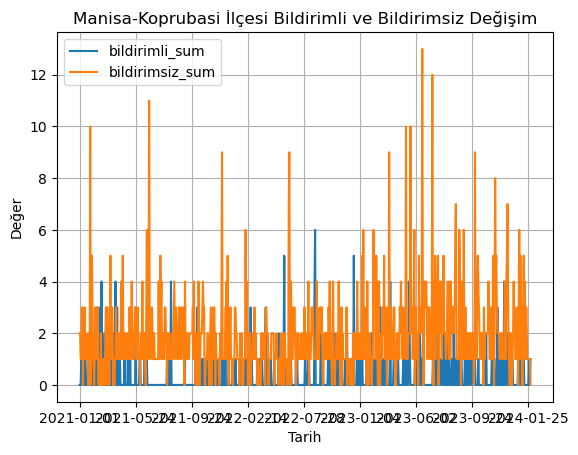

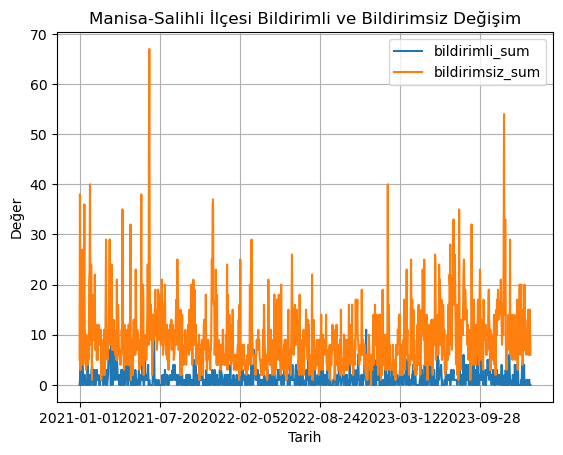

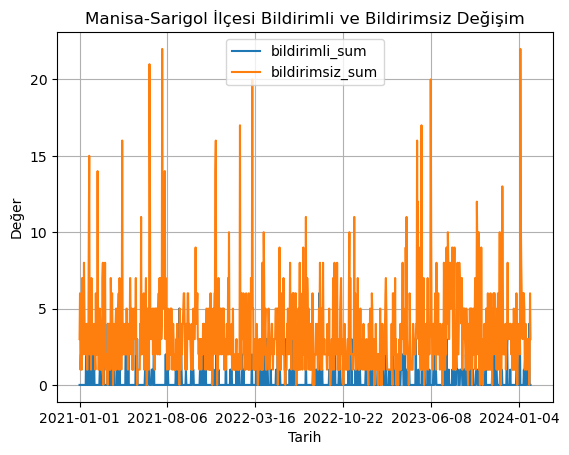

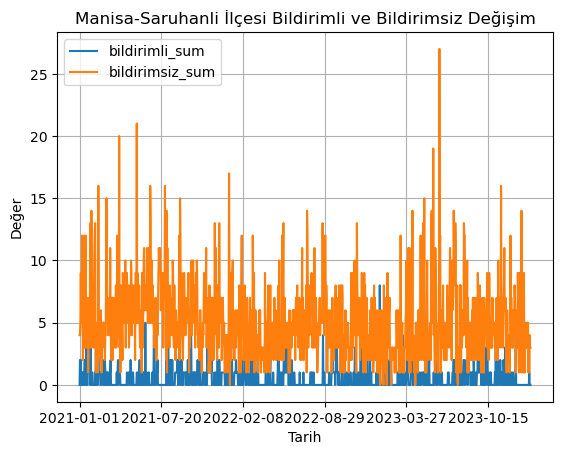

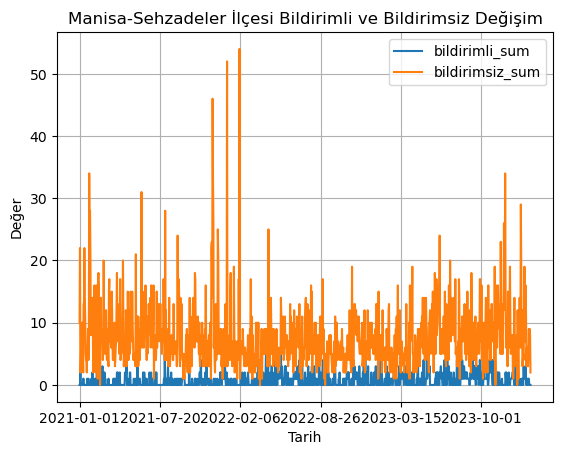

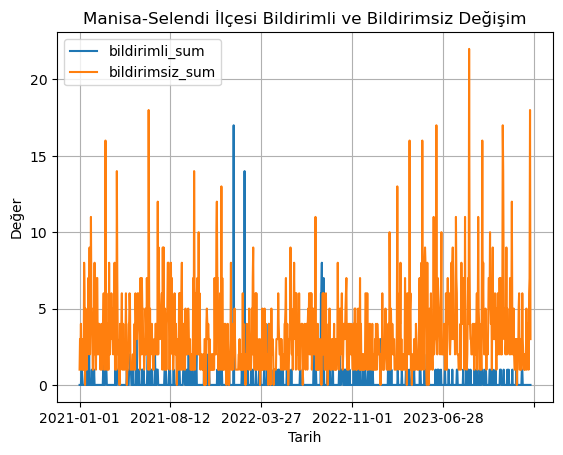

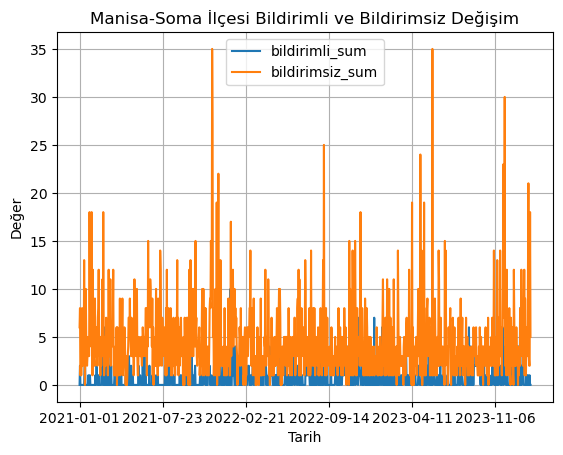

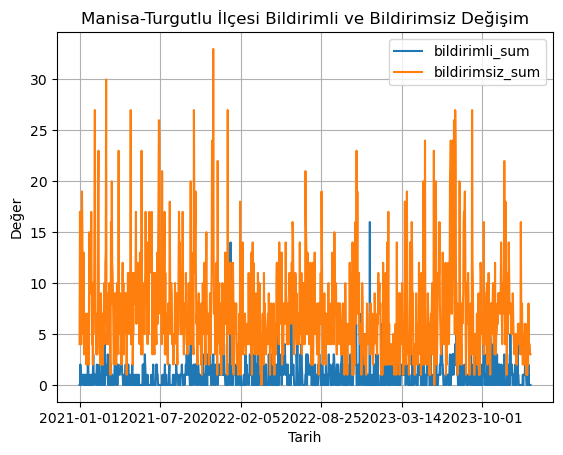

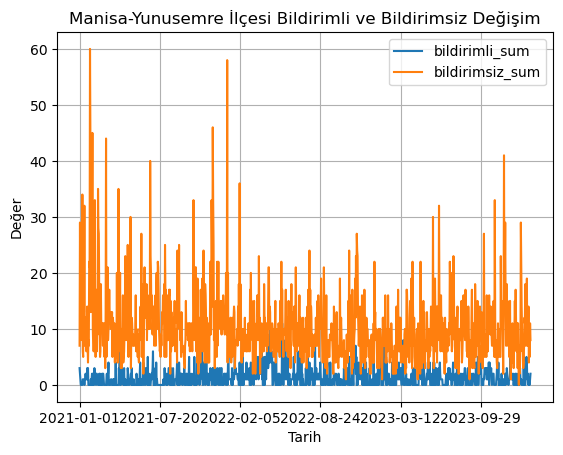

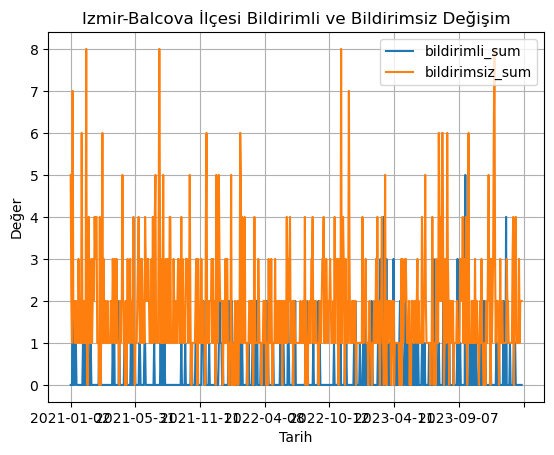

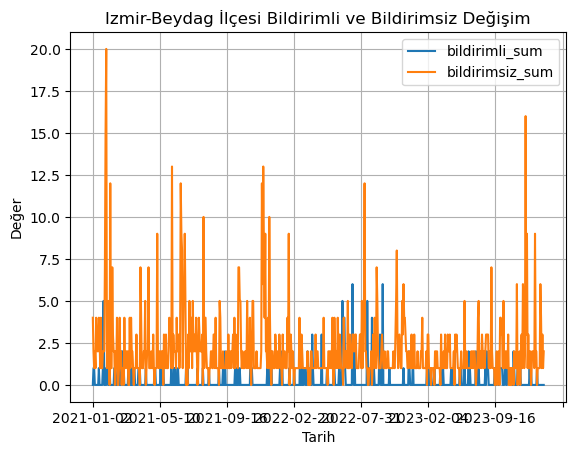

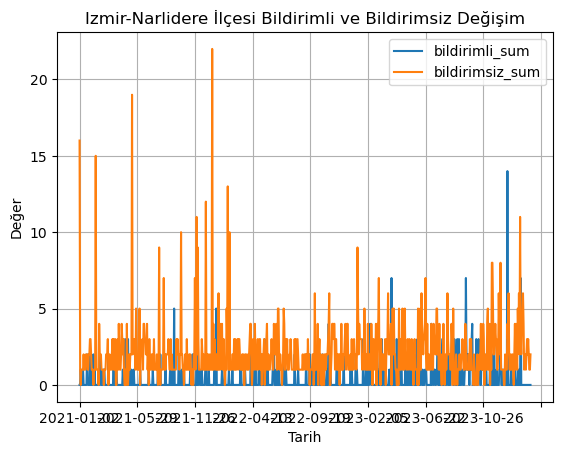

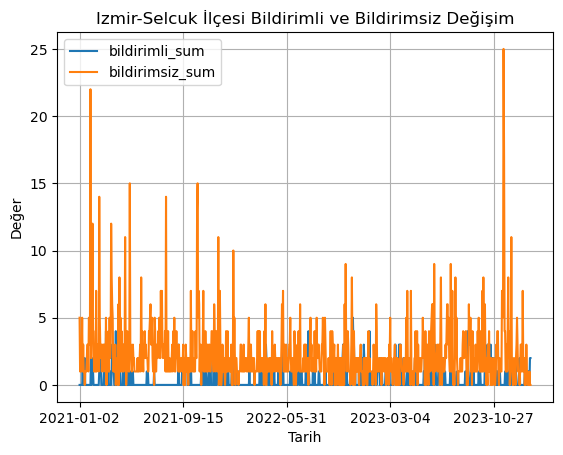

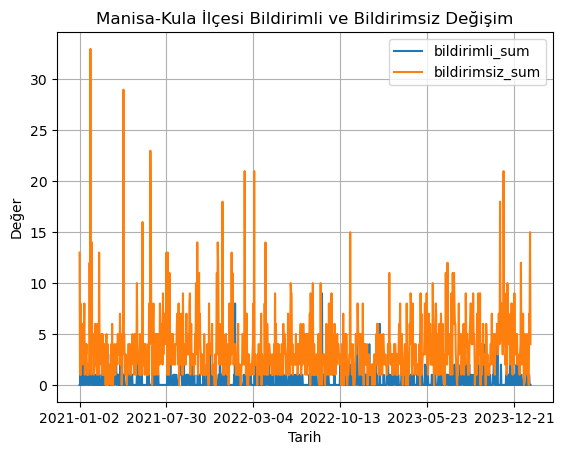

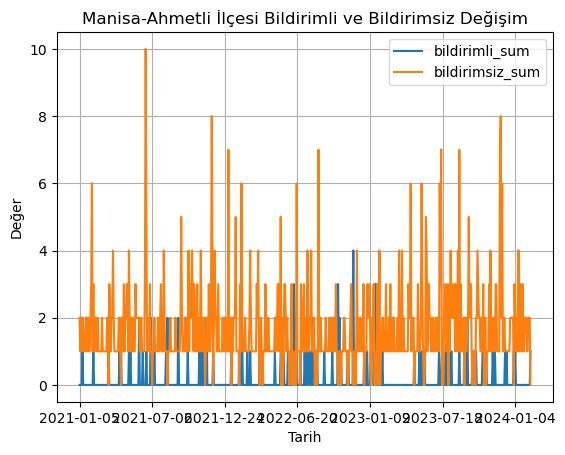

In [59]:
# Plot separate graphs for each district
ilceler = df_train_EDA['ilce'].unique()
for ilce in ilceler:
    ilce_df = df_train_EDA[df_train_EDA['ilce'] == ilce]
    ilce_df.plot(x='tarih', y=['bildirimli_sum', 'bildirimsiz_sum'], kind='line', title=f'{ilce} İlçesi Bildirimli ve Bildirimsiz Değişim', xlabel='Tarih', ylabel='Değer', grid=True)
    plt.show()

In [132]:
import folium
from folium.plugins import HeatMap

df_train_EDA['bildirimsiz_sum'] = df_train_EDA['bildirimsiz_sum'].astype(float)

# Calculate the normalized weights for the heatmap
df_train_EDA['Normalized_bildirimsiz_sum'] = df_train_EDA['bildirimsiz_sum'] / df_train_EDA['bildirimsiz_sum'].max()

# Create a Folium map centered around the mean of the latitude and longitude
map = folium.Map(location=[df_train_EDA['lat'].mean(), df_train_EDA['lon'].mean()], zoom_start=10)

# Add a HeatMap to the map
heatmap_data = df_train_EDA[['lat', 'lon', 'Normalized_bildirimsiz_sum']].values.tolist()
HeatMap(heatmap_data, radius=15, blur=10, max_zoom=1).add_to(map)

# Show the map
map

# MODELS

In [26]:
# Import the necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost.sklearn import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV, cross_validate, RandomizedSearchCV, validation_curve
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

### Defining The Features and Data

In [298]:
# Perform one-hot encoding on the DataFrame, encoding specified columns and dropping the first category to prevent multicollinearity
df_train_encoded = pd.get_dummies(df_train_EDA, columns=["il", "ilce"], drop_first=True)

# Define the features and target variables
ftrain= ['planlı', 'yıl', 'ay', 'mevsim_encoded', 'haftasonu', 'sıcaklık_min', 'sıcaklık_max', 'sıcaklık_mean', 'bulutluluk_max', 'bulutluluk_mean', 'güneslilik_mean', 'nem_max', 'nem_mean', 'rüzgar_yon_mode', 'rüzgar_hızı_max', 'rüzgar_hızı_mean', 'his_sıcaklık_mean', 'sıcaklık_range', 'rüzgar_hızı_range', 'his_sıcaklık_range', 'Tatil_Durumu', 'Tatil_Adı_encoded', 'bildirimli_sum', 'bildirimsiz_sum', 'il_Manisa', 'ilce_Izmir-Balcova', 'ilce_Izmir-Bayindir', 'ilce_Izmir-Bayrakli', 'ilce_Izmir-Bergama', 'ilce_Izmir-Beydag', 'ilce_Izmir-Bornova', 'ilce_Izmir-Buca', 'ilce_Izmir-Cesme', 'ilce_Izmir-Cigli', 'ilce_Izmir-Dikili', 'ilce_Izmir-Foca', 'ilce_Izmir-Gaziemir', 'ilce_Izmir-Guzelbahce', 'ilce_Izmir-Karabaglar', 'ilce_Izmir-Karaburun', 'ilce_Izmir-Karsiyaka', 'ilce_Izmir-Kemalpasa', 'ilce_Izmir-Kinik', 'ilce_Izmir-Kiraz', 'ilce_Izmir-Konak', 'ilce_Izmir-Menderes', 'ilce_Izmir-Menemen', 'ilce_Izmir-Narlidere', 'ilce_Izmir-Odemis', 'ilce_Izmir-Seferihisar', 'ilce_Izmir-Selcuk', 'ilce_Izmir-Tire', 'ilce_Izmir-Torbali', 'ilce_Izmir-Urla', 'ilce_Manisa-Ahmetli', 'ilce_Manisa-Akhisar', 'ilce_Manisa-Alasehir', 'ilce_Manisa-Demirci', 'ilce_Manisa-Golmarmara', 'ilce_Manisa-Gordes', 'ilce_Manisa-Kirkagac', 'ilce_Manisa-Koprubasi', 'ilce_Manisa-Kula', 'ilce_Manisa-Salihli', 'ilce_Manisa-Sarigol', 'ilce_Manisa-Saruhanli', 'ilce_Manisa-Sehzadeler', 'ilce_Manisa-Selendi', 'ilce_Manisa-Soma', 'ilce_Manisa-Turgutlu', 'ilce_Manisa-Yunusemre']
data = df_train_encoded[ftrain]

# Split the data into features (X) and target (y)
X = data.drop(columns=['bildirimsiz_sum']).values
y = data['bildirimsiz_sum'].values

### Training Models and Evaluation

In [300]:
# Perform cross-validated evaluation of various regression models using mean absolute error (MAE) as the evaluation metric
models = [('LR', LinearRegression()),
          ('KNN', KNeighborsRegressor()),
          ('CART', DecisionTreeRegressor()),
          ('RF', RandomForestRegressor()),
          ('GBM', GradientBoostingRegressor()),
          ("XGBoost", XGBRegressor(objective='reg:squarederror')),
          ("LightGBM", LGBMRegressor()),
          ("CatBoost", CatBoostRegressor(verbose=False))]

for name, regressor in models:
    mae = np.mean(-cross_val_score(regressor, X, y, cv=5, scoring="neg_mean_absolute_error"))
    print(f"MAE: {round(mae, 4)} ({name}) ")

MAE: 827665724.7312 (LR) 
MAE: 4.0672 (KNN) 
MAE: 4.8636 (CART) 
MAE: 4.0144 (RF) 
MAE: 3.7847 (GBM) 
MAE: 3.6672 (XGBoost) 
MAE: 3.7111 (LightGBM) 
MAE: 3.6548 (CatBoost) 


In [30]:
df_train_EDA = pd.read_csv('df_train_EDA.csv')
df_test_EDA = pd.read_csv('df_test_EDA.csv')
df_sample_submission = pd.read_csv('sample_submission.csv')

### The best 2-scoring models among the models developed for submission

In [32]:
# Perform one-hot encoding on the training and test datasets, encoding specified columns and dropping the first category to prevent multicollinearity
df_train_encoded = pd.get_dummies(df_train_EDA, columns=["il", "ilce"], drop_first=True)
df_test_encoded = pd.get_dummies(df_test_EDA, columns=["il", "ilce"], drop_first=True)

# Define the features and target variables for training and test datasets
ftrain= ['planlı', 'yıl', 'ay', 'mevsim_encoded', 'haftasonu', 'sıcaklık_min', 'sıcaklık_max', 'sıcaklık_mean', 'bulutluluk_max', 'bulutluluk_mean', 'güneslilik_mean', 'nem_max', 'nem_mean', 'rüzgar_yon_mode', 'rüzgar_hızı_max', 'rüzgar_hızı_mean', 'his_sıcaklık_mean', 'sıcaklık_range', 'rüzgar_hızı_range', 'his_sıcaklık_range', 'Tatil_Durumu', 'Tatil_Adı_encoded', 'bildirimli_sum', 'bildirimsiz_sum', 'il_Manisa', 'ilce_Izmir-Balcova', 'ilce_Izmir-Bayindir', 'ilce_Izmir-Bayrakli', 'ilce_Izmir-Bergama', 'ilce_Izmir-Beydag', 'ilce_Izmir-Bornova', 'ilce_Izmir-Buca', 'ilce_Izmir-Cesme', 'ilce_Izmir-Cigli', 'ilce_Izmir-Dikili', 'ilce_Izmir-Foca', 'ilce_Izmir-Gaziemir', 'ilce_Izmir-Guzelbahce', 'ilce_Izmir-Karabaglar', 'ilce_Izmir-Karaburun', 'ilce_Izmir-Karsiyaka', 'ilce_Izmir-Kemalpasa', 'ilce_Izmir-Kinik', 'ilce_Izmir-Kiraz', 'ilce_Izmir-Konak', 'ilce_Izmir-Menderes', 'ilce_Izmir-Menemen', 'ilce_Izmir-Narlidere', 'ilce_Izmir-Odemis', 'ilce_Izmir-Seferihisar', 'ilce_Izmir-Selcuk', 'ilce_Izmir-Tire', 'ilce_Izmir-Torbali', 'ilce_Izmir-Urla', 'ilce_Manisa-Ahmetli', 'ilce_Manisa-Akhisar', 'ilce_Manisa-Alasehir', 'ilce_Manisa-Demirci', 'ilce_Manisa-Golmarmara', 'ilce_Manisa-Gordes', 'ilce_Manisa-Kirkagac', 'ilce_Manisa-Koprubasi', 'ilce_Manisa-Kula', 'ilce_Manisa-Salihli', 'ilce_Manisa-Sarigol', 'ilce_Manisa-Saruhanli', 'ilce_Manisa-Sehzadeler', 'ilce_Manisa-Selendi', 'ilce_Manisa-Soma', 'ilce_Manisa-Turgutlu', 'ilce_Manisa-Yunusemre']
ftest= ['planlı', 'yıl', 'ay', 'mevsim_encoded', 'haftasonu', 'sıcaklık_min', 'sıcaklık_max', 'sıcaklık_mean', 'bulutluluk_max', 'bulutluluk_mean', 'güneslilik_mean', 'nem_max', 'nem_mean', 'rüzgar_yon_mode', 'rüzgar_hızı_max', 'rüzgar_hızı_mean', 'his_sıcaklık_mean', 'sıcaklık_range', 'rüzgar_hızı_range', 'his_sıcaklık_range', 'Tatil_Durumu', 'Tatil_Adı_encoded', 'bildirimli_sum', 'il_Manisa', 'ilce_Izmir-Balcova', 'ilce_Izmir-Bayindir', 'ilce_Izmir-Bayrakli', 'ilce_Izmir-Bergama', 'ilce_Izmir-Beydag', 'ilce_Izmir-Bornova', 'ilce_Izmir-Buca', 'ilce_Izmir-Cesme', 'ilce_Izmir-Cigli', 'ilce_Izmir-Dikili', 'ilce_Izmir-Foca', 'ilce_Izmir-Gaziemir', 'ilce_Izmir-Guzelbahce', 'ilce_Izmir-Karabaglar', 'ilce_Izmir-Karaburun', 'ilce_Izmir-Karsiyaka', 'ilce_Izmir-Kemalpasa', 'ilce_Izmir-Kinik', 'ilce_Izmir-Kiraz', 'ilce_Izmir-Konak', 'ilce_Izmir-Menderes', 'ilce_Izmir-Menemen', 'ilce_Izmir-Narlidere', 'ilce_Izmir-Odemis', 'ilce_Izmir-Seferihisar', 'ilce_Izmir-Selcuk', 'ilce_Izmir-Tire', 'ilce_Izmir-Torbali', 'ilce_Izmir-Urla', 'ilce_Manisa-Ahmetli', 'ilce_Manisa-Akhisar', 'ilce_Manisa-Alasehir', 'ilce_Manisa-Demirci', 'ilce_Manisa-Golmarmara', 'ilce_Manisa-Gordes', 'ilce_Manisa-Kirkagac', 'ilce_Manisa-Koprubasi', 'ilce_Manisa-Kula', 'ilce_Manisa-Salihli', 'ilce_Manisa-Sarigol', 'ilce_Manisa-Saruhanli', 'ilce_Manisa-Sehzadeler', 'ilce_Manisa-Selendi', 'ilce_Manisa-Soma', 'ilce_Manisa-Turgutlu', 'ilce_Manisa-Yunusemre']

# Define the training and test data using the selected features
data = df_train_encoded[ftrain]
data_test = df_test_encoded[ftest]

# Split the training data into features (X_train) and target variable
X_train = data.drop('bildirimsiz_sum', axis=1).values
y_train = data['bildirimsiz_sum'].values
X_test = data_test.values

# Create a StandardScaler object for standardization
scaler = StandardScaler()

# Standardize the training and test sets
X_train_standardized = scaler.fit_transform(X_train)
X_test_standardized = scaler.transform(X_test)

# Perform a double logarithmic transformation on the target variable
y_train_log_log = np.log1p(np.log1p(y_train))

# Check the shapes of the datasets
print("Train set shape:", data.shape)
print("Test set shape:", data_test.shape)
print("X_train shape:", X_train.shape)
print("y_train_log_log shape:", y_train_log_log.shape)
print("X_test shape:", X_test.shape)
print("X_train_standardized shape:", X_train_standardized.shape)
print("X_test_standardized shape:", X_test_standardized.shape) 

Train set shape: (48148, 71)
Test set shape: (1363, 70)
X_train shape: (48148, 70)
y_train_log_log shape: (48148,)
X_test shape: (1363, 70)
X_train_standardized shape: (48148, 70)
X_test_standardized shape: (1363, 70)


In [34]:
# Create a PolynomialFeatures object with degree 2, excluding bias terms
poly = PolynomialFeatures(degree=2, include_bias=False)

# Transform the standardized training and test sets to polynomial features
X_poly_train = poly.fit_transform(X_train_standardized)
X_poly_test = poly.fit_transform(X_test_standardized)

## LightGBM model resulting in a score of 1.81918

In [36]:
# Train the LightGBM regressor model on the polynomial features of the standardized training set
lgbm = LGBMRegressor().fit(X_poly_train, y_train_log_log)

# Predict the target variable using the trained model on the polynomial features of the standardized test set
y_pred_log_log = lgbm.predict(X_poly_test)

# Perform the inverse transformation of the double logarithmic transformation to obtain the final predictions
y_pred_lgbm = np.expm1(np.expm1(y_pred_log_log))

In [37]:
# Create a DataFrame with the predictions
df_Submission = pd.DataFrame({"unique_id": df_sample_submission["unique_id"], "bildirimsiz_sum": y_pred_lgbm})

# Save the DataFrame to a CSV file
df_Submission.to_csv("sample_submission.csv", index=False)

## Catboost model resulting in a score of 1.79112

In [41]:
# Train the Catboost regressor model on the polynomial features of the standardized training set
catboost_model = CatBoostRegressor(random_state=17, verbose=False).fit(X_poly_train, y_train_log_log)

# Predict the target variable using the trained model on the polynomial features of the standardized test set
y_pred_log_log = catboost_model.predict(X_poly_test)

# Perform the inverse transformation of the double logarithmic transformation to obtain the final predictions
y_pred_catboost = np.expm1(np.expm1(y_pred_log_log))

In [42]:
# Create a DataFrame with the predictions
df_Submission = pd.DataFrame({"unique_id": df_sample_submission["unique_id"], "bildirimsiz_sum": y_pred_catboost})

# Save the DataFrame to a CSV file
df_Submission.to_csv("sample_submission.csv", index=False)